<a href="https://colab.research.google.com/github/CalculatedContent/ww-colab/blob/master/ww_kdd2020_0_100_Update010520.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

In [0]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import itertools
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import files #Google colab ONLY

In [0]:
istart = 0
iend = istart+100

In [0]:
## If export the output to Google Drive (colab ONLY) --> Optional
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
path = '/content/drive/My Drive/kdd2020_cv'
sys.path.append(path)

In [0]:
#!mkdir "$path"
!ls "$path"

In [0]:
!pip install weightwatcher #install from source
#!pip install powerlaw #needed if install ww from local

In [0]:
import weightwatcher as ww

# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# crea
import logging
logger = logging.getLogger("imported_module")
logger.setLevel(logging.CRITICAL)

Using TensorFlow backend.


# **PyTorchCV Models** 

## These cells need to be rerun multiple times to get all the data![alt text](https://)

### **1. Analyze all models in Pytorchcv**

In [0]:
!pip install pytorchcv

In [0]:
## Check storage
#import subprocess
#p = subprocess.Popen('df -h', shell=True, stdout=subprocess.PIPE)
#print(str(p.communicate()[0], 'utf-8'))

In [0]:
from pytorchcv.model_provider import get_model as ptcv_get_model
import torch

import pytorchcv
import pytorchcv.models.model_store

modelnames = pytorchcv.models.model_store._model_sha1.keys()
modelnames = list(modelnames)
print('{} models to examine'.format(len(modelnames)))

466 models to examine


In [0]:
# this_models = pd.read_excel('notfound.xlsx')[0].tolist()
# len(this_models[1:])

# Reun upto and including this cell  until all data is available

In [0]:
## Takes about 10-15 hours to run 100 models as of 9/3/2019

data = {}
ss = time.time()
i = 0
notfound = []
ww_error = []
for modelname in modelnames[istart:iend]: 
    print(modelname)
    try:
        s = time.time()
        model = ptcv_get_model(modelname, pretrained=True)

    except:
        notfound.append(modelname)
        e = time.time()
        print("{} not found".format(modelname))
        print('--------------------------------------------------------')
        i += 1
        continue

    try:
        watcher = ww.WeightWatcher(model=model, logger=logger)
        results = watcher.analyze(alphas = True, spectralnorms=True, softranks=True, mp_fit = True, normalize = True)
        e = time.time()
        
        data[modelname]=watcher.get_summary()
        
        print('time spent is {}'.format((e-s)/60.))
        print('--------------------------------------------------------')
        
    except:
        ww_error.append(modelname)
        e = time.time()
        print("Error in weightwatcher operation for {}".format(modelname))
        print('--------------------------------------------------------')
        
    i += 1

    #Export/backup the results every 1 hour runtime or every 50 models  
    if ((e - ss) > 60*60) or ((i - istart)%25 == 0): 
      
        ddf = pd.DataFrame.from_dict(data).transpose()
        ddf.to_excel(path + '/data_{}-{}_{}.xlsx'.format(istart, i, dt.date.today()))
        
        ss = time.time()
        
        #try:
        #    !rm -rf /root/.torch/models #clean the memory
        #except:
        #    pass
          
    if i >= iend: #Export when all models are finished
      
        ddf = pd.DataFrame.from_dict(data).transpose()
        ddf.to_excel(path + '/data_{}-{}_{}.xlsx'.format(istart, i, dt.date.today()))
        
        # break

ddf = pd.DataFrame.from_dict(data).transpose()
ddf.to_excel(path + '/data_{}-{}_{}.xlsx'.format(istart, i, dt.date.today()))

alexnet
time spent is 7.0102576533953345
--------------------------------------------------------
alexnetb
time spent is 6.797596605618795
--------------------------------------------------------
zfnet
time spent is 7.022138114770254
--------------------------------------------------------
zfnetb
time spent is 9.517169304688771
--------------------------------------------------------
vgg11
time spent is 11.297437330087027
--------------------------------------------------------
vgg13
time spent is 11.38835506439209
--------------------------------------------------------
vgg16
time spent is 12.995876638094584
--------------------------------------------------------
vgg19
time spent is 14.268740419546763
--------------------------------------------------------
bn_vgg11
time spent is 12.267664535840352
--------------------------------------------------------
bn_vgg13
time spent is 12.494501038392384
--------------------------------------------------------
bn_vgg16
time spent is 13.412141

# Stop Here until all data is available

In [0]:
## Export the whole dataset mannually
# ddf = pd.DataFrame.from_dict(data).transpose()
# ddf.to_excel(path + '/df_all.xlsx')
#files.download(path + '/df_all.xlsx')
# ddf.to_excel(path + '/data_{}-{}_{}.xlsx'.format(start, i, dt.date.today()))

In [0]:
#f notfound != []:
    pd.DataFrame(notfound).to_excel(path + '/notfound_{}.xlsx'.format(dt.date.today()))

if ww_error != []:
    pd.DataFrame(notfound).to_excel(path + '/ww_error_{}.xlsx'.format(dt.date.today()))

IndentationError: ignored

# Read in all pre-computed Data

In [0]:
try:
    ## Load the model results data
    # df_all = pd.read_excel('/content/drive/My Drive/df_all.xlsx')\
    #       .rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
    df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
    df_all.head()

except:
    ## If the above cell runs different batches of the data
    ## Use this cell to concat the data together
    print('Concating files...')
    df_all = pd.DataFrame()
    for f in os.listdir(path):
        if f.startswith('data_'): #detect data
            tempp = pd.read_excel(path + '/' + f)\
                        .rename(columns = {'Unnamed: 0':'modelname'})
            df_all = pd.concat([df_all, tempp], axis = 0, sort = False)
            print(f)
            print(df_all.tail(1))

    del tempp

    df_all = df_all.drop_duplicates().reset_index(drop = True)

print(len(df_all))
#df_all.dropna(inplace=True)
#print(len(df_all))

Concating files...
data_300-25_2019-12-29.xlsx
                   modelname      norm  ...  logpnorm  logpnorm_compound
24  sepreresnet272bn_cifar10  3.598437  ...  0.491766           0.507995

[1 rows x 27 columns]
data_100-18_2019-12-29.xlsx
      modelname       norm  ...  logpnorm  logpnorm_compound
17  darknet_ref  15.638652  ...  3.687241           4.241232

[1 rows x 27 columns]
data_200-22_2019-12-29.xlsx
           modelname       norm  ...  logpnorm  logpnorm_compound
21  efficientnet_b0b  29.835979  ...  6.485159           6.485159

[1 rows x 27 columns]
data_0-7_2019-12-29.xlsx
  modelname       norm  ...  logpnorm  logpnorm_compound
6     vgg16  17.114365  ...  3.943699           3.874627

[1 rows x 27 columns]
data_200-25_2019-12-29.xlsx
           modelname       norm  ...  logpnorm  logpnorm_compound
24  efficientnet_b3b  20.932428  ...  5.294569           5.294569

[1 rows x 27 columns]
data_100-25_2019-12-29.xlsx
   modelname      norm  ...  logpnorm  logpnorm_compoun

In [0]:
!ls "$path"/df_all.xlsx

ls: cannot access '/content/drive/My Drive/kdd2020_cv/df_all.xlsx': No such file or directory


In [0]:
len(df_all)

466

In [0]:
## Get the modelname of outliers
# temp = df_all.copy()
# temp = temp.sort_values(['softrank'], ascending = False)
# outliers_sr = temp['modelname'].tolist()[:10]

# temp = temp.sort_values(['spectralnorm'], ascending = False)
# outliers_sp = temp['modelname'].tolist()[:10]

# [s for s in outliers_sp if s not in outliers_sr]

In [0]:
## Get the details of outliers
# writer = pd.ExcelWriter('/content/drive/My Drive/sp_outliers.xlsx')
# for s in [s for s in outliers_sp if s not in outliers_sr]:#outliers:
#     model = ptcv_get_model(s, pretrained=True) #'resnet542bn_svhn'
#     watcher = ww.WeightWatcher(model=model, logger=logger)
#     results = watcher.analyze(compute_alphas = False, compute_spectralnorms=True, compute_softranks=True)
    
#     temp1 = watcher.get_details()
#     temp1.to_excel(writer, s)
    
# writer.save()

### **2. Plots with Test Accuracies**

In [0]:
from bs4 import BeautifulSoup
import requests
import re

In [0]:
'''Load the test accuracies'''
url = "https://github.com/osmr/imgclsmob/blob/master/pytorch/README.md"
df_accuracy = pd.read_html(url)

In [0]:
'''Create the matchtable: Match the model name'''
response = requests.get(url)
page = str(BeautifulSoup(response.content, features="lxml"))

## To find the category of models to group when plotting
models = re.findall('<li>(.*) \(<a href=', page) 

## The naming convention is not very consistent, therefore, to help with identification,
## I input the exceptions
exceptions = {'SqueezeNext': 'SqNxt', 'DIA-ResNet': 'DIA-PreResNet', 
              'DarkNet Ref/Tiny/19': 'DarkNet Tiny', 
              'IBN-ResNet/IBN-ResNeXt/IBN-DenseNet': 'IBN(b)-ResNet'} 
models_ = [m if m not in exceptions.keys() else m+'/'+exceptions[m] for m in models]
models_ = [m.split('/') for m in models_]

## Use reg exp to extract the dataset name, modelnames (used in README), and 
## modelnames (used in codes)
datasets = re.findall('<h3><a aria-hidden="true" class="anchor" href="#(.*)" id', page)
lst1_name = re.findall('<tr>\n<td>(.*)</td>', page)
lst2_name = re.findall('\n<td>.* \(<a href="(.*)">log</a>\)</td>\n</tr>', page)

if len(lst1_name) != len(lst2_name):
    print('Number does not match!')

df_table = pd.DataFrame(lst1_name, columns = ['Model'])

## Note: there are duplicate Model names, hence cannot use merge naively
df_table['modelname'] = [m.split('/')[-1][:-22] for m in lst2_name]

In [0]:
'''Identify the architexture for each pretrained model'''
class ContinueI(Exception):
    pass

continue_i = ContinueI()

arch = []
for i in range(len(df_table)):
    try:
        for mm in models_:
            for m1 in mm:
                ## Name convention 1: the model name starts with the arch name
                if df_table.loc[i, 'Model'].startswith(m1): 
                    arch.append(mm)
                    raise continue_i
        try:
            ## Name convention 2: if the model name starts with number, 
            ## the arch name is in the middle of the model name
            this = re.findall('[0-9]+-(.*)', df_table.loc[i, 'Model'])[0]
        except:
            arch.append(np.nan)
            raise continue_i

        for mm in models_:
            for m1 in mm:
                if this.startswith(m1):
                    arch.append(mm)

                    raise continue_i

        arch.append(np.nan)

    except ContinueI:
        continue

df_table['group'] = arch
df_table['group'] = df_table['group'].apply(lambda x: '/'.join(x))


In [0]:
'''Match the model name using matchtable'''
# df_all = pd.read_excel(path + '/df_all.xlsx').rename(columns = {'Unnamed: 0': 'index'}).set_index('index')
df_all['spectralnormlog'] = np.log(df_all['spectralnorm'])

df_full = []
i = 0

for df in df_accuracy:
    # Because there are duplicate Model names (on README), you cannot
    # simply use merge
    df = df.copy()
    df['modelname'] = df_table.loc[i:i+len(df)-1, 'modelname'].tolist()#temp[i:i+len(df)]
    df['group'] = df_table.loc[i:i+len(df)-1, 'group'].tolist()
    i += len(df)

    del df['Remarks']

    df = df.merge(df_all, on = 'modelname', how = 'left')

    df_full.append(df)

df_full = dict(zip(datasets, df_full))


In [0]:
df_full['imagenet-1k']

Model   Top1   Top5  ...  logpnorm logpnorm_compound spectralnormlog
0           AlexNet  40.96  18.24  ...  3.450368          3.825587        1.973164
1         AlexNet-b  41.58  19.00  ...  3.322105          3.711291        1.834833
2             ZFNet  39.79  17.27  ...  2.972471          3.639878        2.336944
3           ZFNet-b  36.37  14.90  ...  3.014555          3.690477        2.428623
4            VGG-11  29.90  10.36  ...  3.942310          3.887104        3.111649
..              ...    ...    ...  ...       ...               ...             ...
230        MixNet-M  22.93   6.60  ...  6.019755          6.019755        2.672500
231        MixNet-L  21.12   5.82  ...  5.352066          5.352066        2.861143
232   ResNet(D)-50b  21.04   5.65  ...  2.784886          2.338287        1.871273
233  ResNet(D)-101b  19.59   4.73  ...  0.626878          1.049262        1.067803
234  ResNet(D)-152b  19.42   4.82  ... -0.352708          0.401250        0.566286

[235 rows x 34 columns]

In [0]:
'''[SETUP CELL] Start Plotting'''
metrics = ['alpha', 'alpha_weighted', 'spectralnormlog', 'softrank', 'norm', 'norm_compound' ] #specify the ww matrics
metrics_acc = ['Top1', 'Top5', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

metrics = ['alpha', 'alpha_weighted', 'spectralnormlog',  'softranklog',  'lognorm' ,'logpnorm' ] #specify the ww matrics
metrics_acc = ['Top1', 'Error, %', 'Pix.Acc.,%', 'mIoU,%'] #specify the test accuracy

num_rows = 2
num_cols = 3

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ValueError: ignored

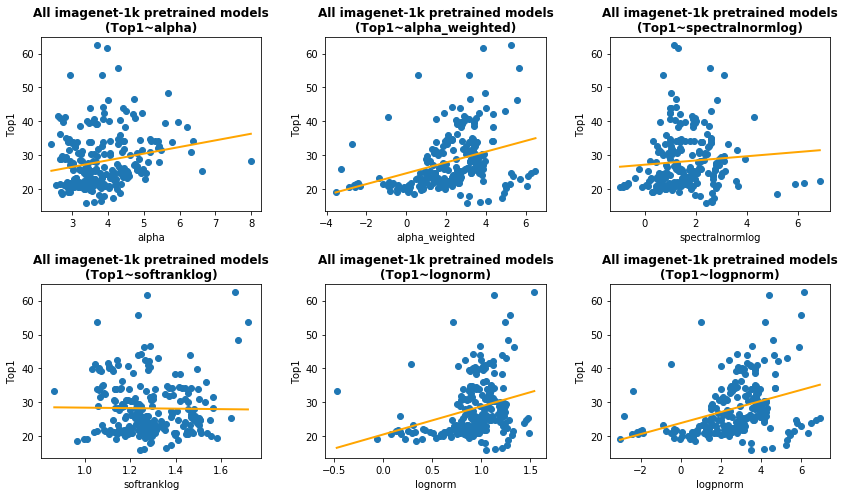

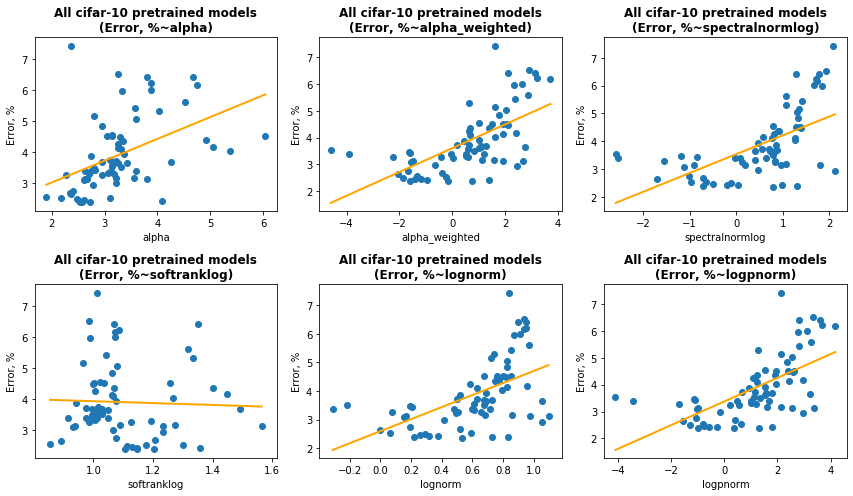

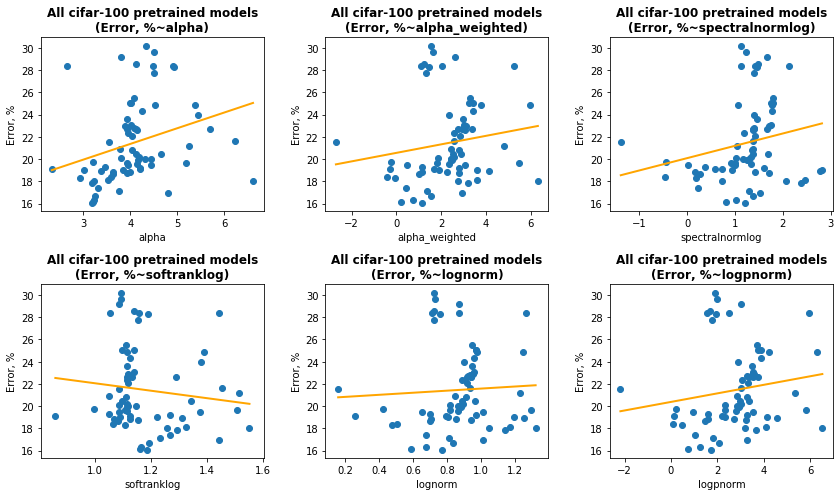

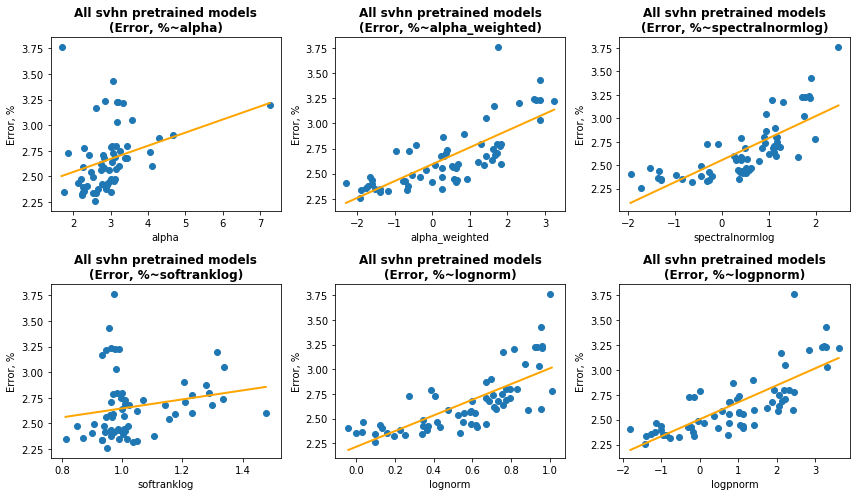

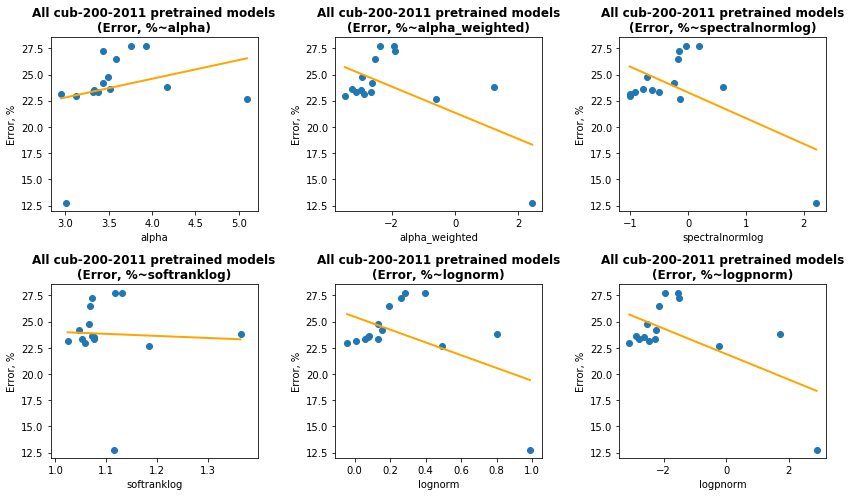

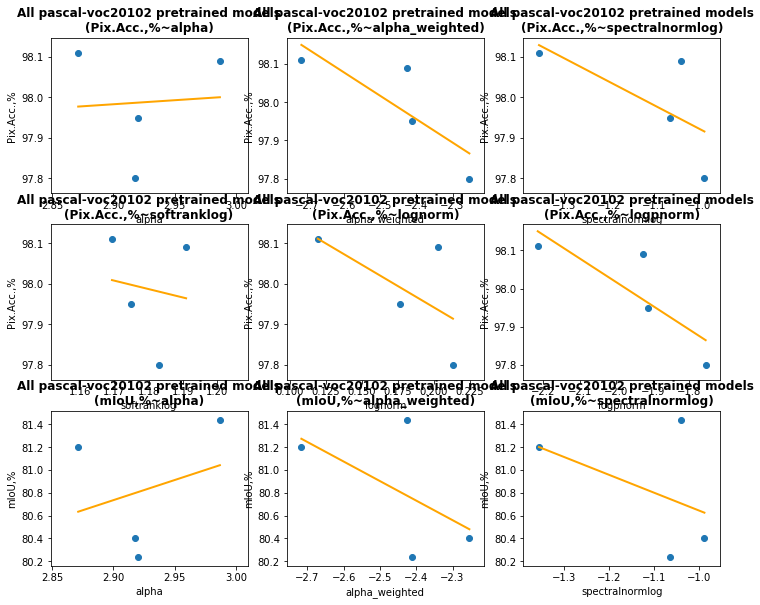

In [0]:
%matplotlib inline
plot_fit = True

'''Plotting by datasets'''
df_fit0 = []

for d in datasets:
    temp = df_full[d].copy()

    if len(temp) == 1:
        continue

    tacc = [c for c in metrics_acc if c in temp.columns]

    plotloc = int(len(tacc)*len(metrics)/num_rows*100 + 10*num_cols + 1)


    if len(tacc) > 1:
        plt.figure(figsize = (12,20))
    else:
        plt.figure(figsize = (12,10))

    for ac in tacc:#metrics_acc:
        for x in metrics:
            plt.subplot(plotloc)
            plt.scatter(temp[x], temp[ac])
            plt.xlabel(x)
            plt.ylabel(ac)
            plt.title('All {} pretrained models\n({}~{})'.format(d, ac, x), 
                      fontweight = 'bold')

            if plot_fit == True:
                temp = temp.dropna().reset_index(drop = True)
                this_fit = sm.OLS(temp[ac], sm.add_constant(temp[x])).fit()
                this_x = np.linspace(min(temp[x]), max(temp[x]), 1000)
                plt.plot(this_x, this_fit.predict(sm.add_constant(this_x)), linewidth = 2, color = 'orange')
                df_fit0.append([d, ac, x, this_fit.ssr/len(temp), this_fit.rsquared])
            plotloc += 1

    plt.tight_layout()

del temp
del tacc

if df_fit0 != []:
    df_fit0 = pd.DataFrame(df_fit0, columns = ['dataset', 'test accuracy', 'x variable', 'MSE', 'r^2'])

In [0]:
if type(df_fit0) != list:
    print(df_fit0.head(20))

# Drop additional NaN models that somehow went wrong here

In [0]:
df.dropna(inplace=True)

ValueError: ignored

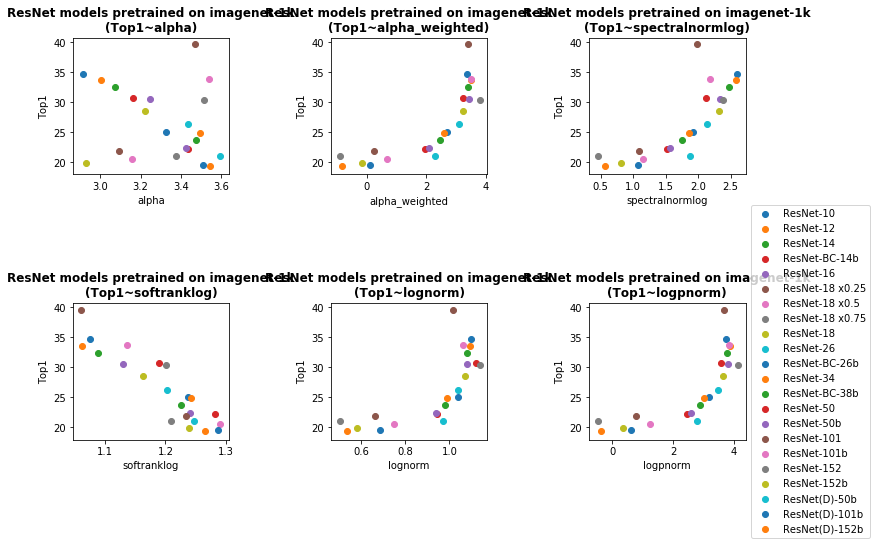

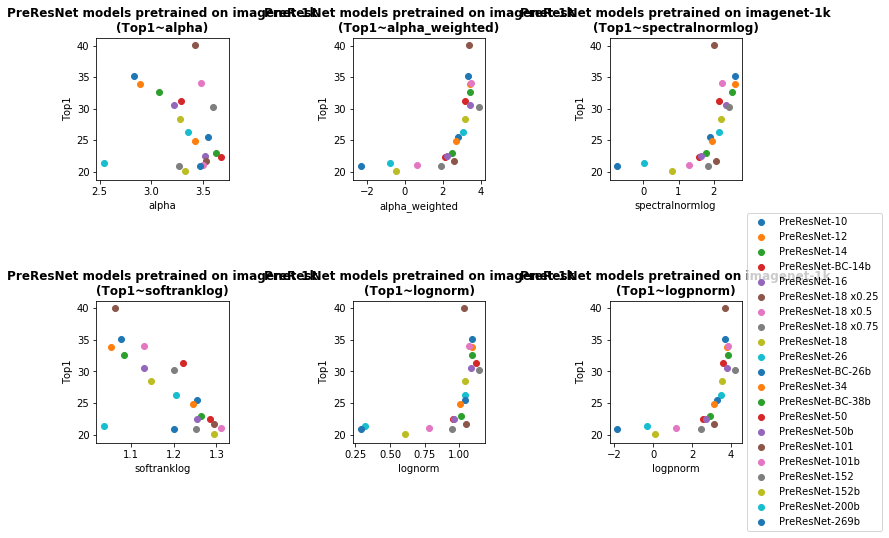

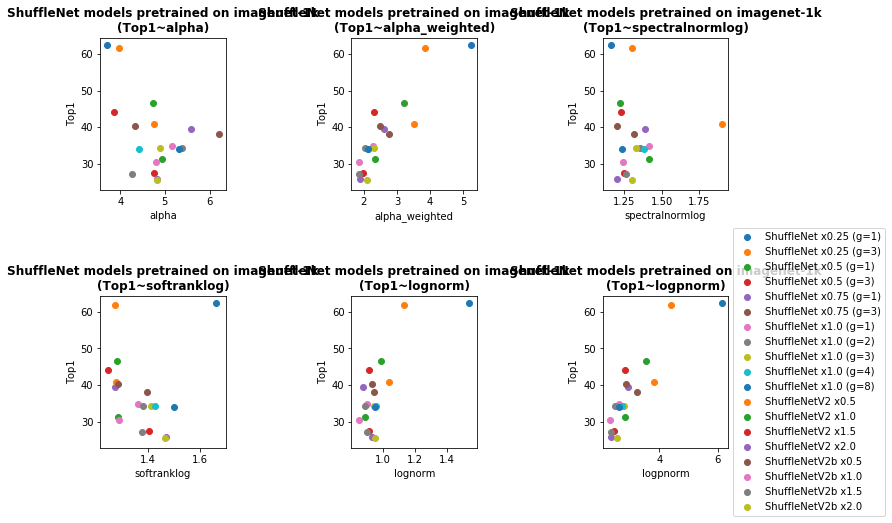

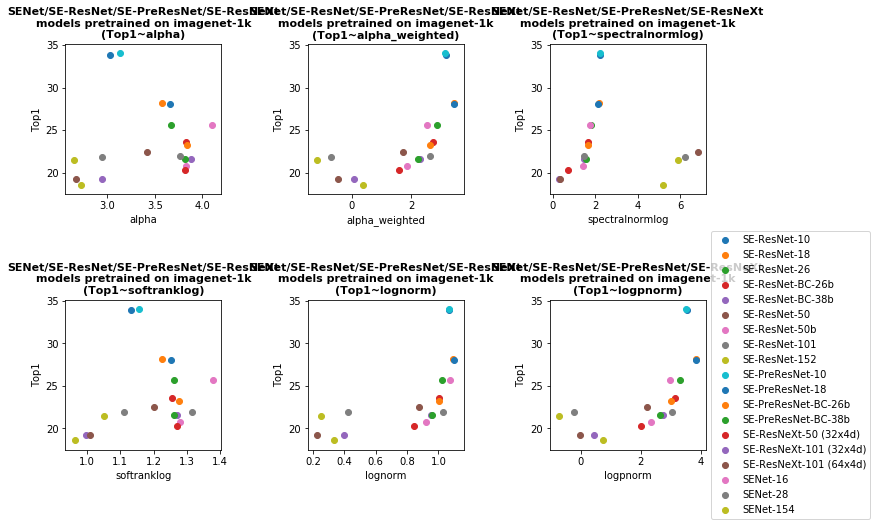

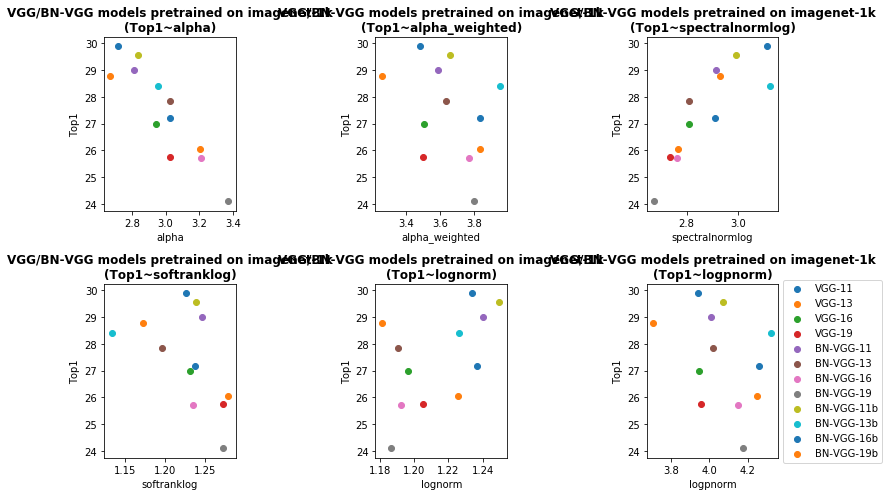

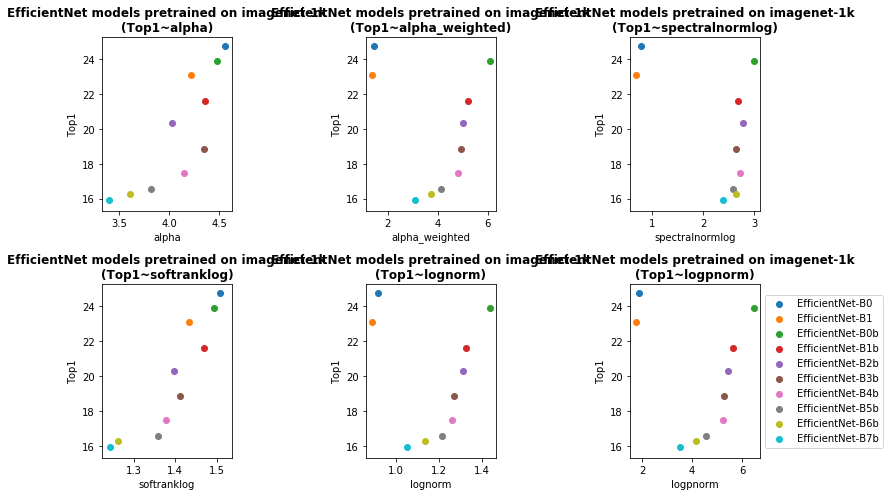

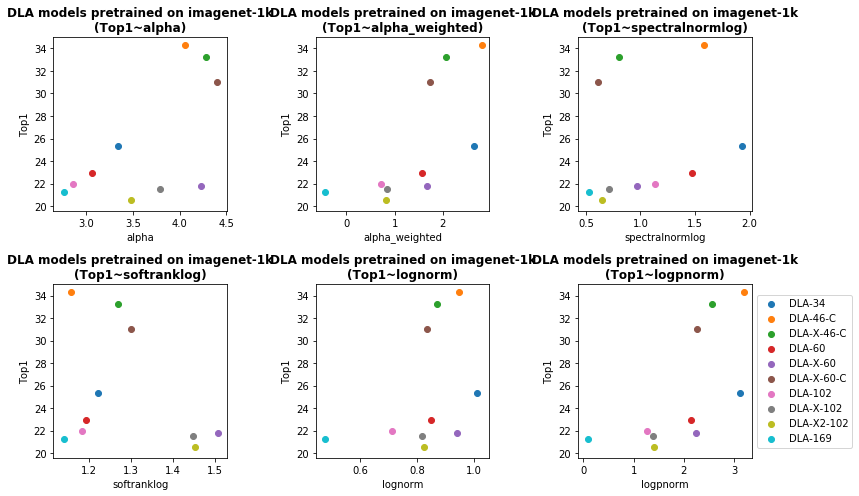

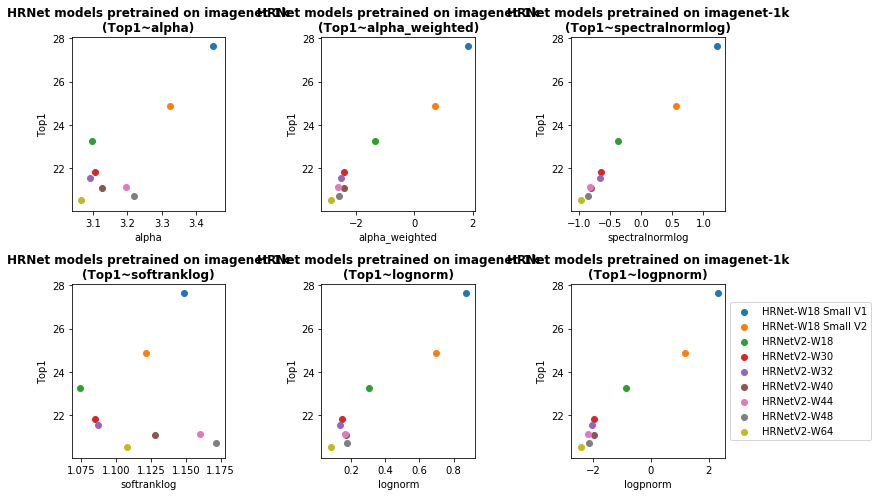

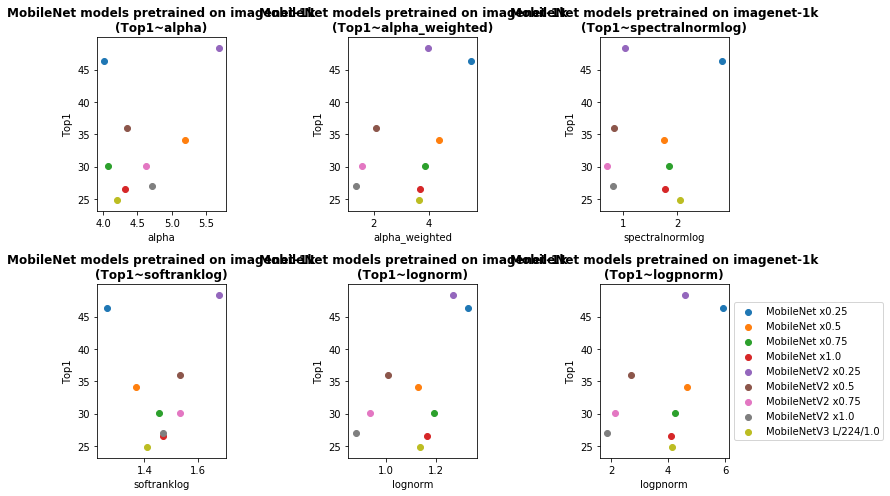

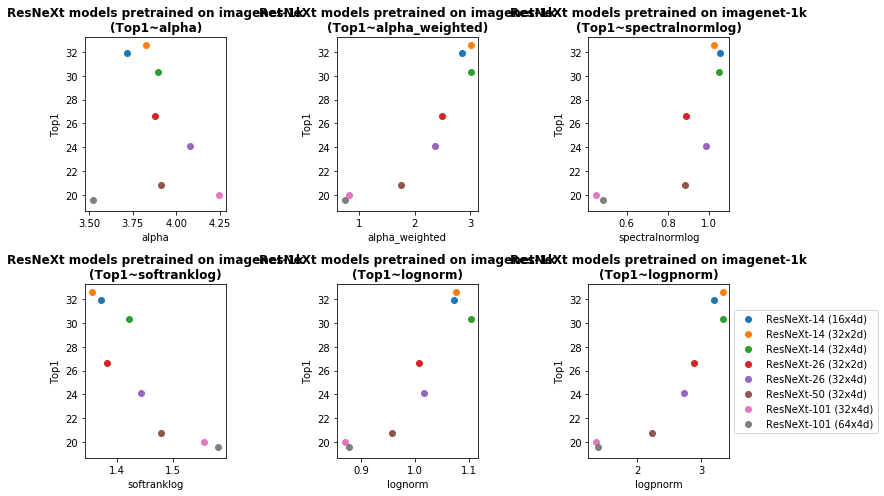

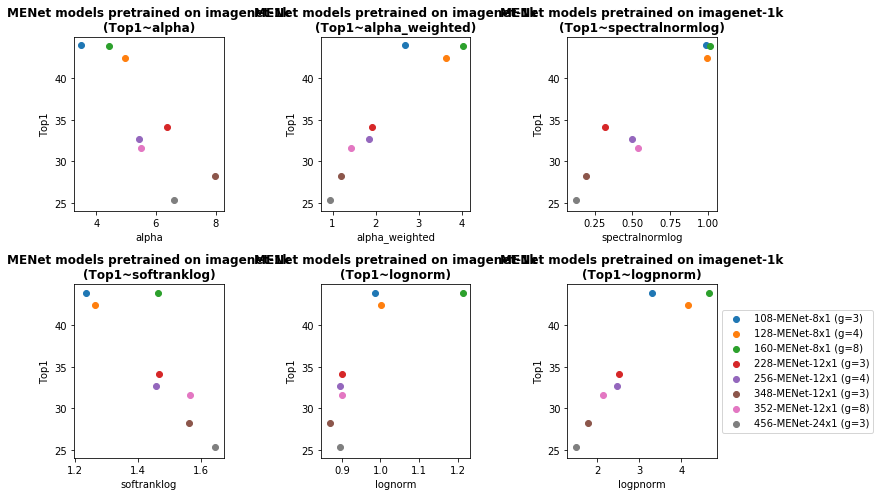

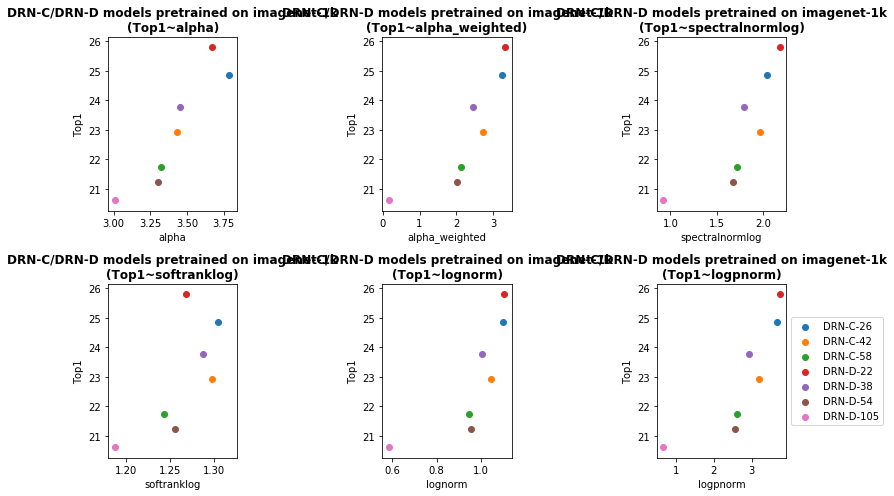

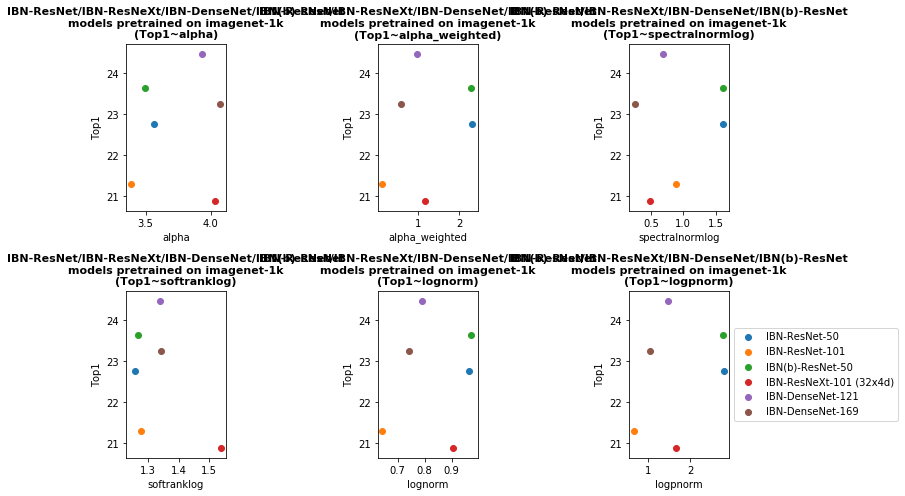

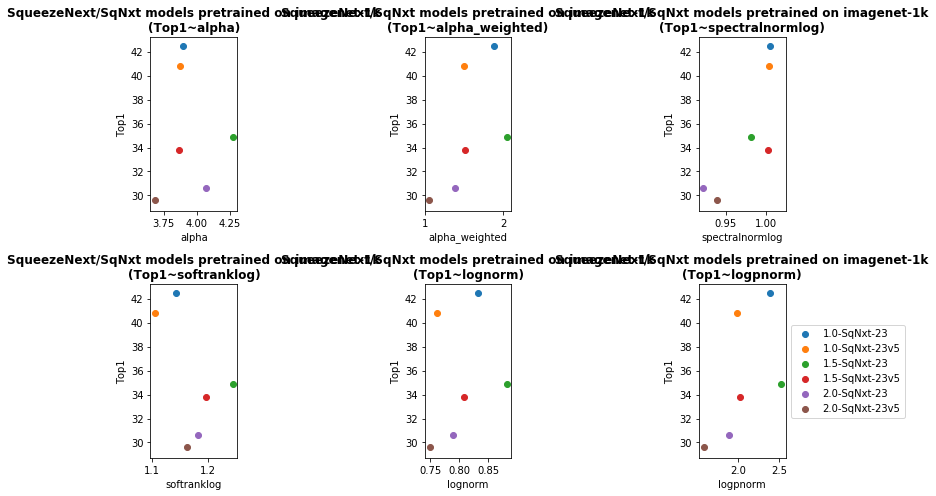

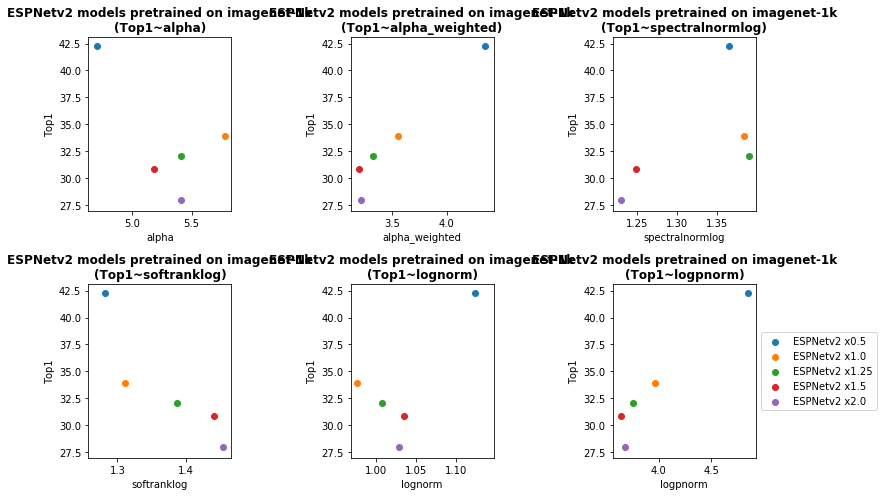

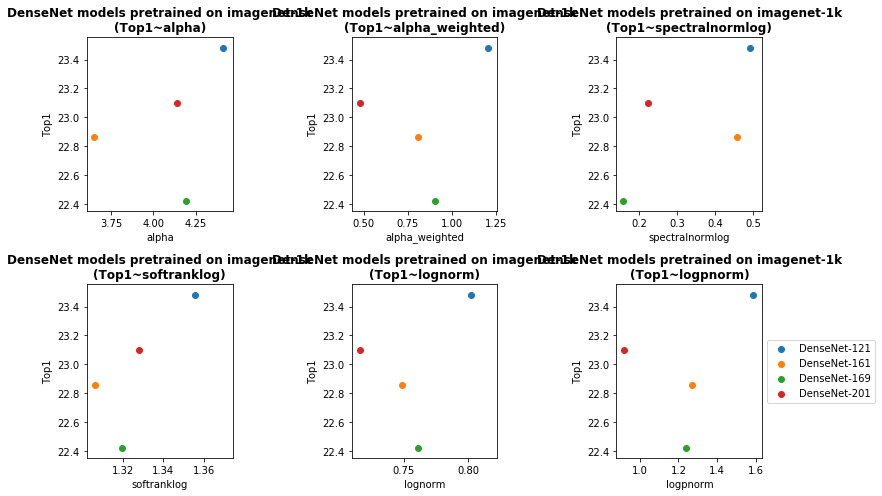

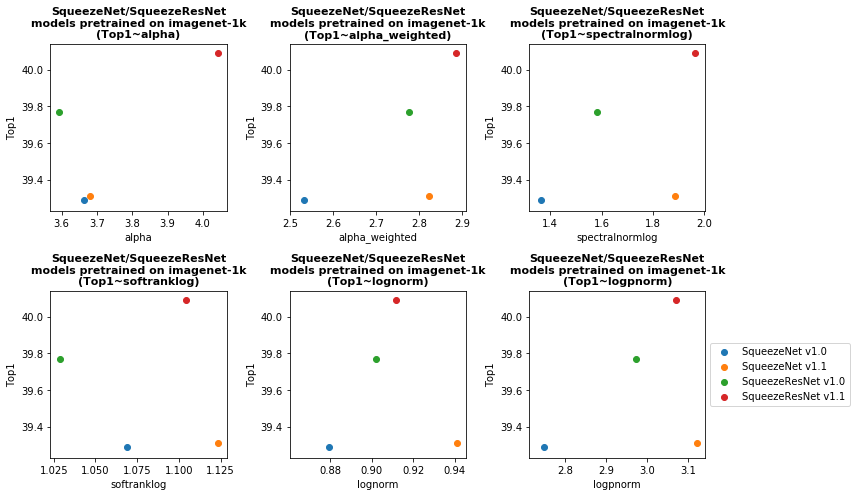

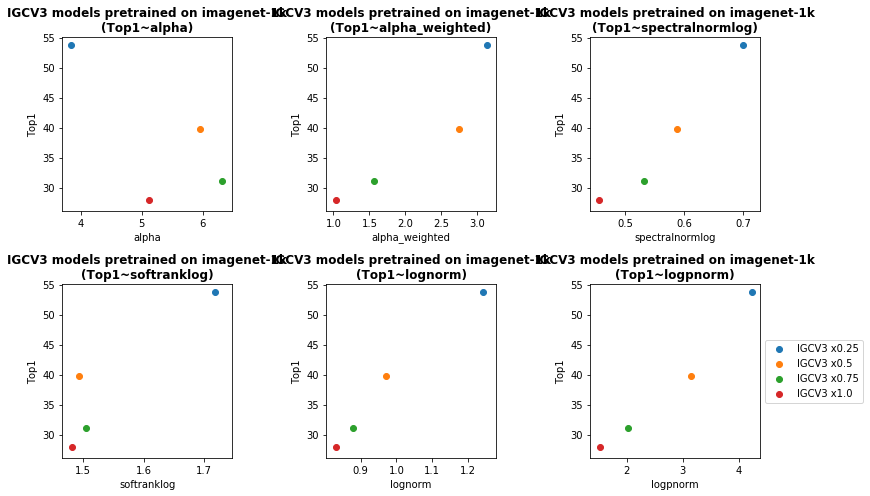

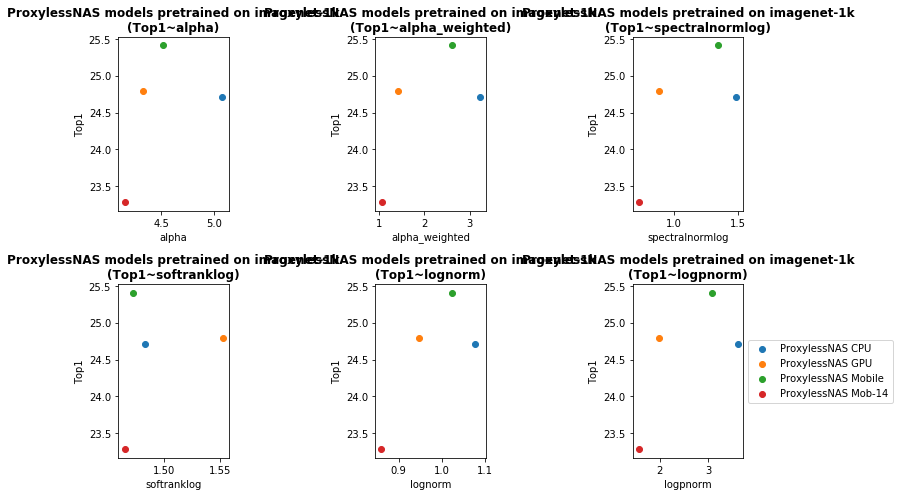

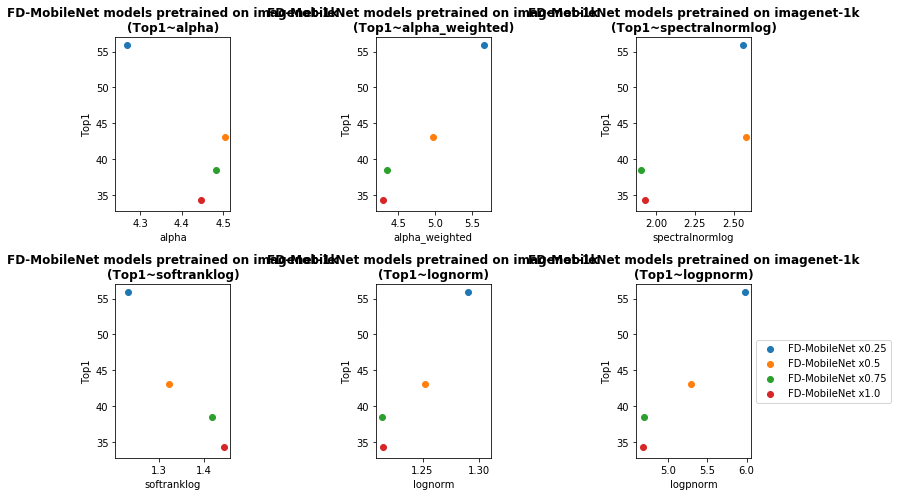

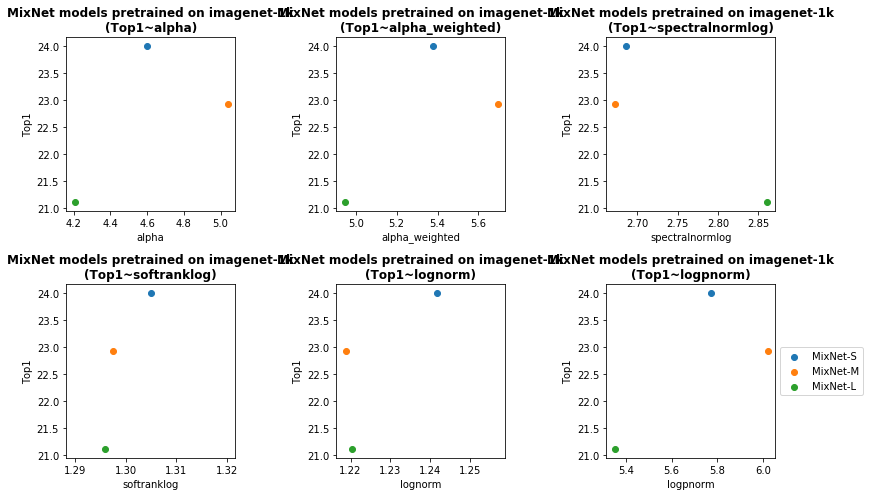

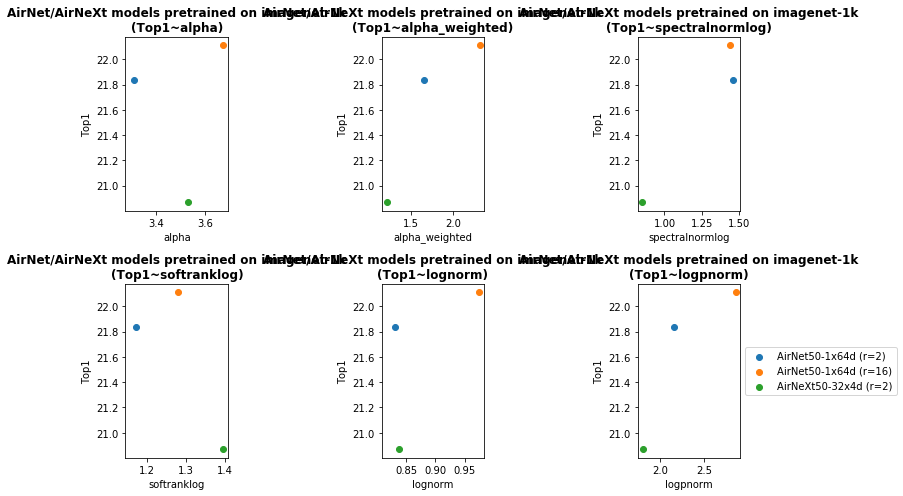

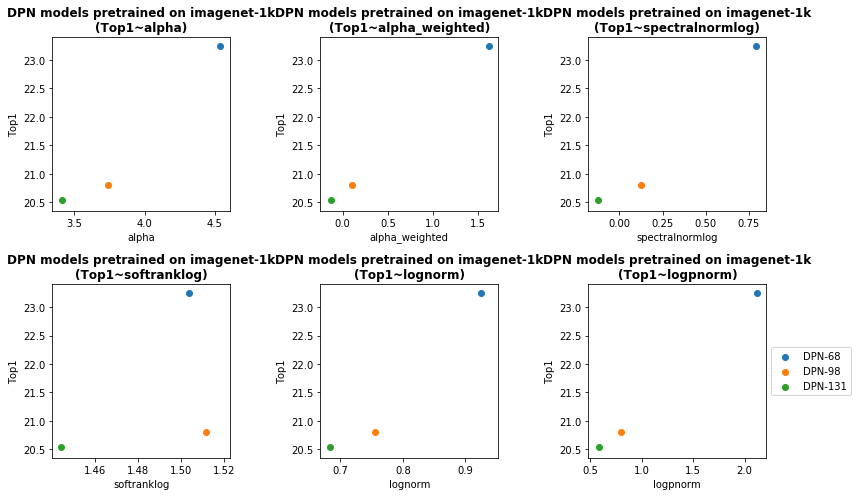

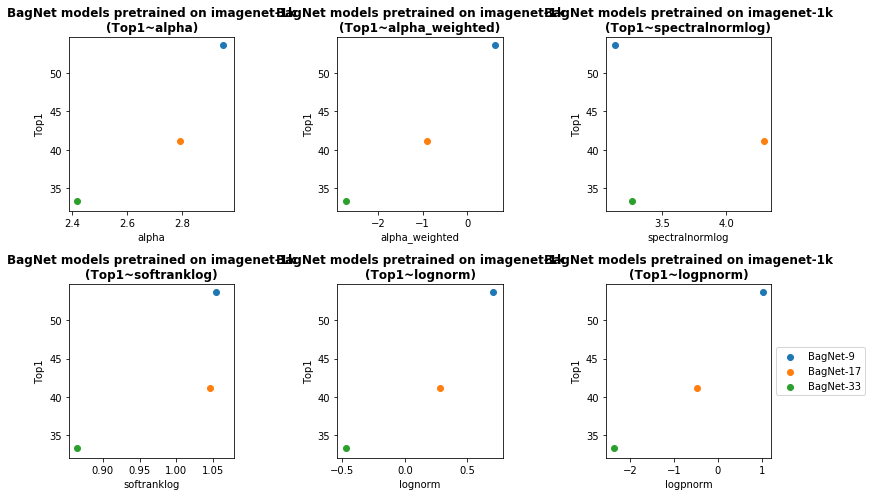

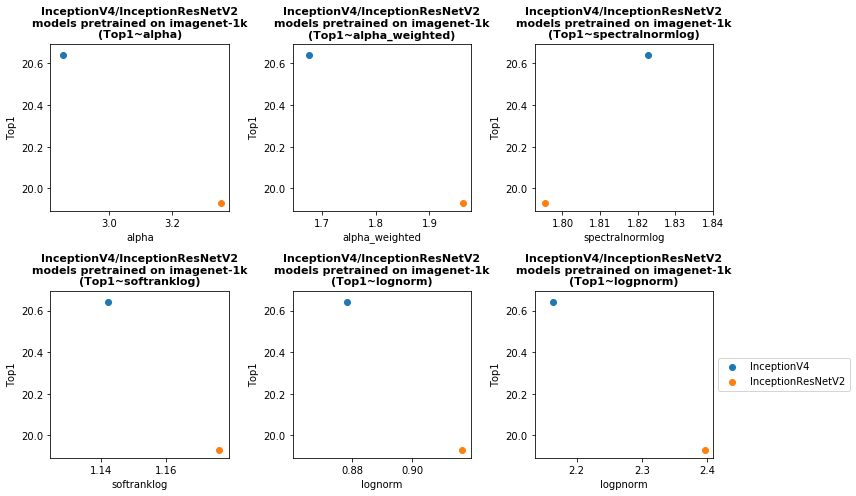

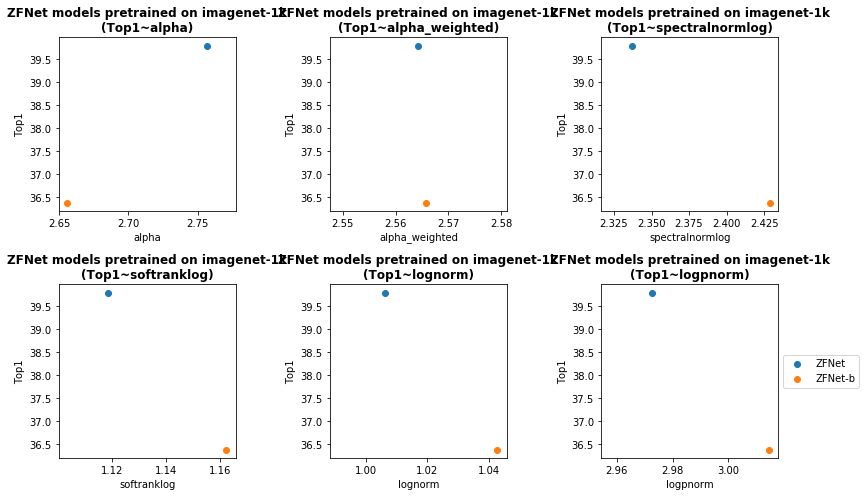

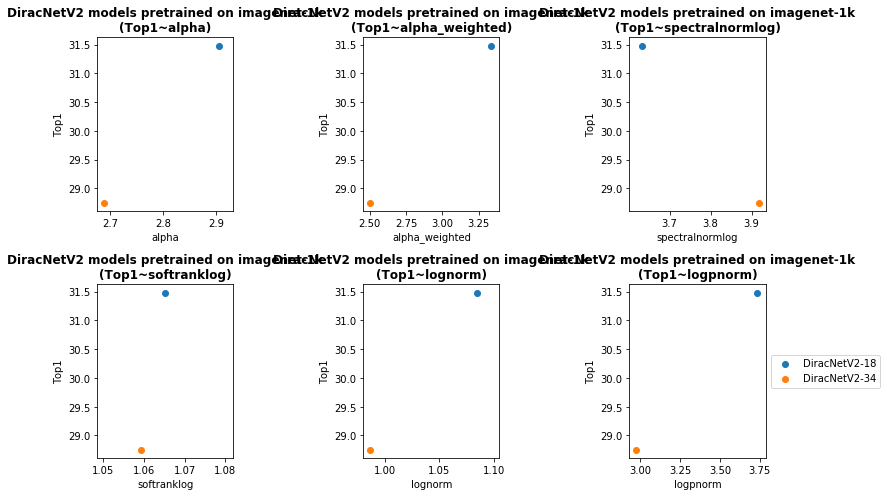

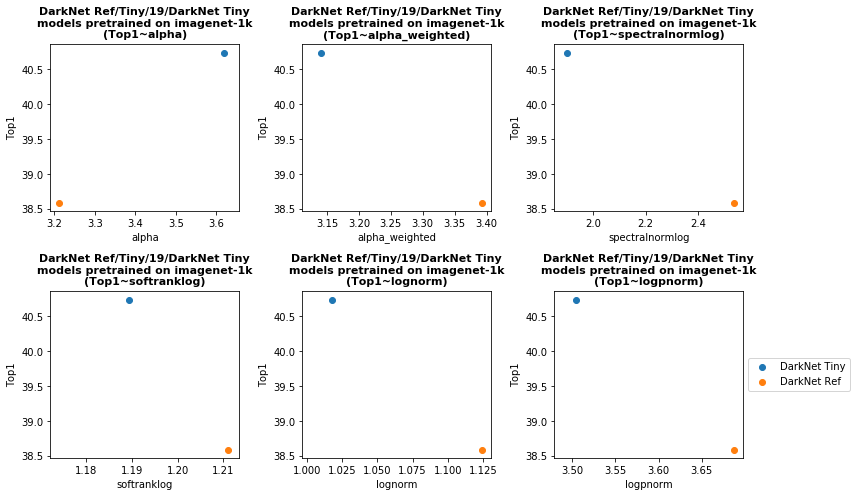

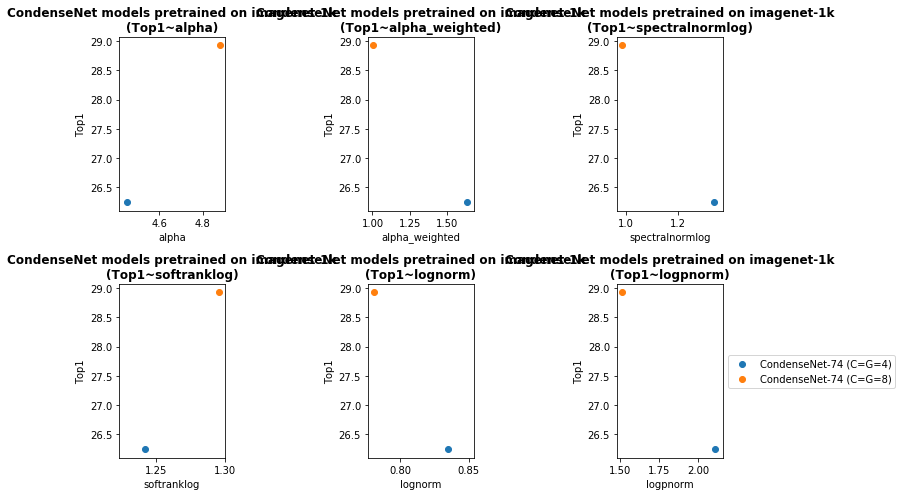

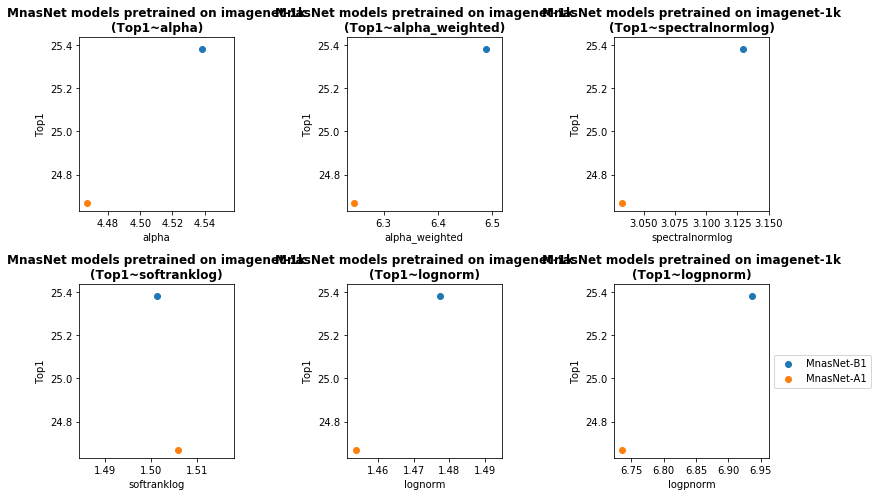

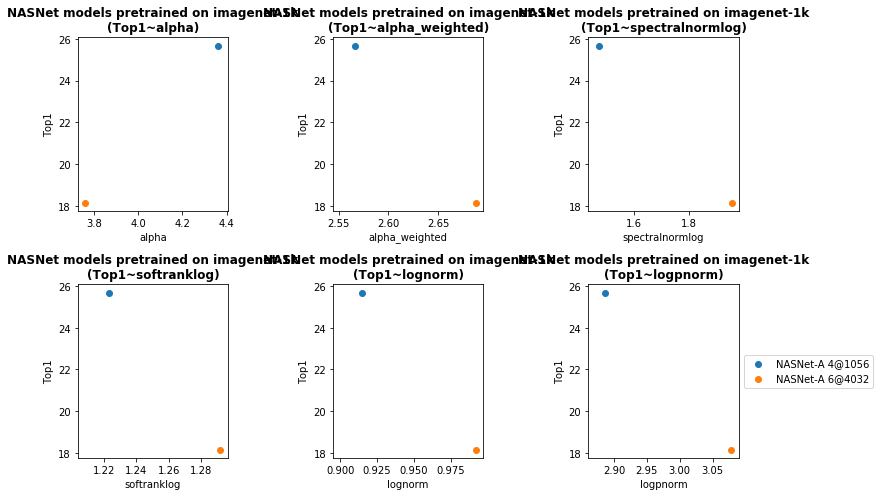

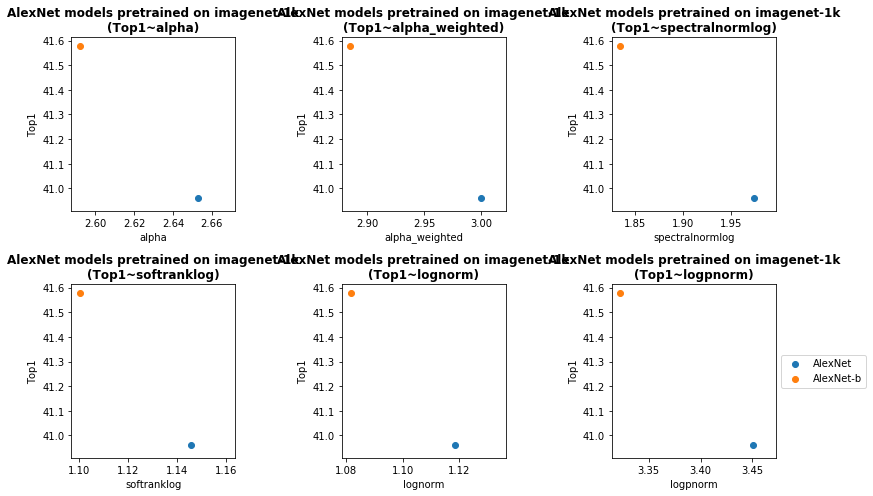

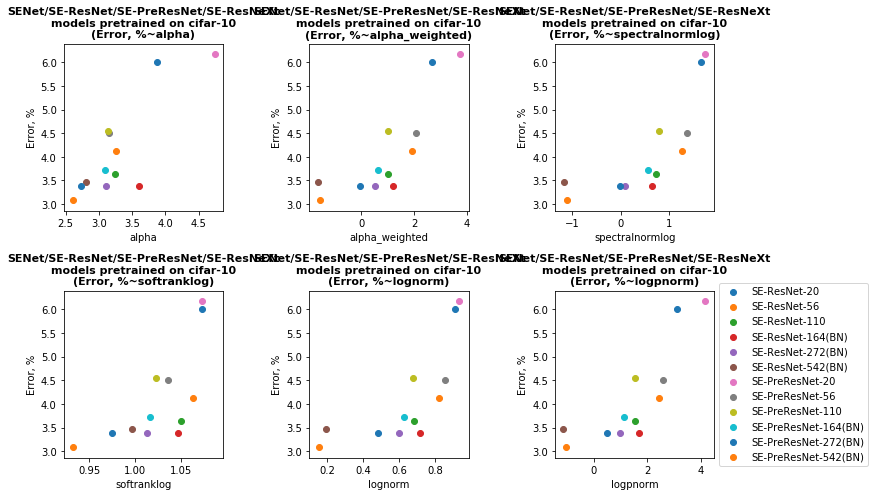

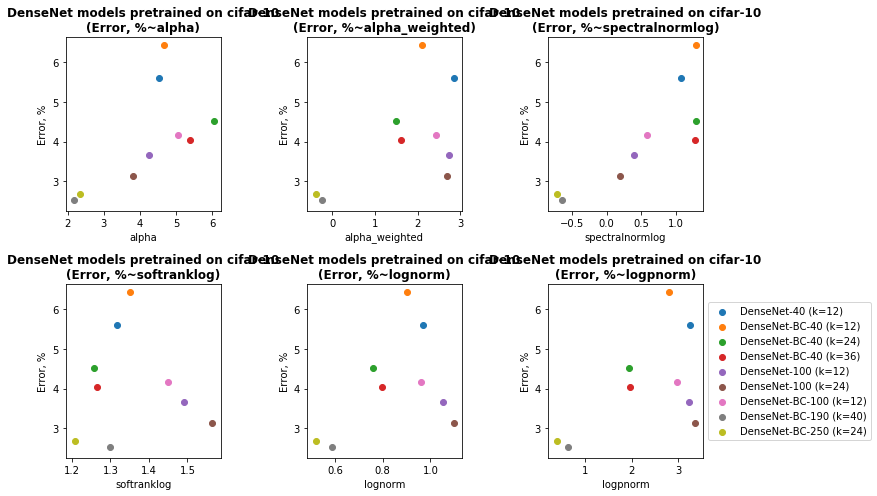

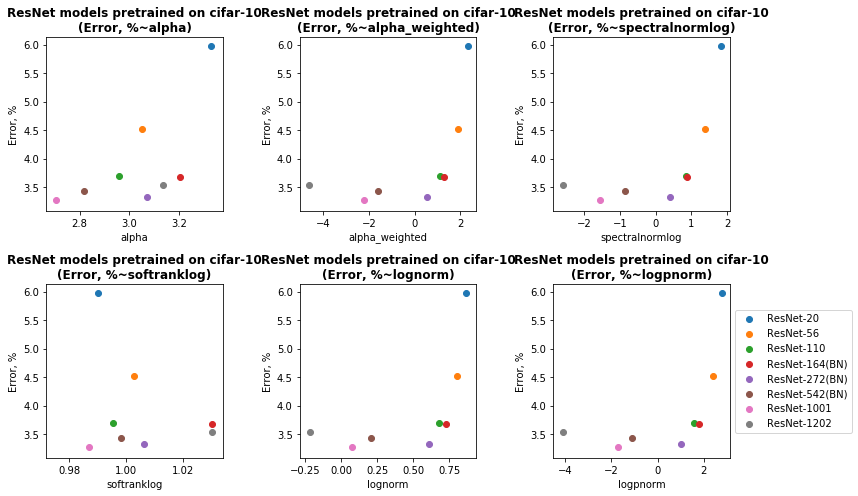

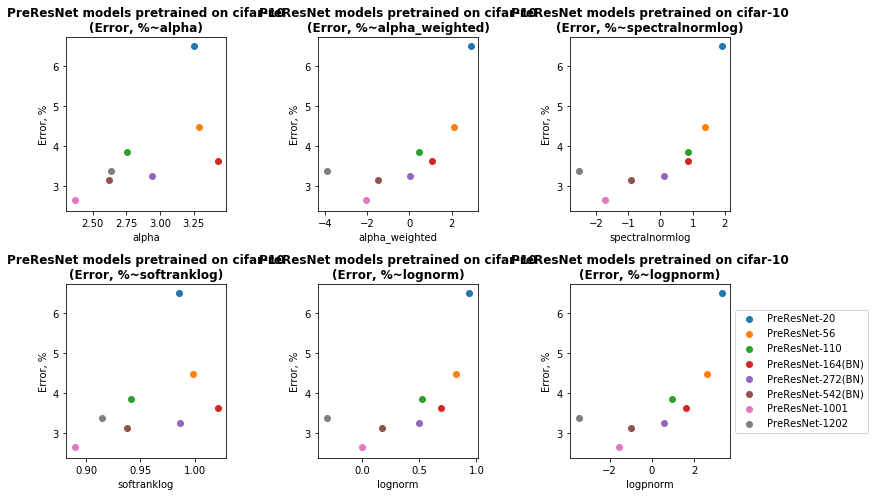

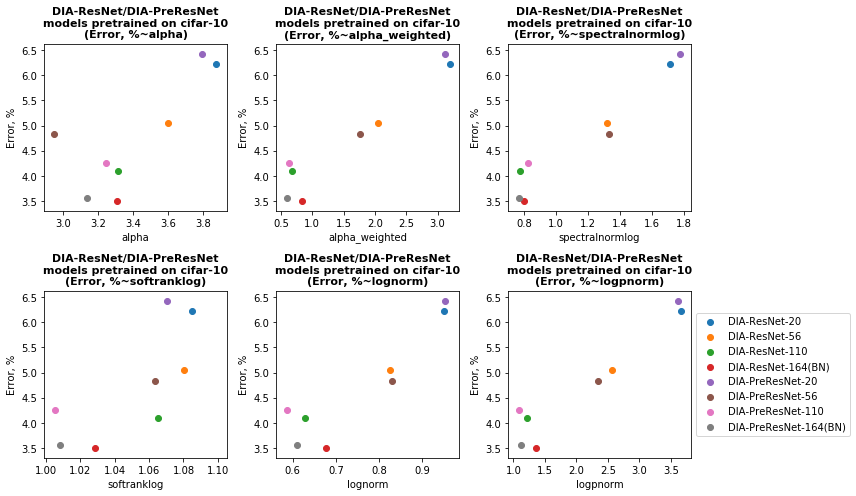

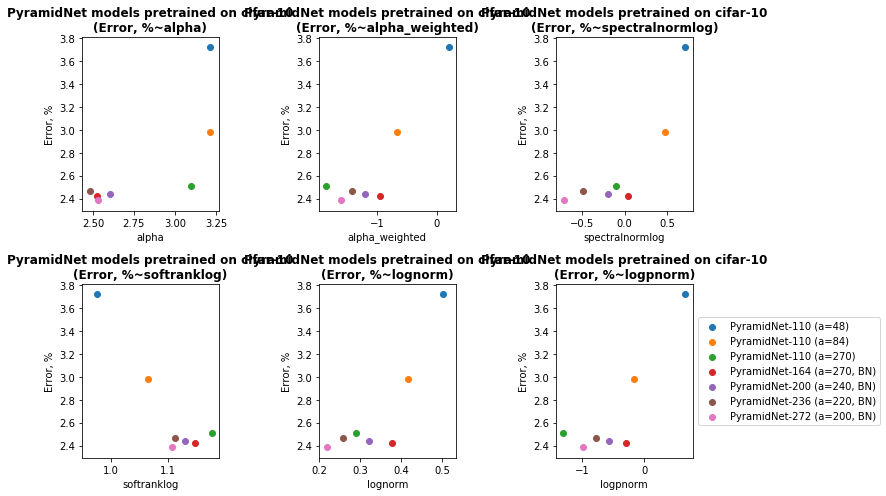

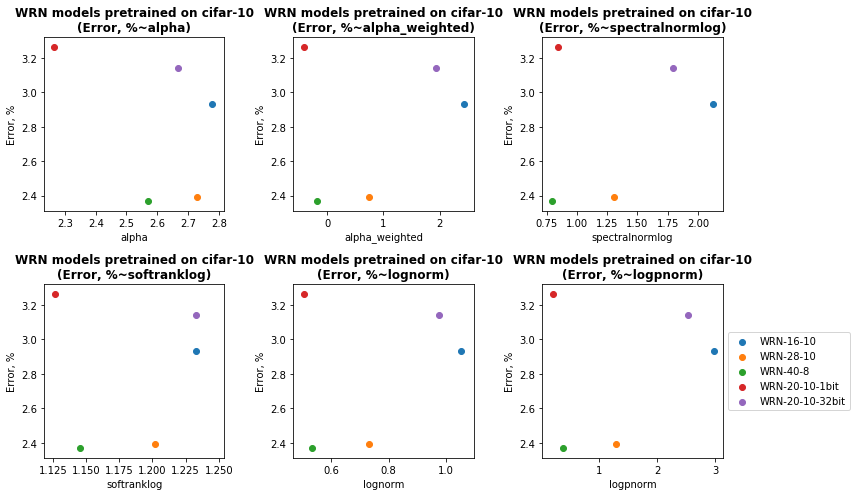

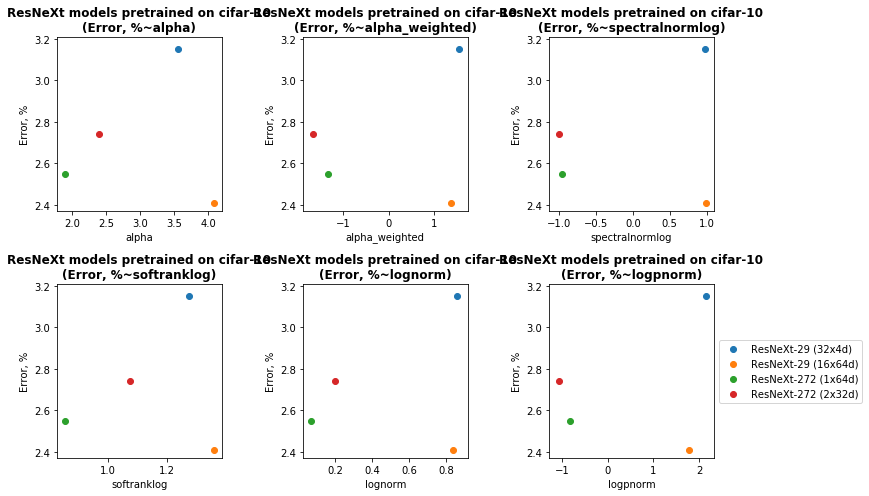

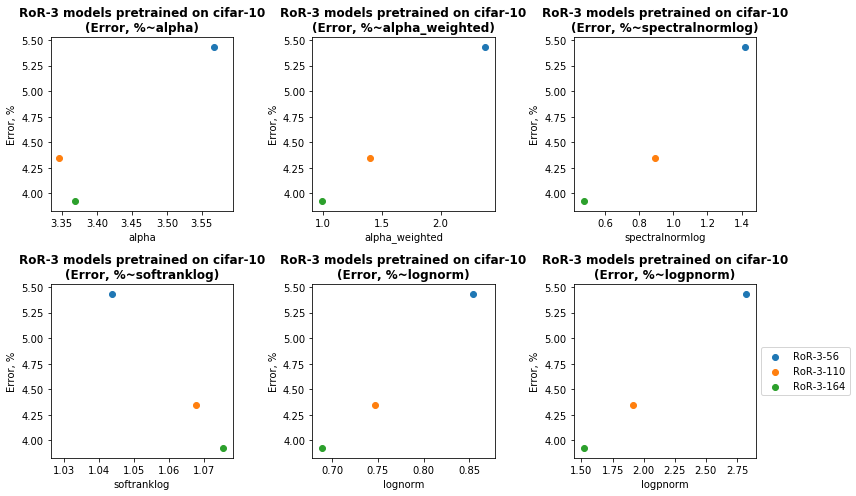

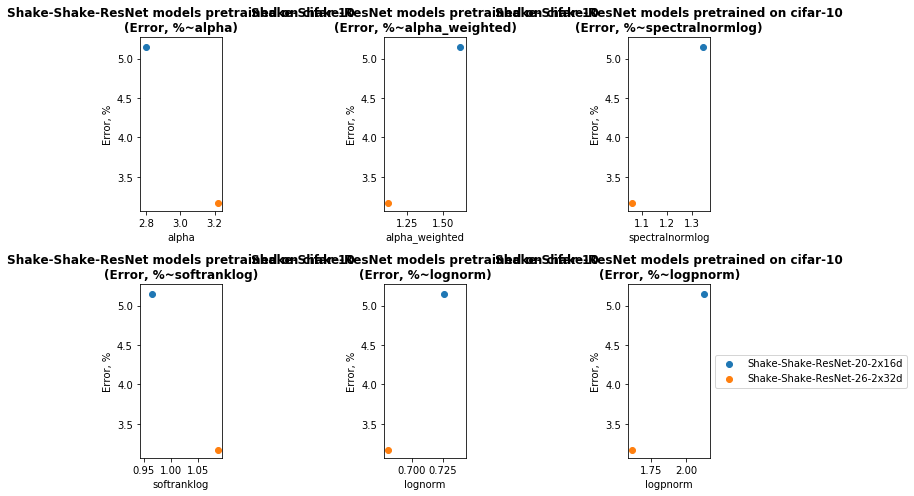

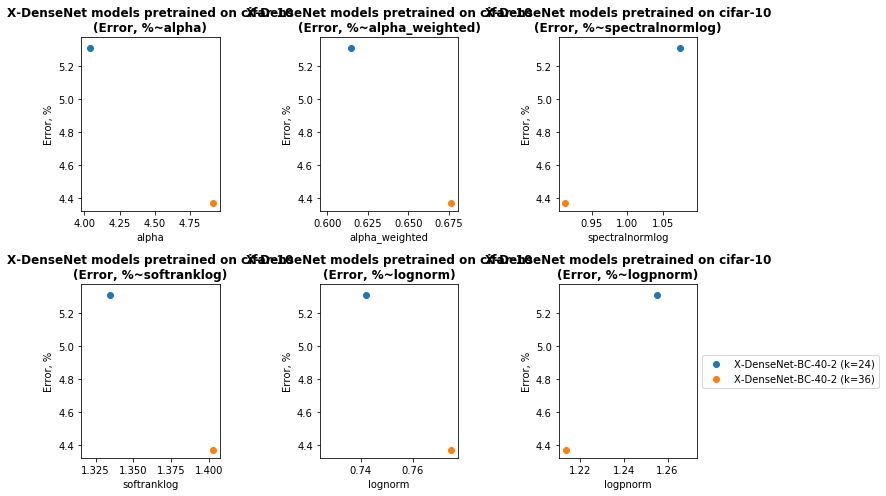

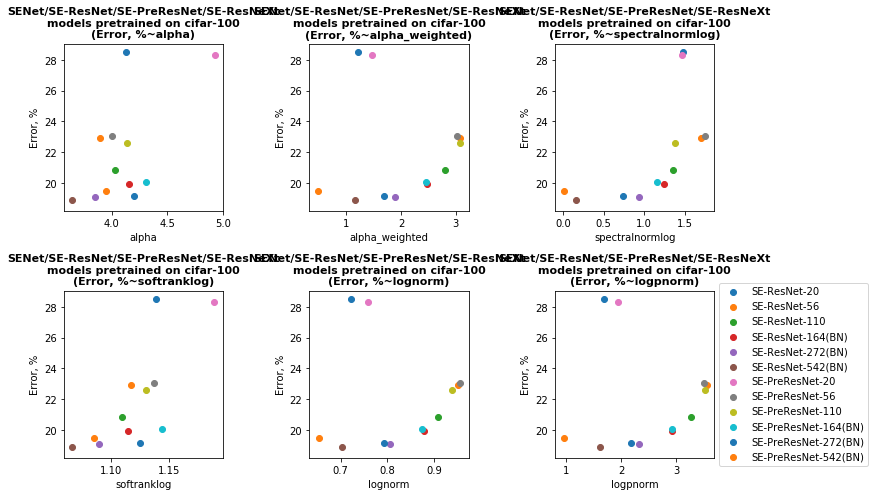

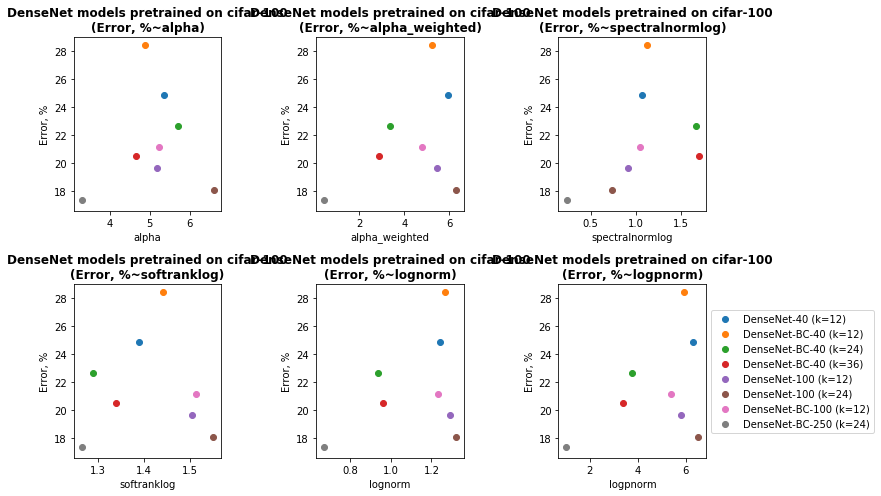

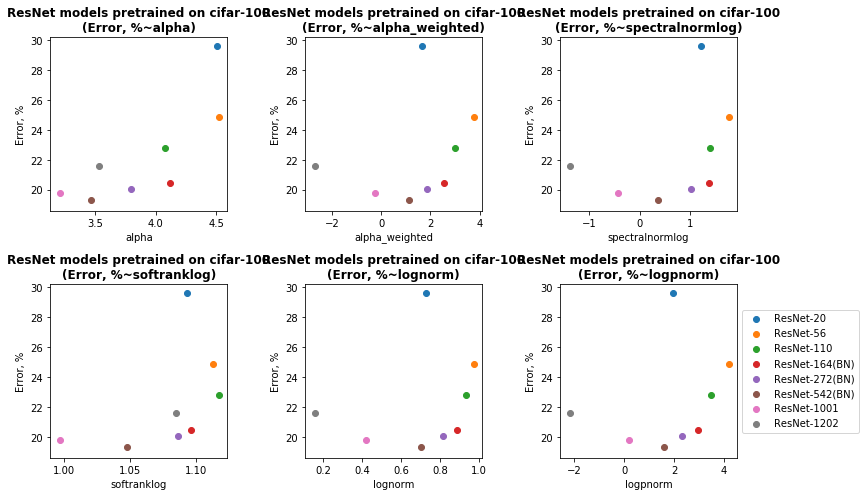

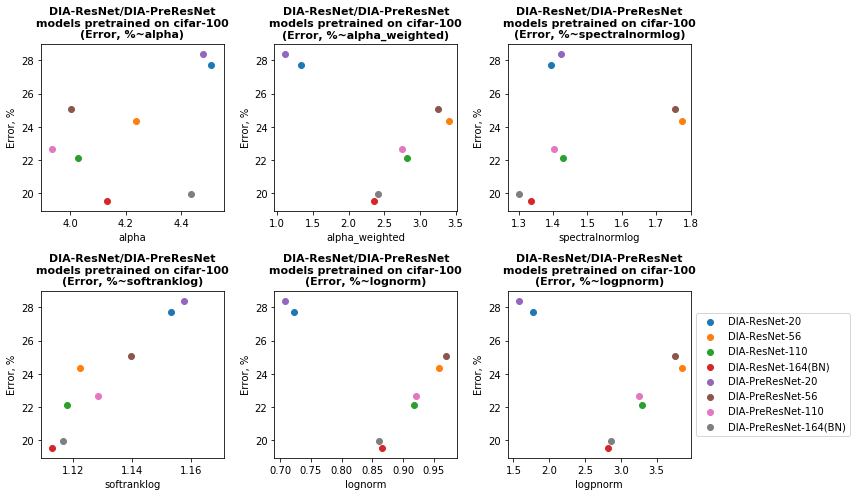

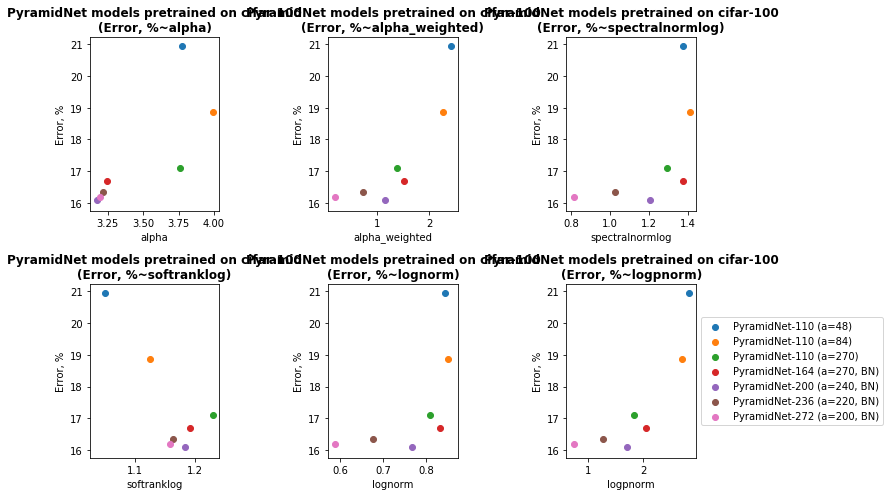

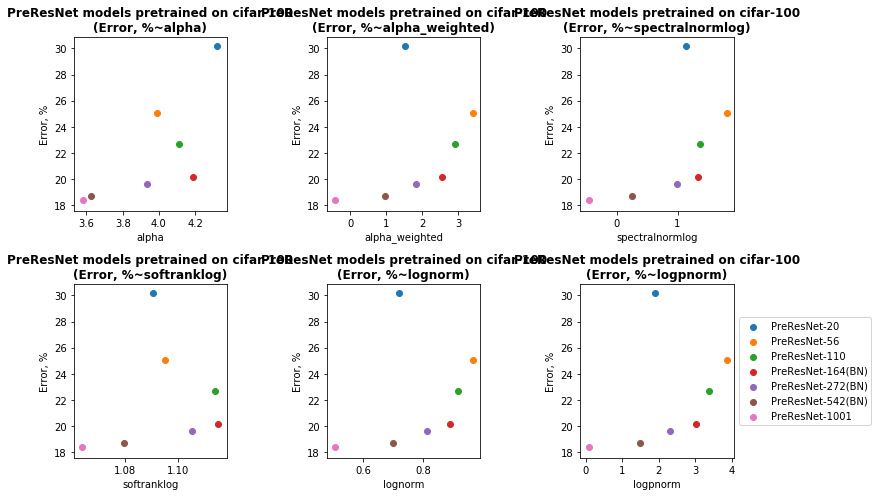

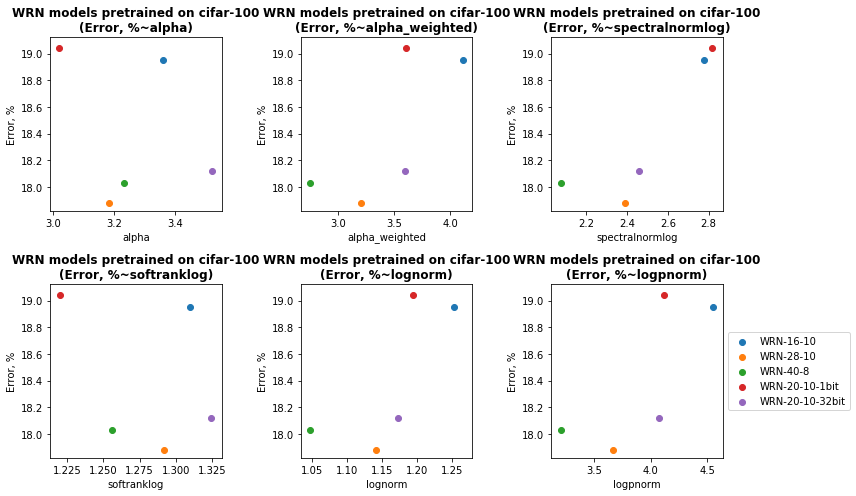

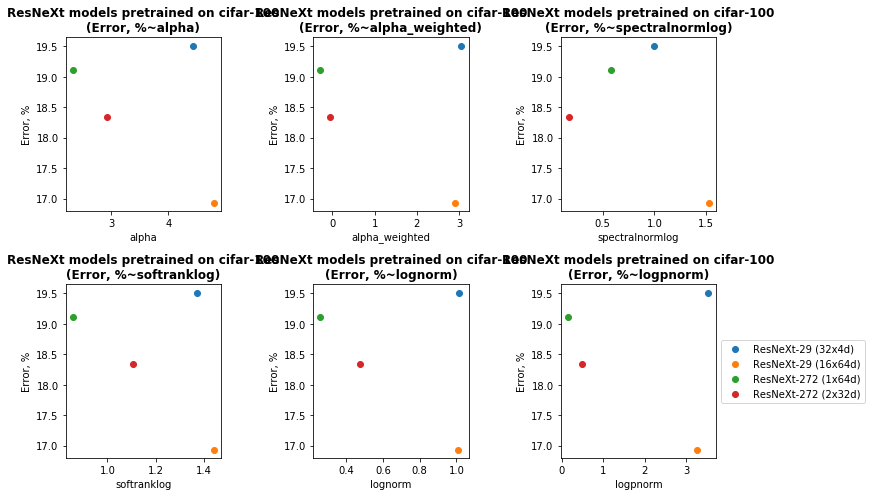

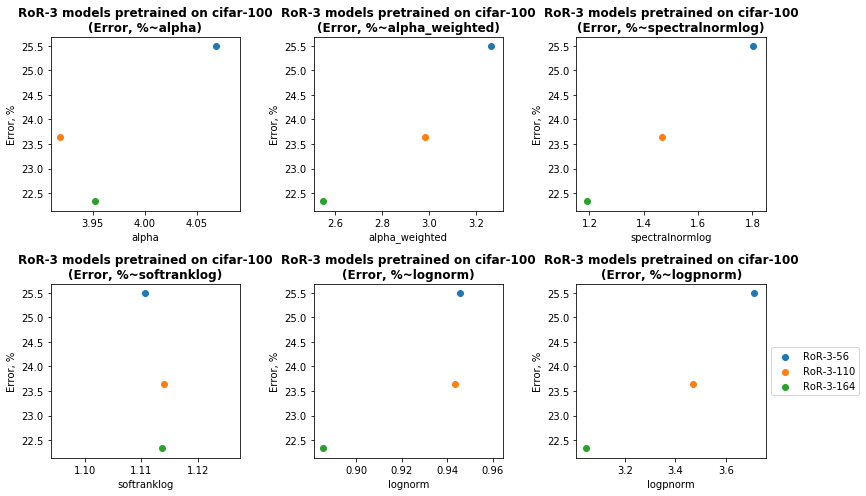

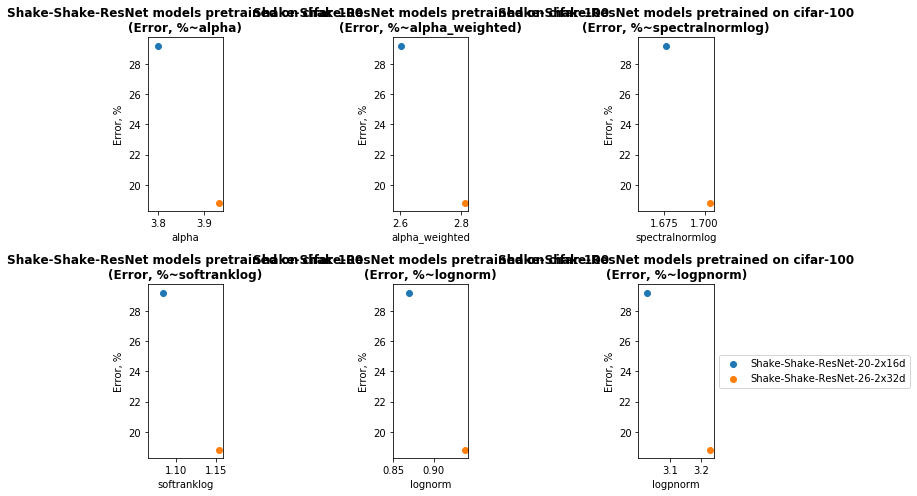

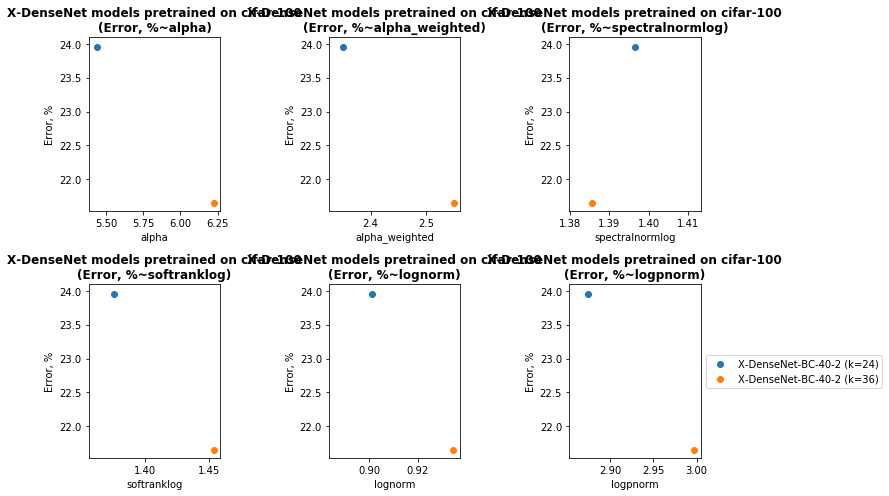

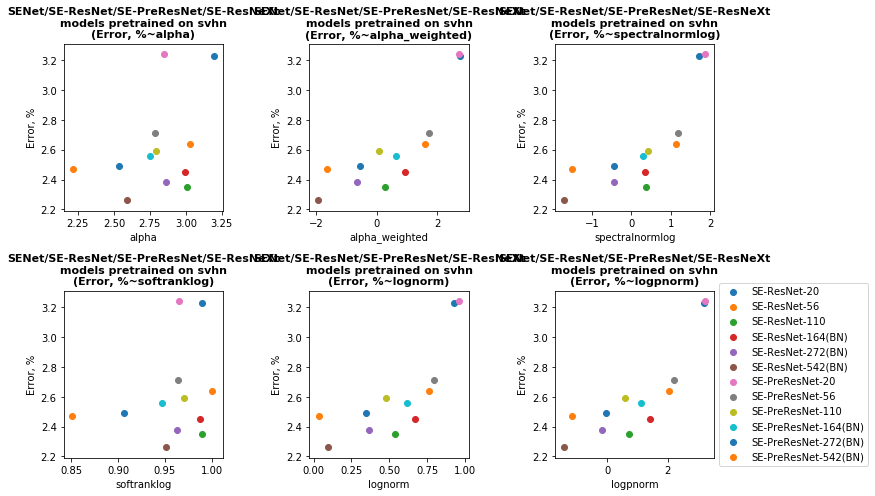

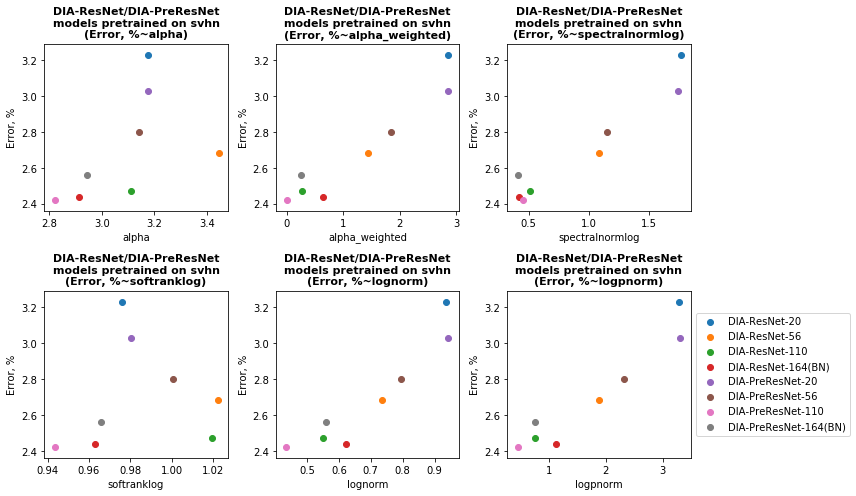

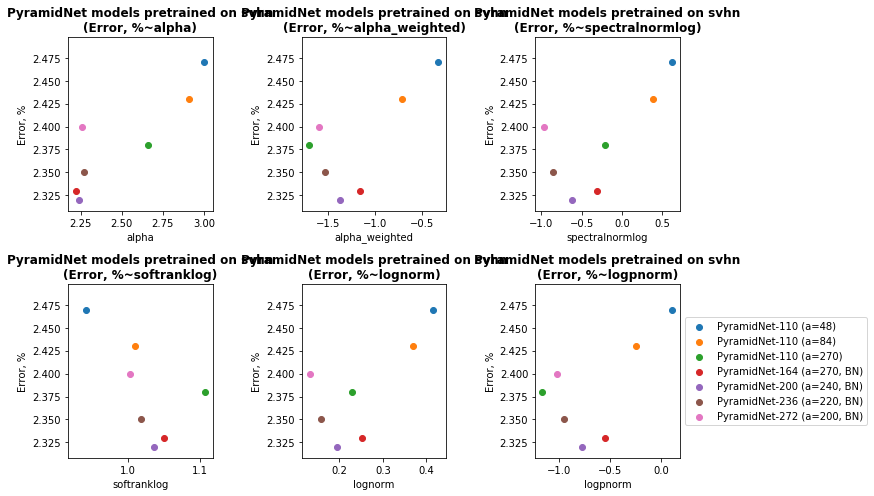

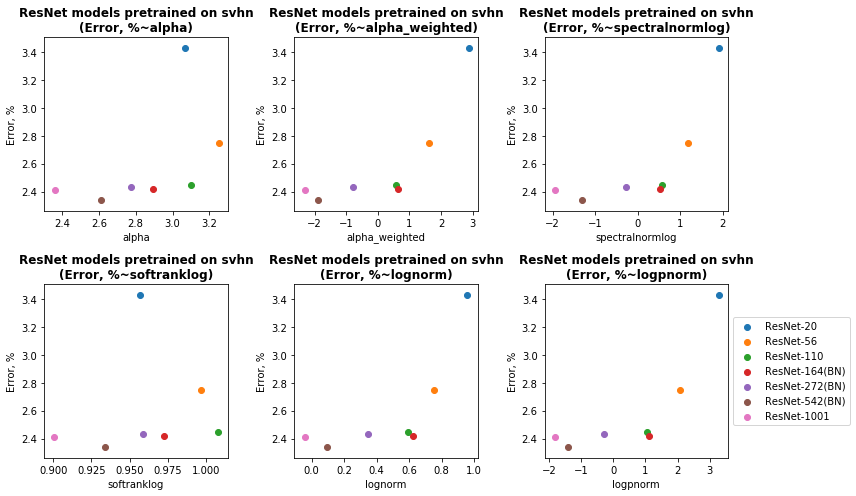

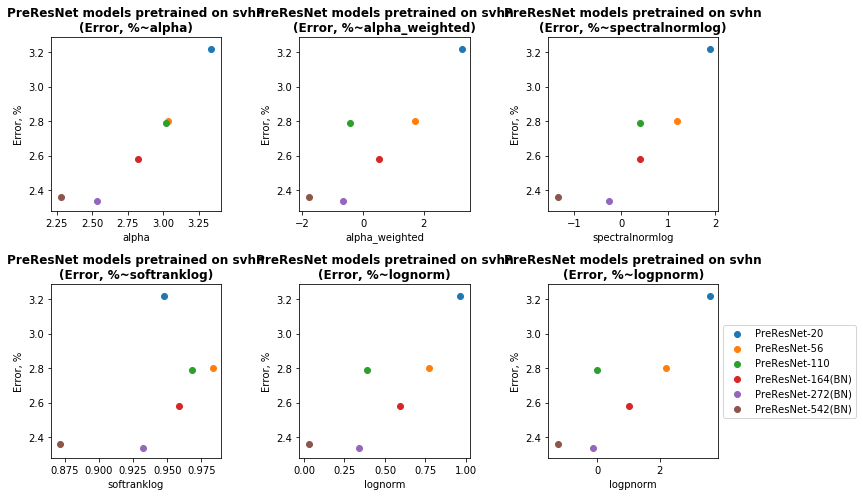

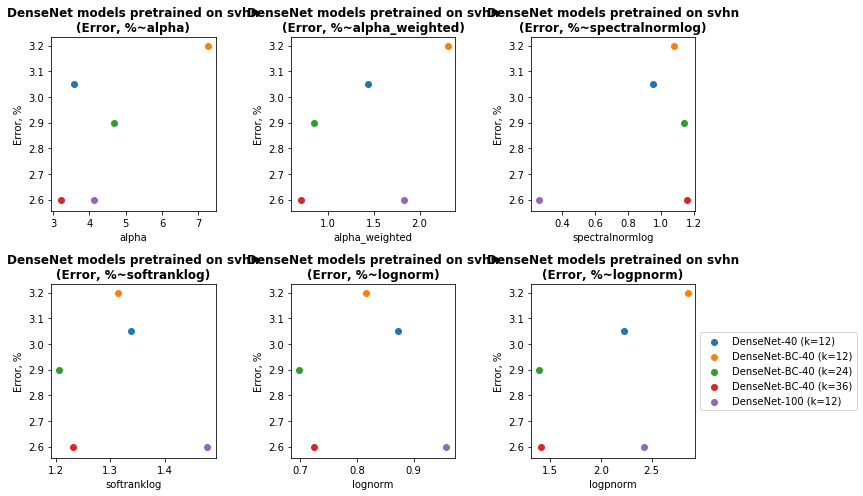

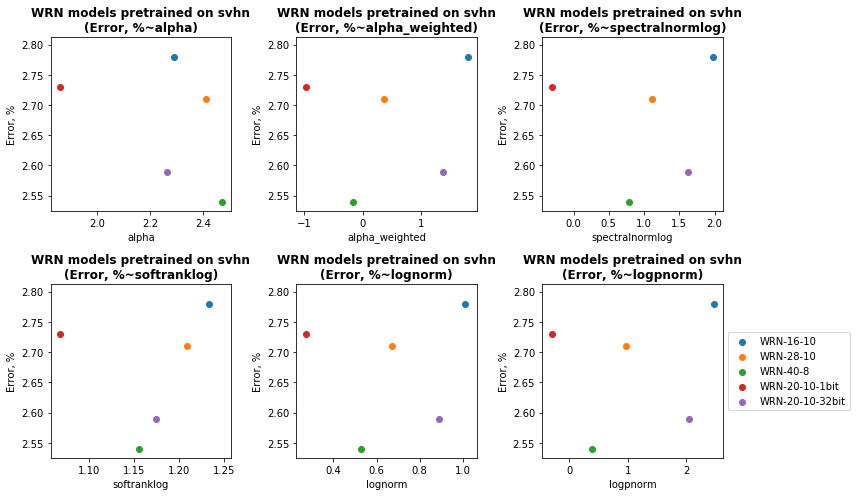

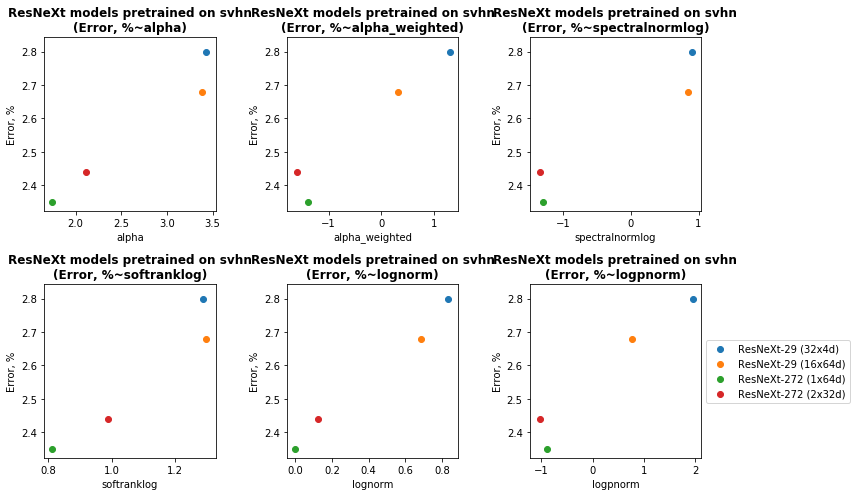

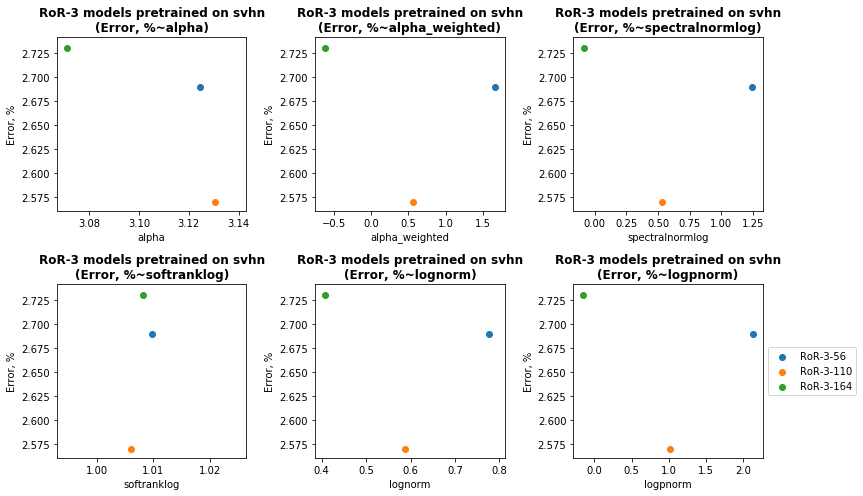

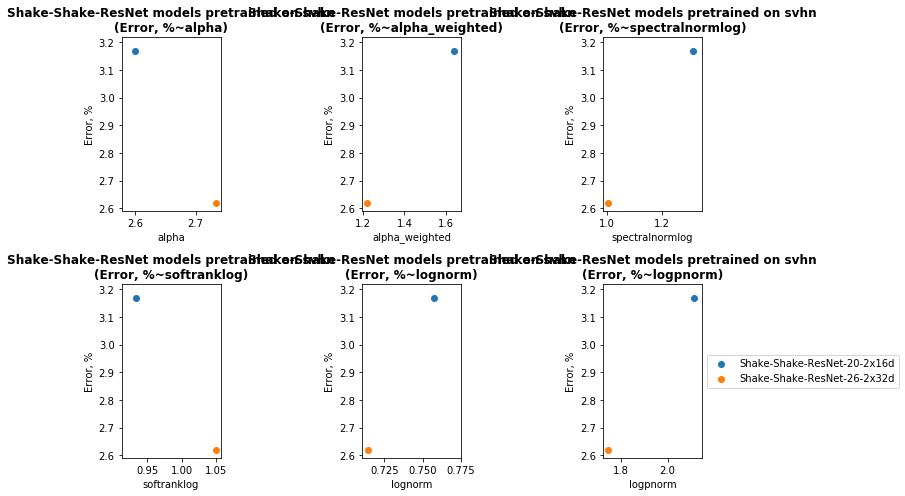

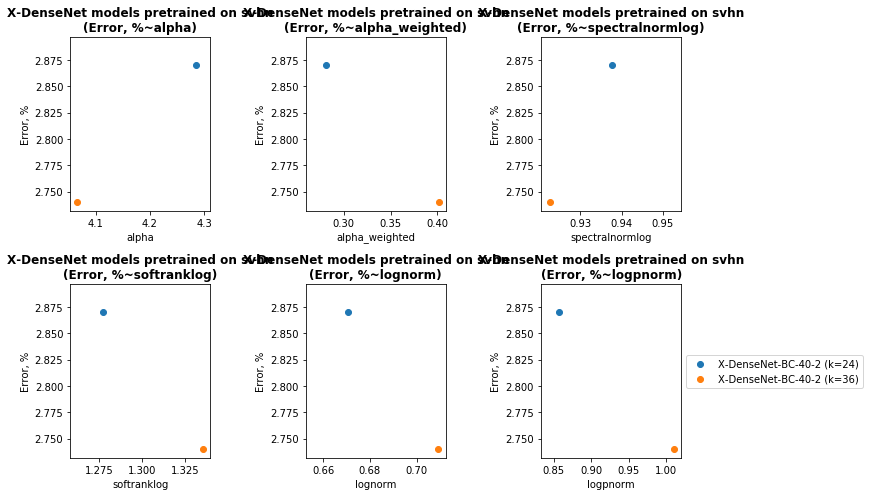

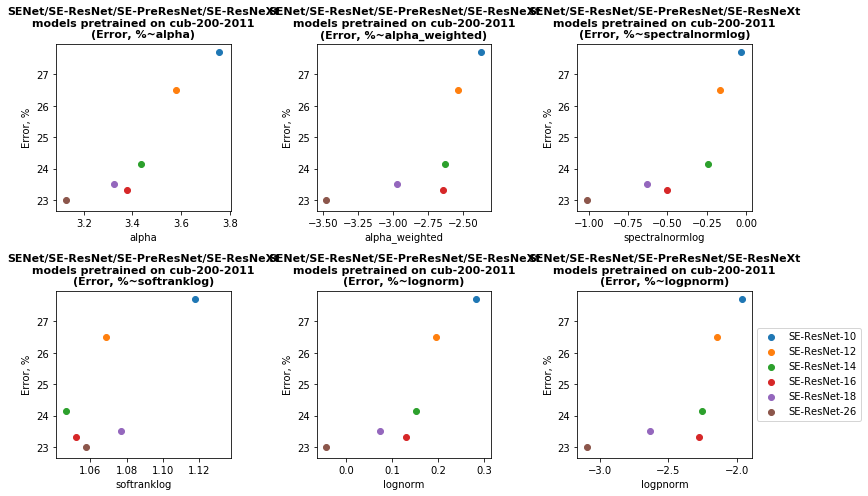

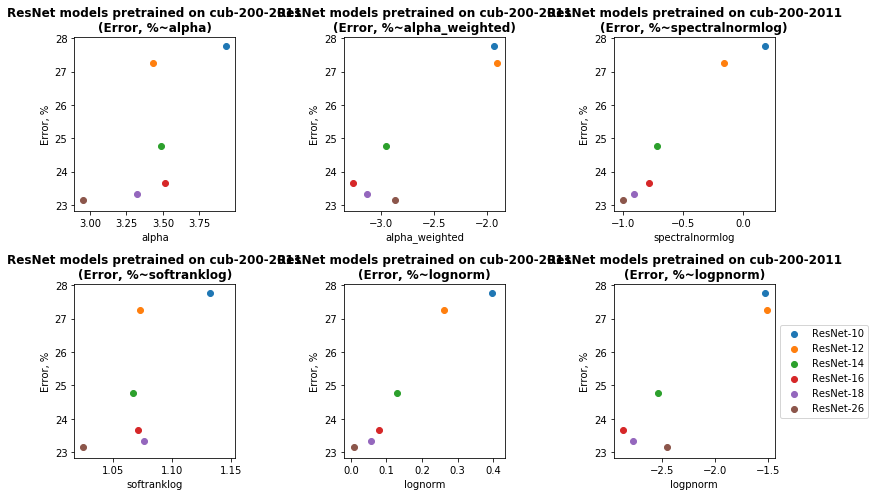

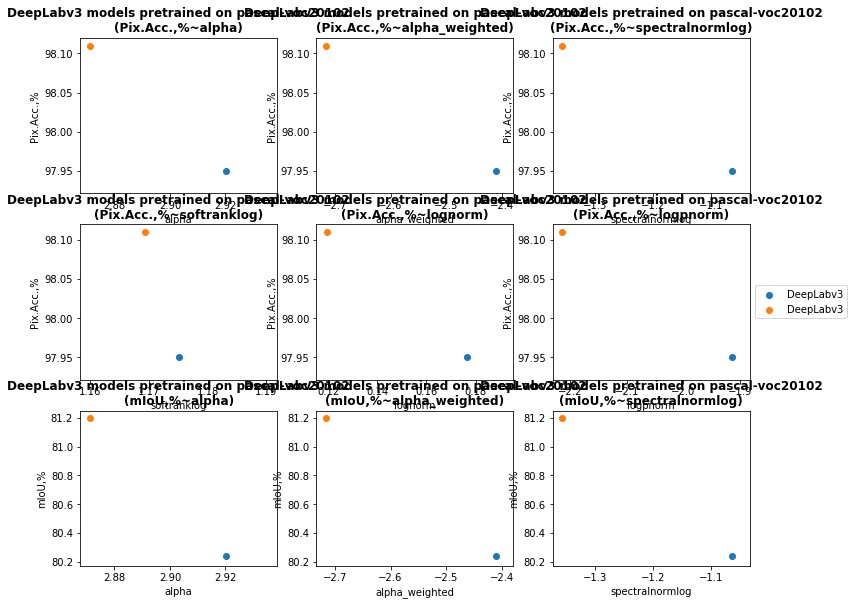

In [0]:
'''Plotting by architectures within each datasets'''
groups = df_table['group'].value_counts().to_frame()

for d in datasets:
    df = df_full[d].copy()
    this_groups = df['group'].value_counts().to_frame()

    for g in this_groups[this_groups['group'] > 1].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.reset_index(drop = True)

        tacc = [c for c in metrics_acc if c in this_group.columns]

        plotloc = int(len(tacc)*len(metrics)/num_rows*100 + 10*num_cols + 1)

        if len(tacc) > 1:
            plt.figure(figsize = (12,20))
        else:
            plt.figure(figsize = (12,10))

        for ac in tacc:#metrics_acc:
            for x in metrics:
                plt.subplot(plotloc)
                for i in range(len(this_group)):
                    plt.scatter(this_group.loc[i,x], this_group.loc[i, ac])
                plt.xlabel(x)
                plt.ylabel(ac)
                if len(g) > 20: #to avoid overlap in title
                    plt.title('{}\nmodels pretrained on {}\n({}~{})'.format(g, d, ac, x), 
                              fontweight = 'bold', fontsize = 11)
                else:
                    plt.title('{} models pretrained on {}\n({}~{})'.format(g, d, ac, x), 
                              fontweight = 'bold')

                plotloc += 1

            plt.legend(this_group['Model'], loc='center left', 
                       bbox_to_anchor=(1, 0.5))          
        plt.tight_layout()

del this_groups
del this_group

# Fit a linear regression on to the graphs from above


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ValueError: ignored

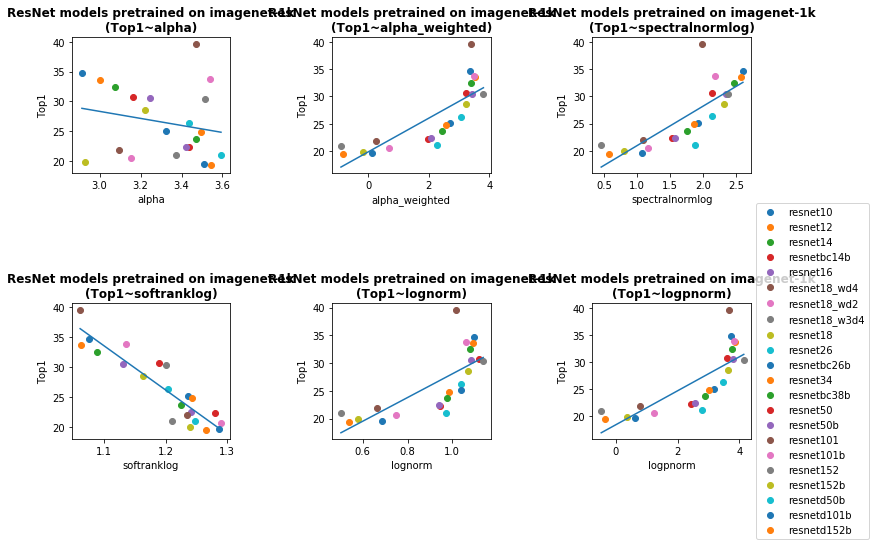

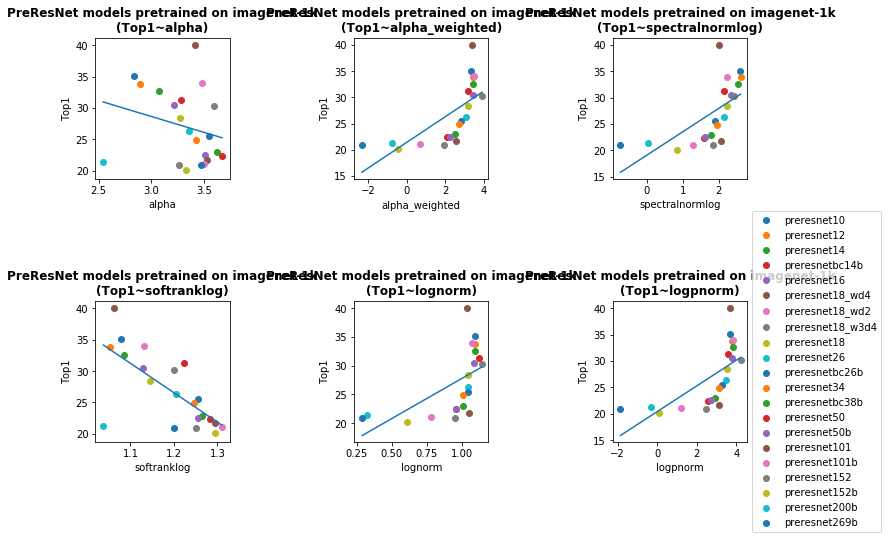

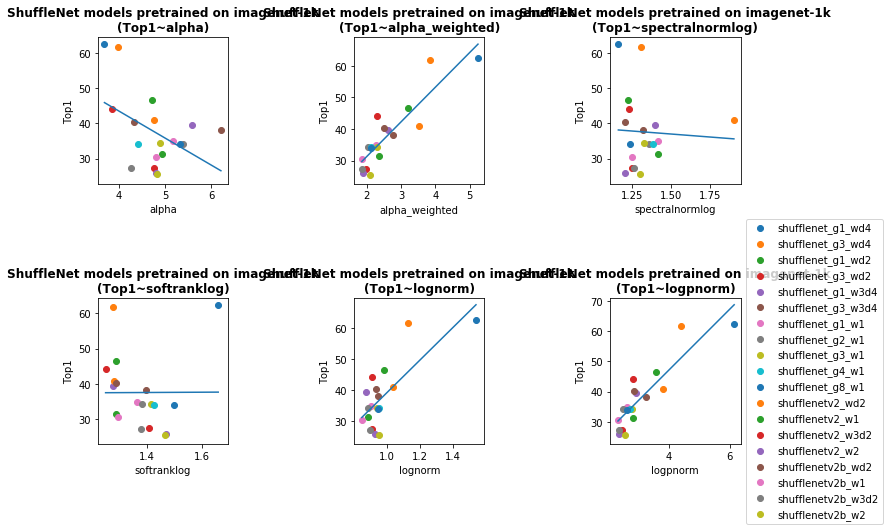

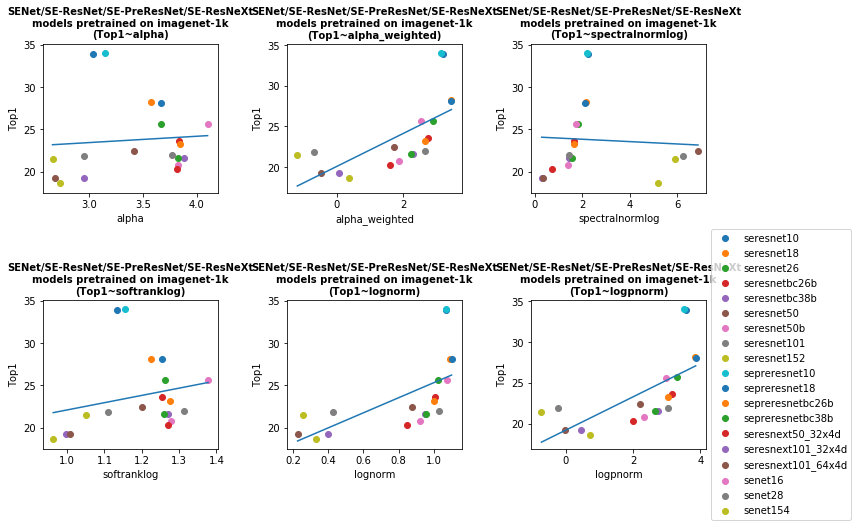

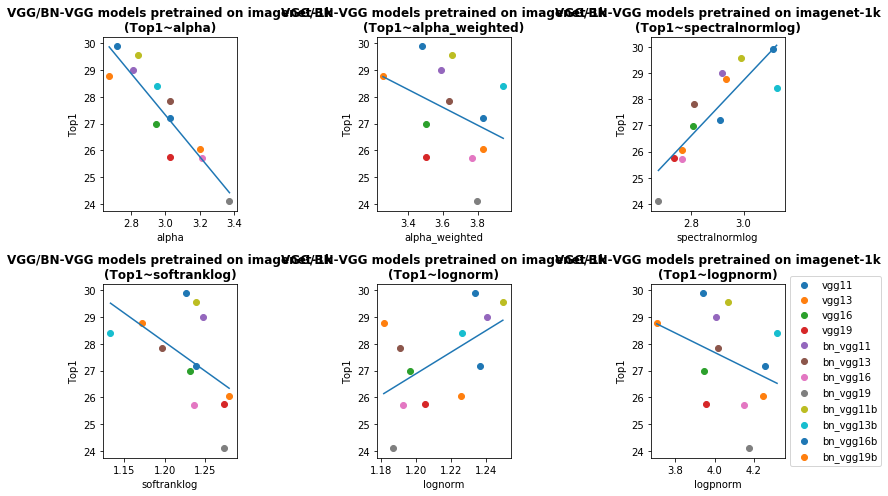

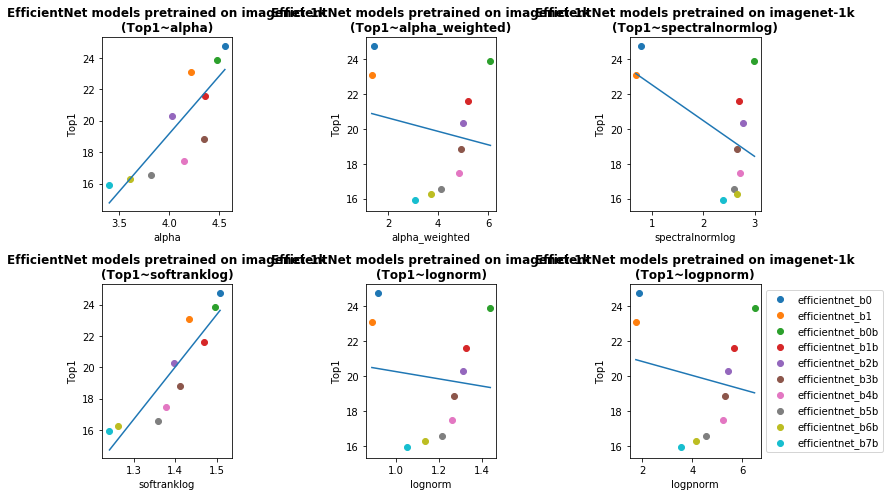

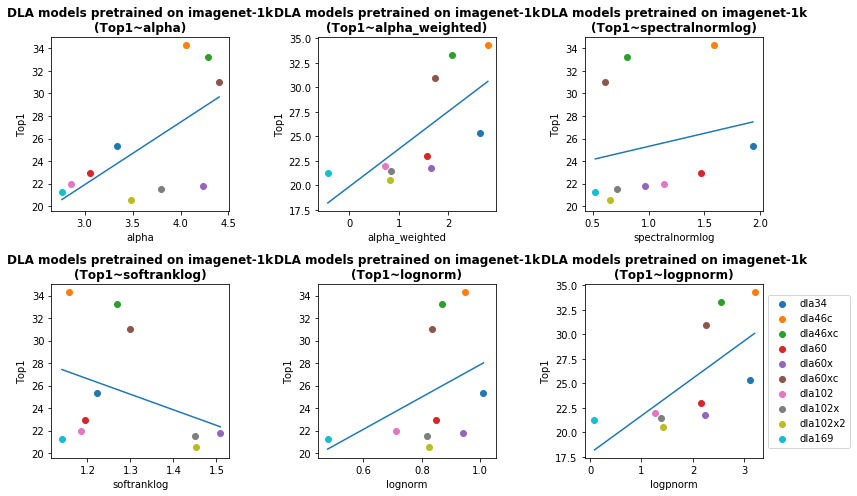

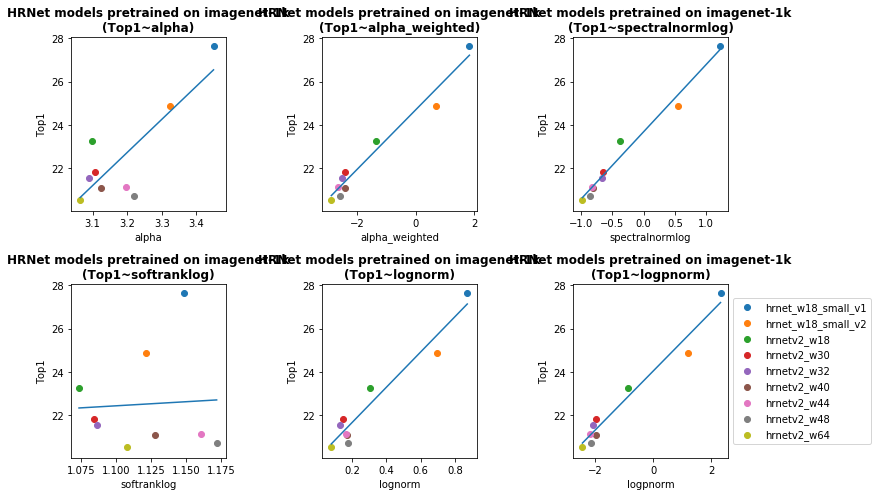

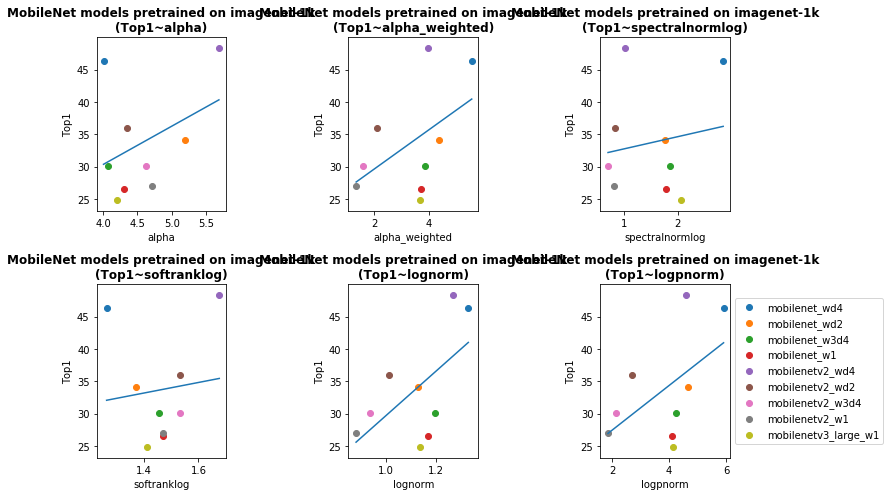

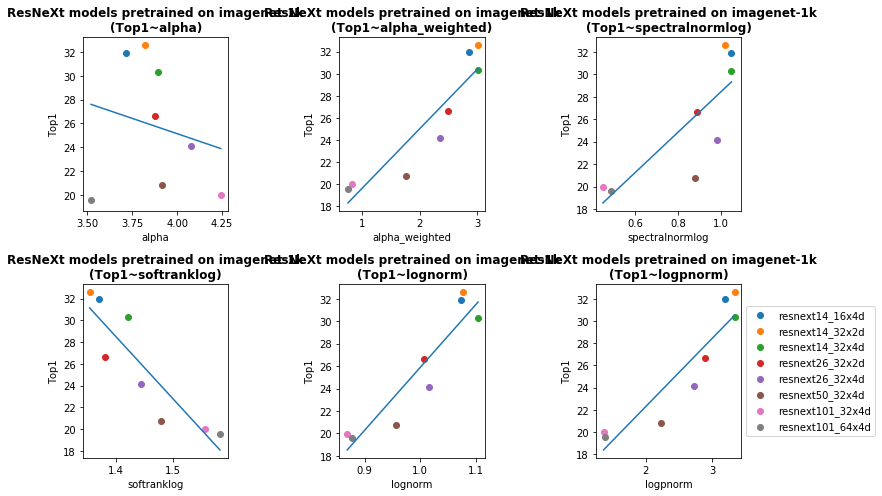

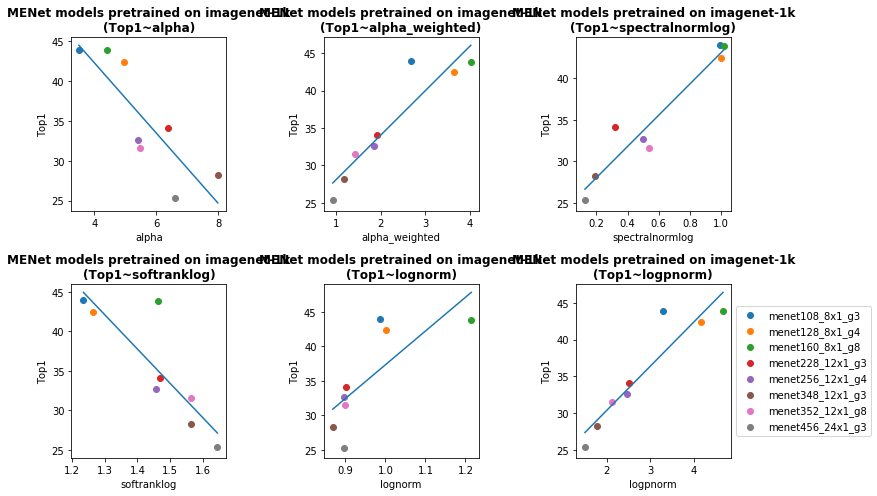

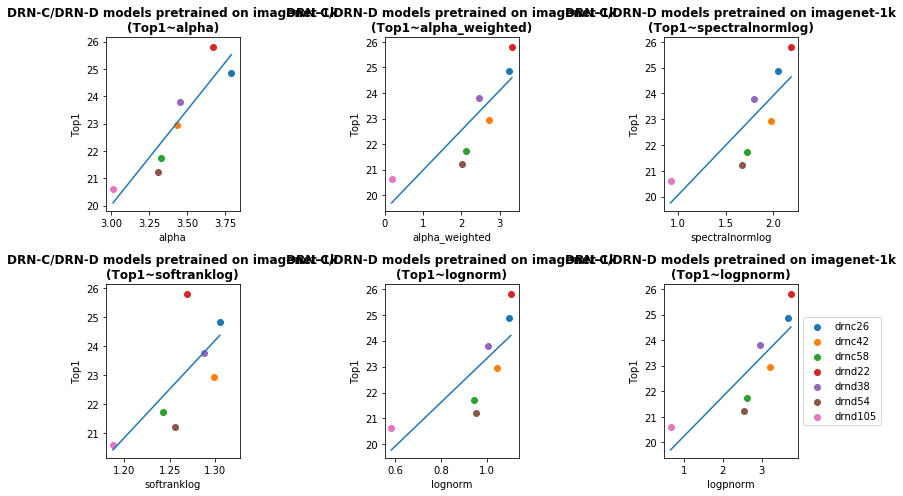

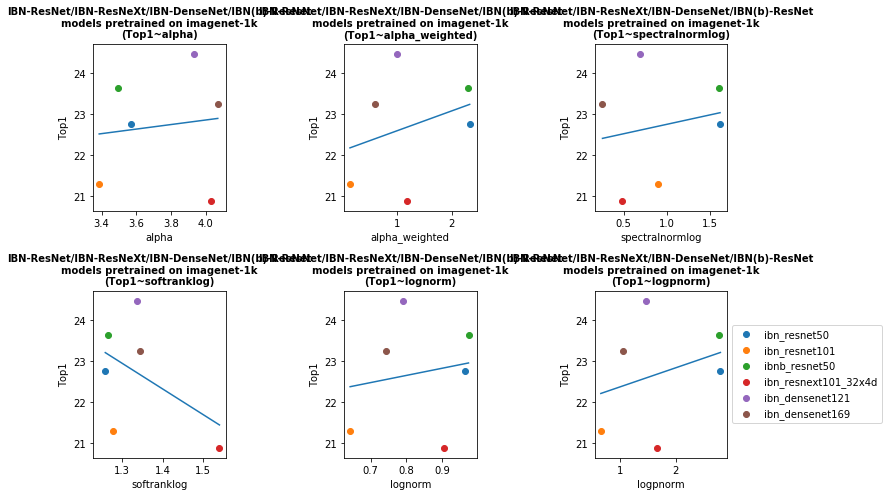

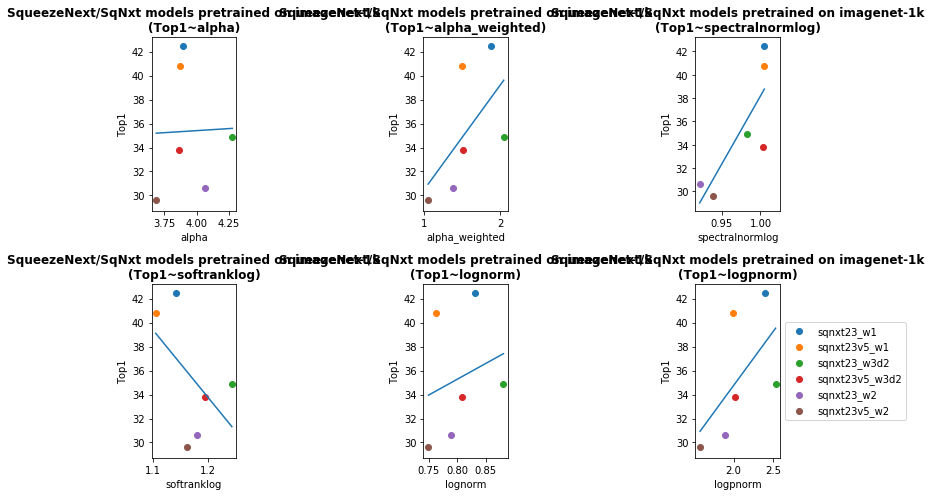

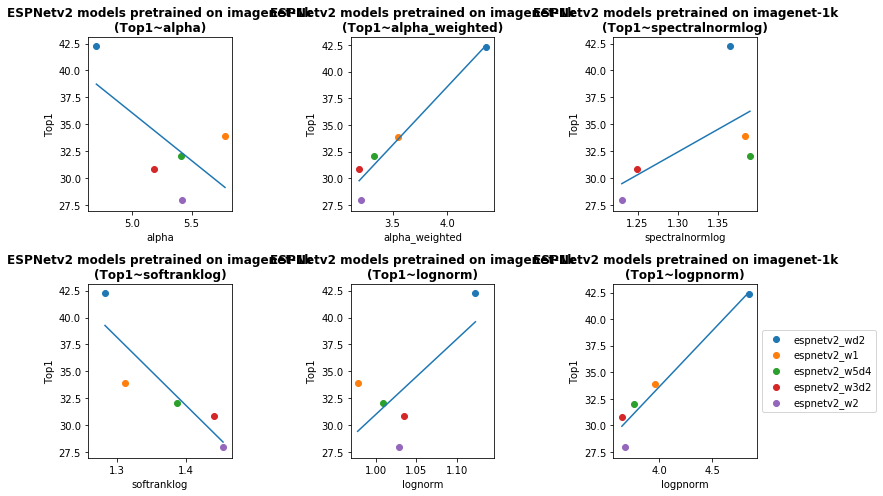

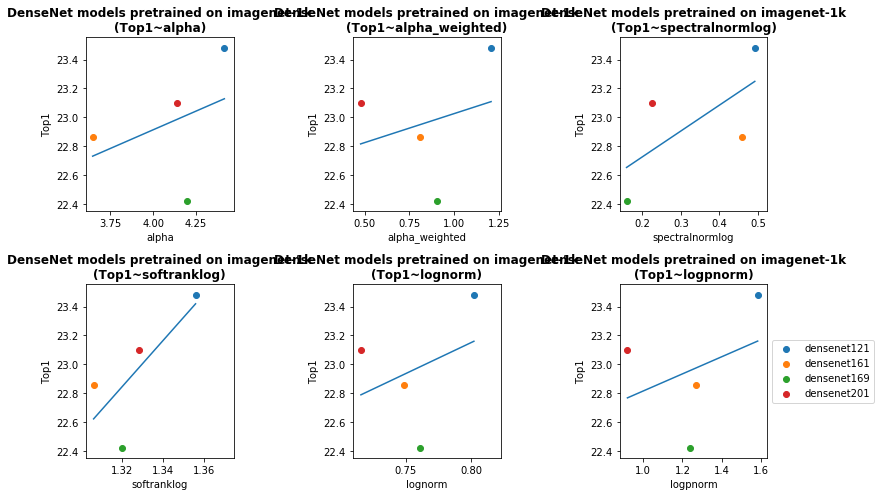

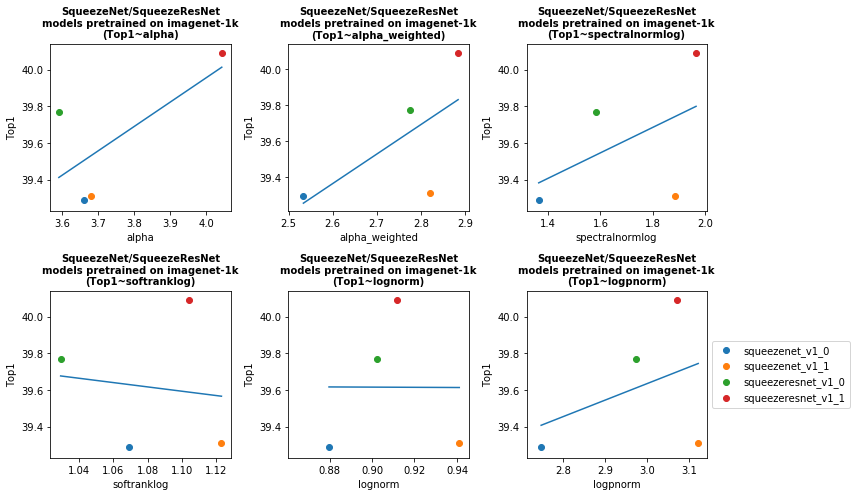

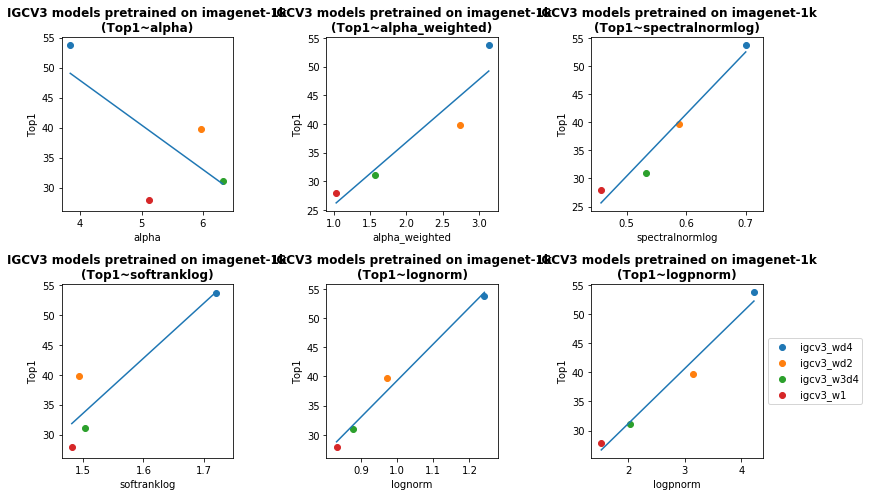

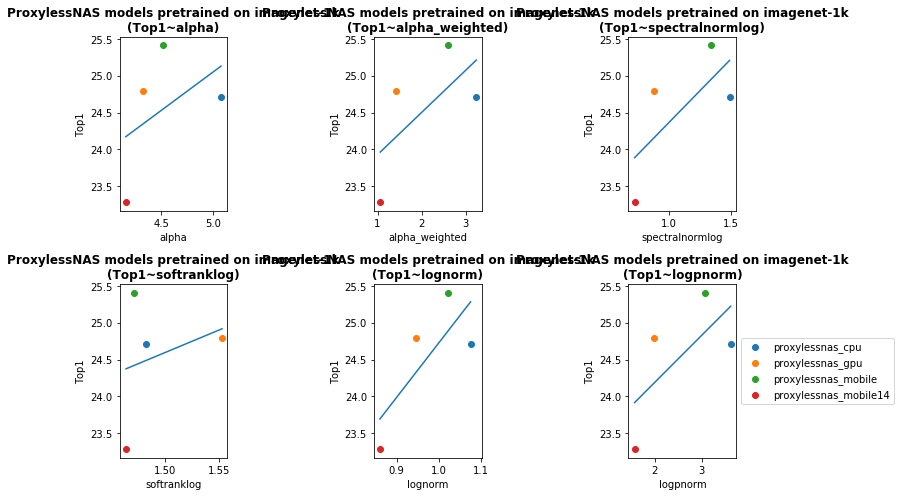

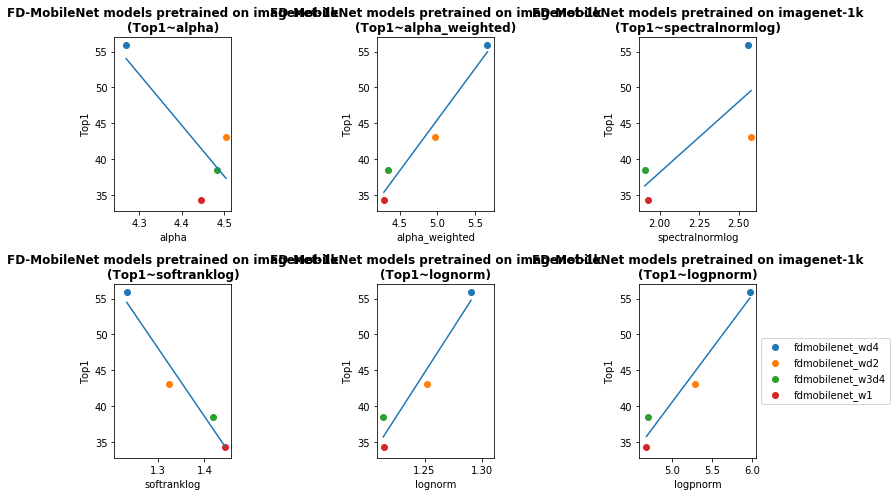

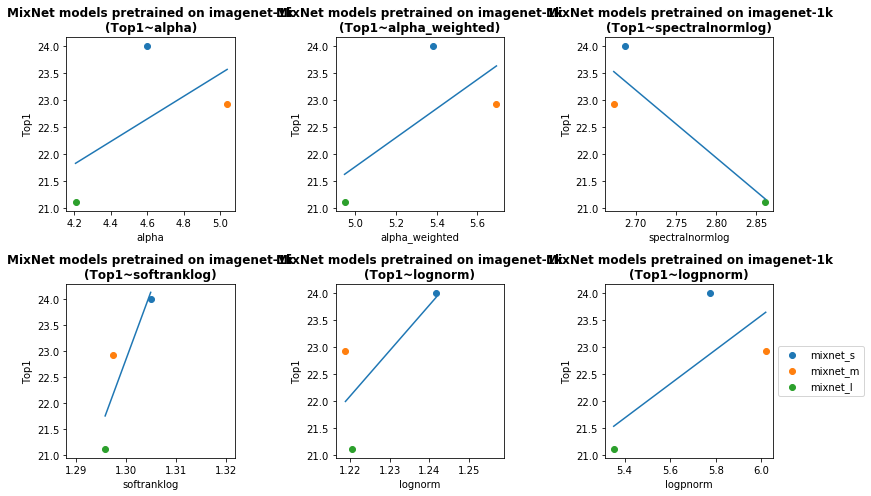

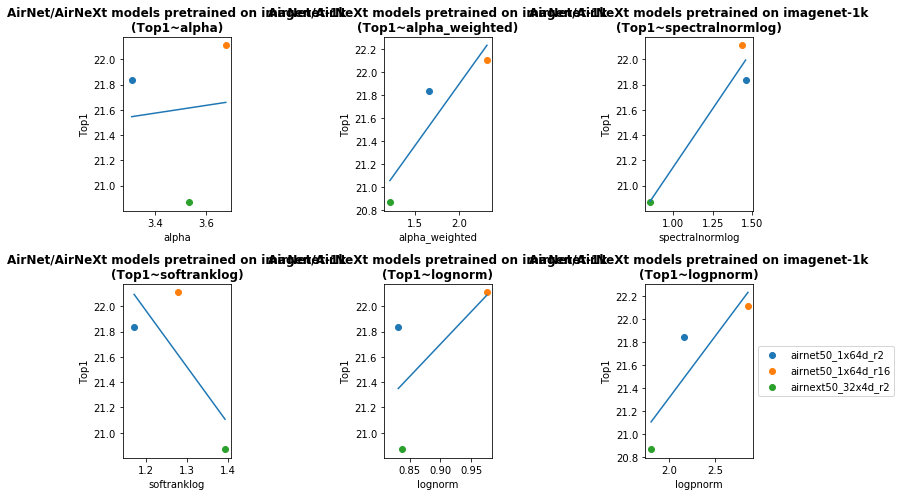

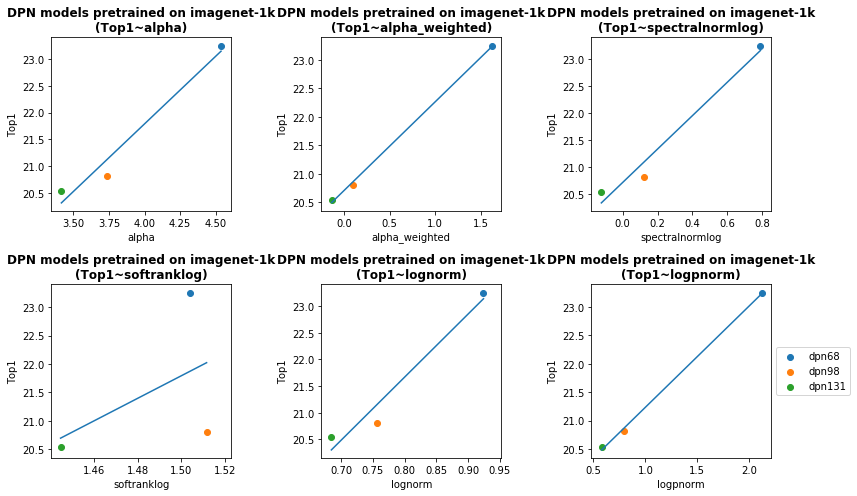

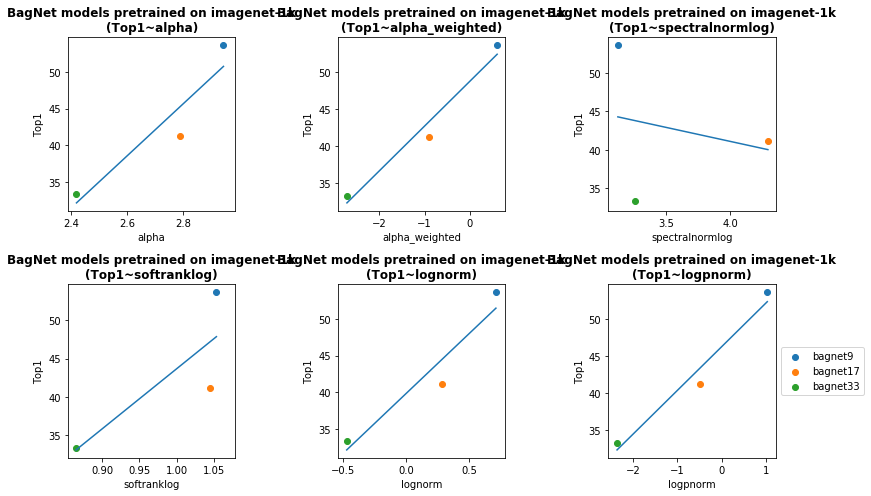

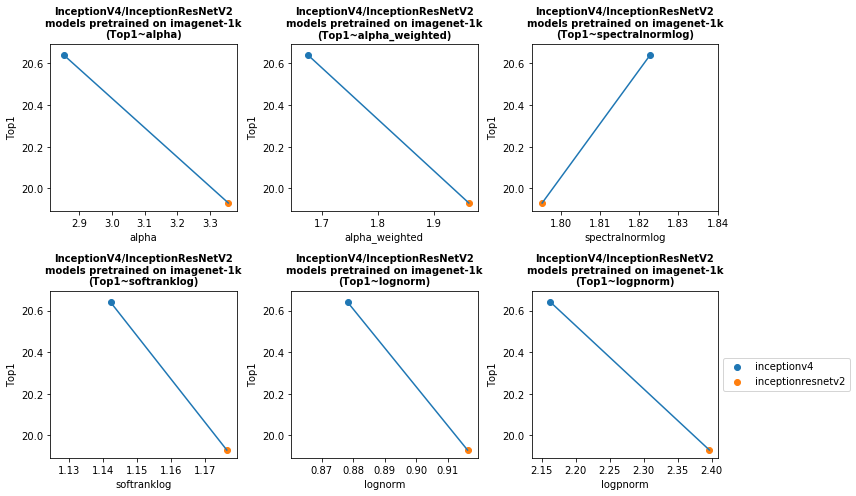

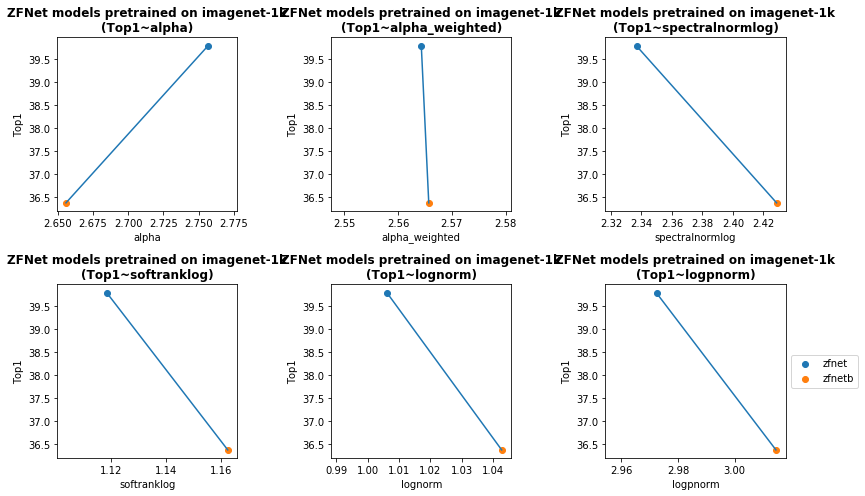

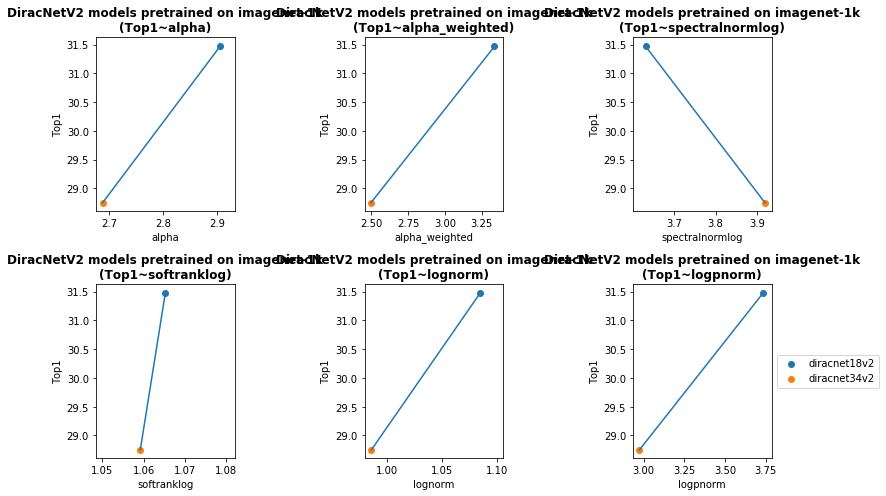

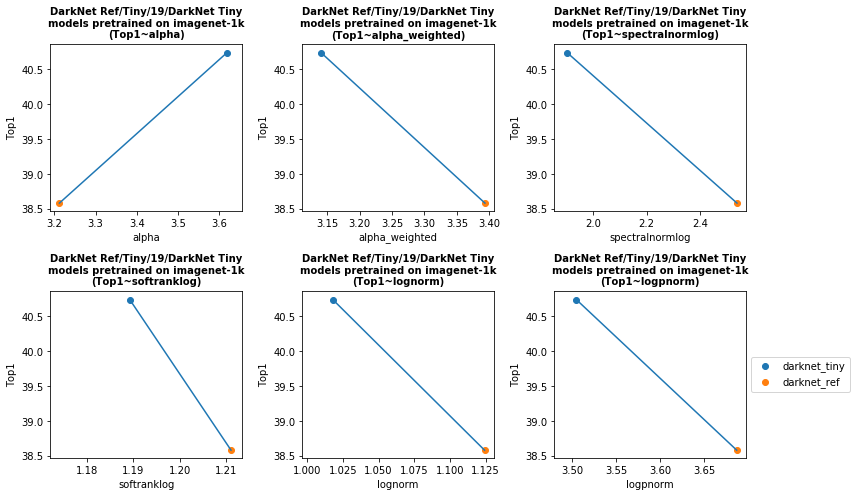

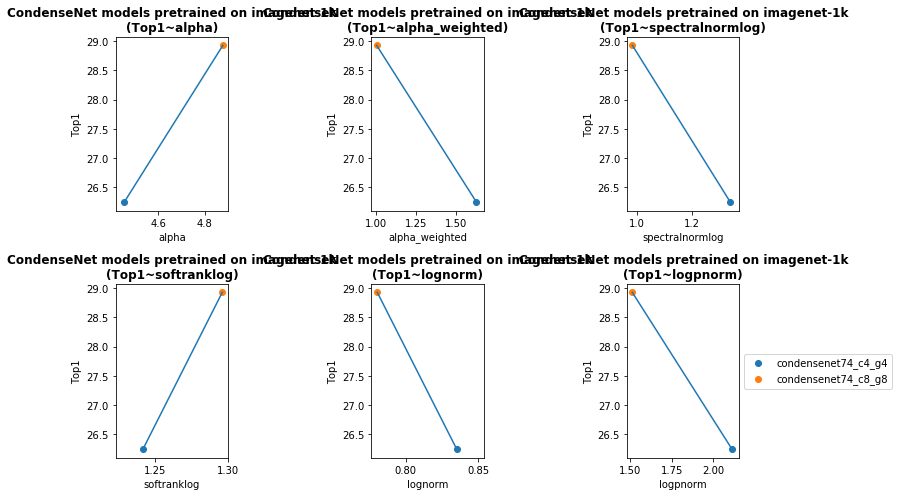

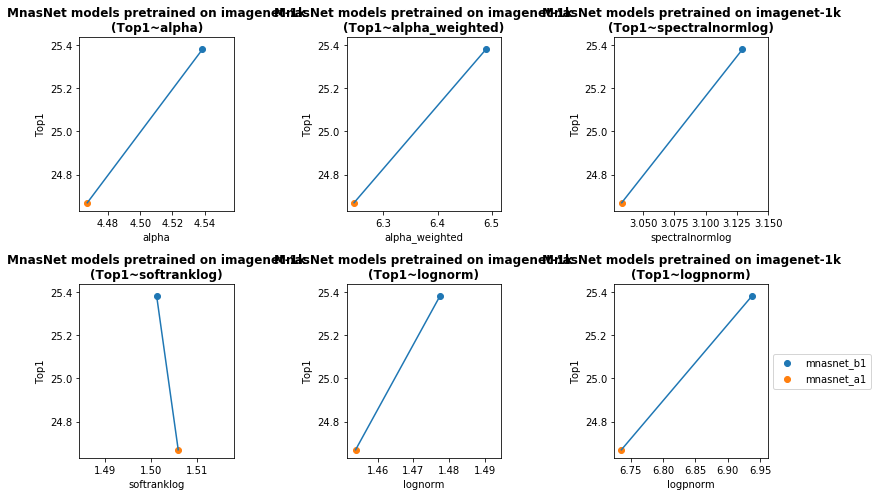

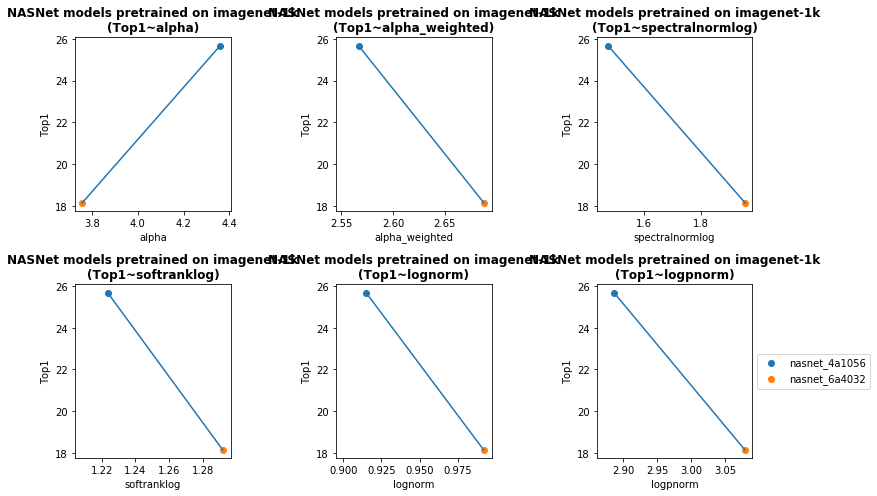

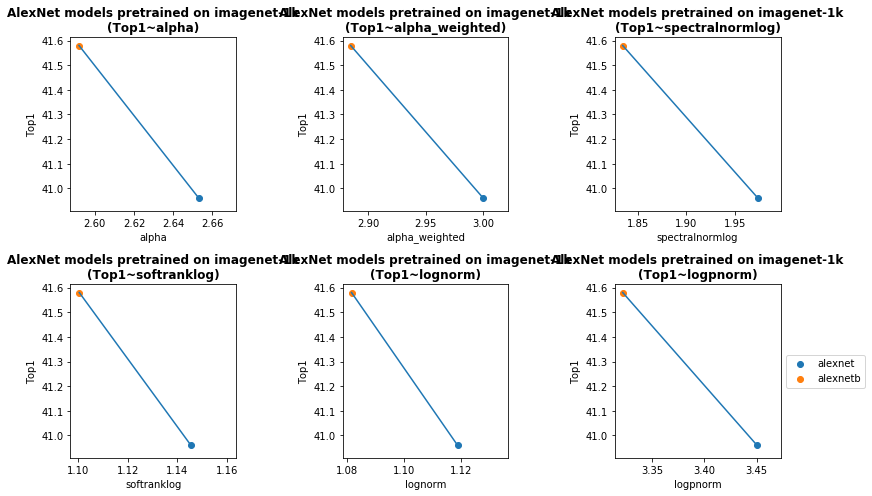

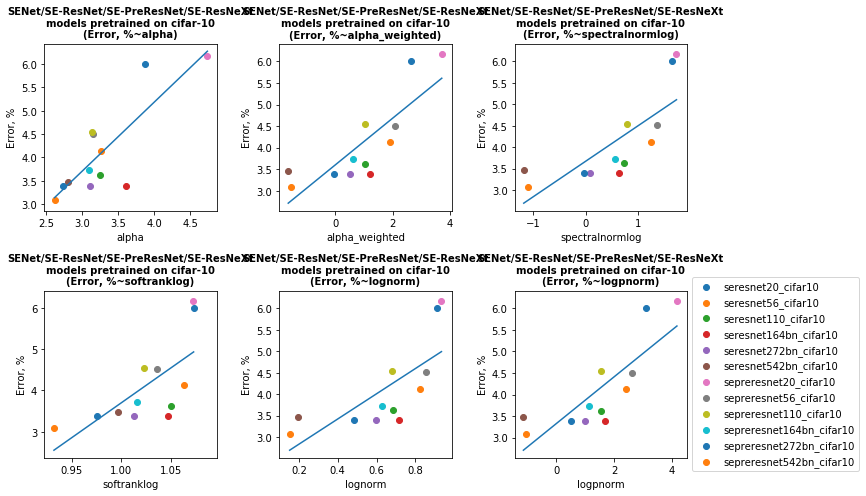

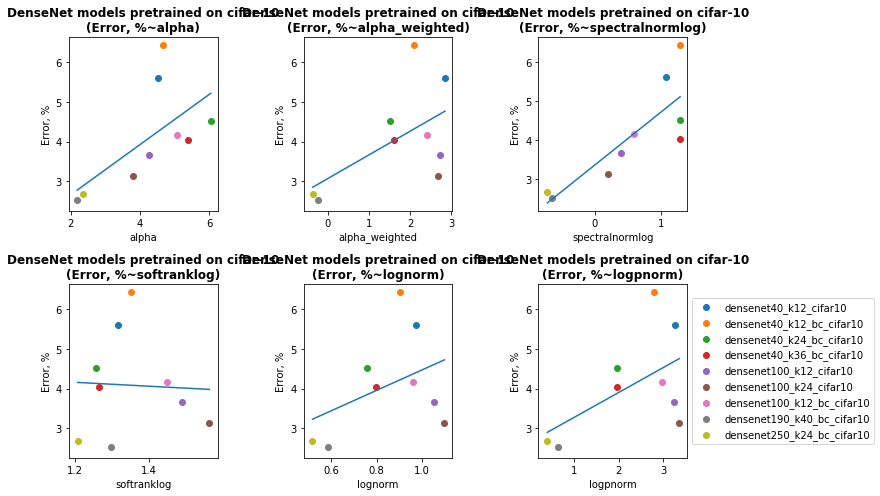

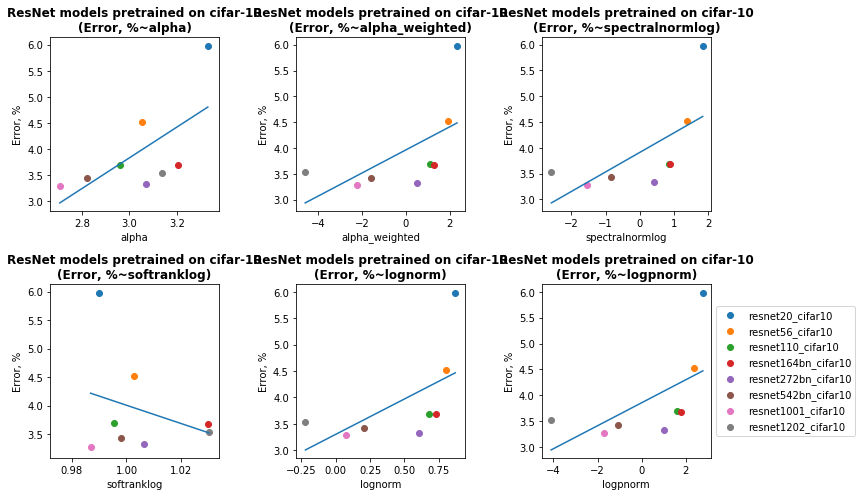

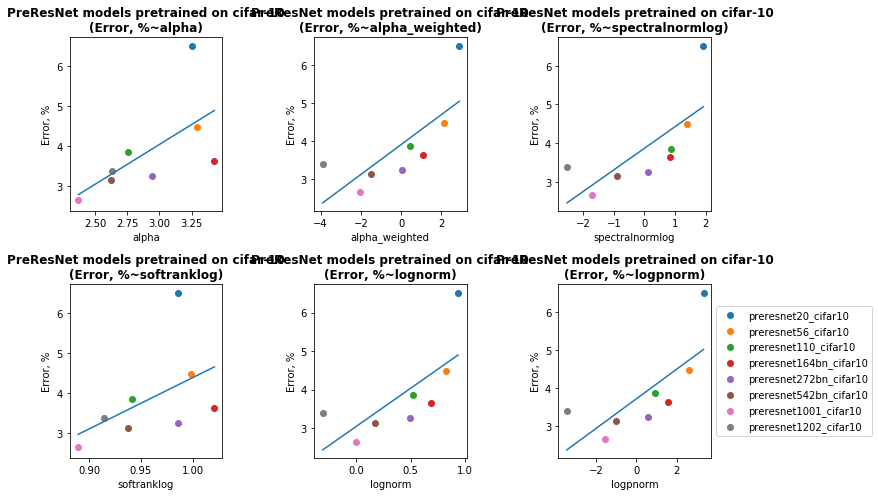

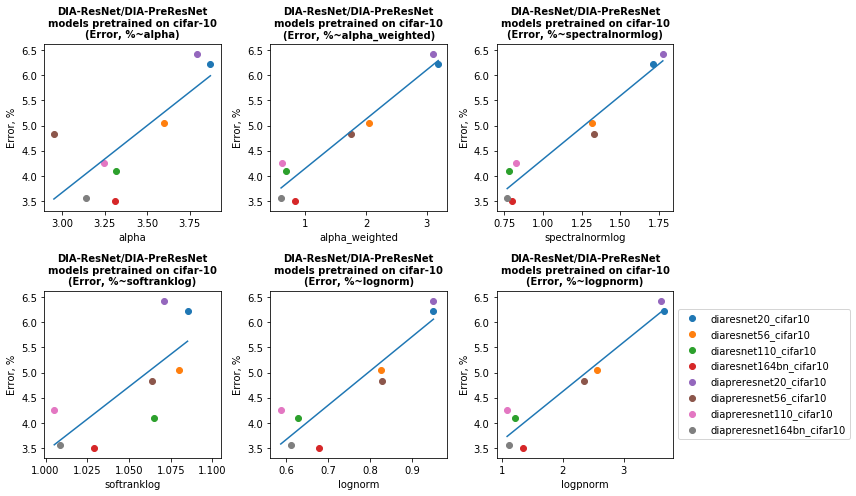

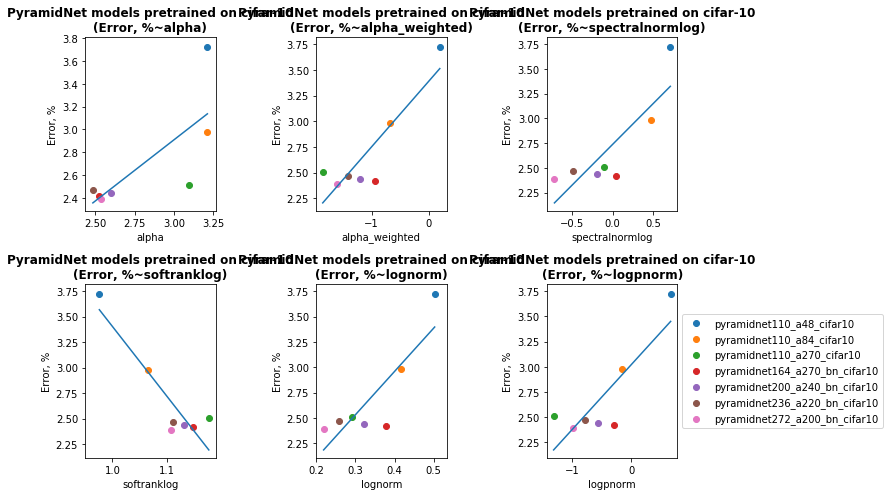

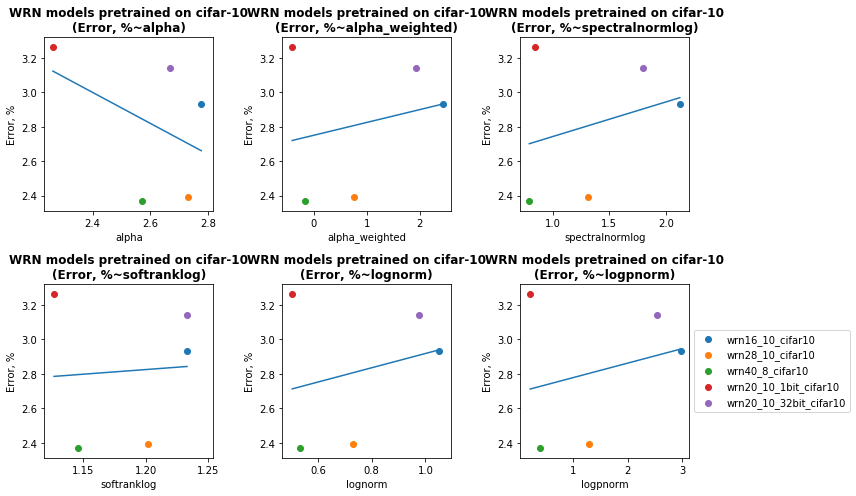

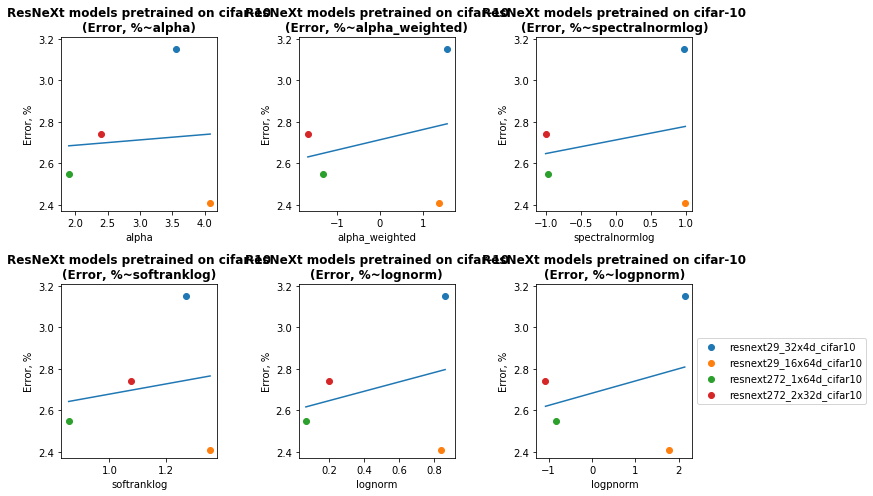

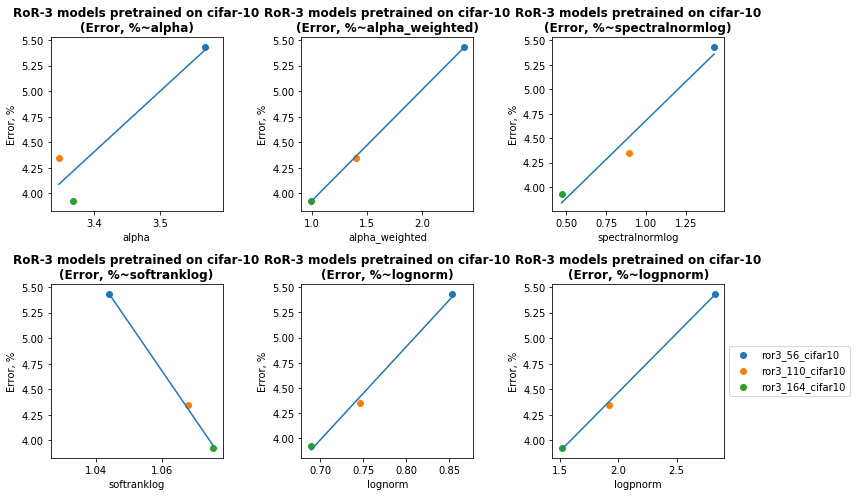

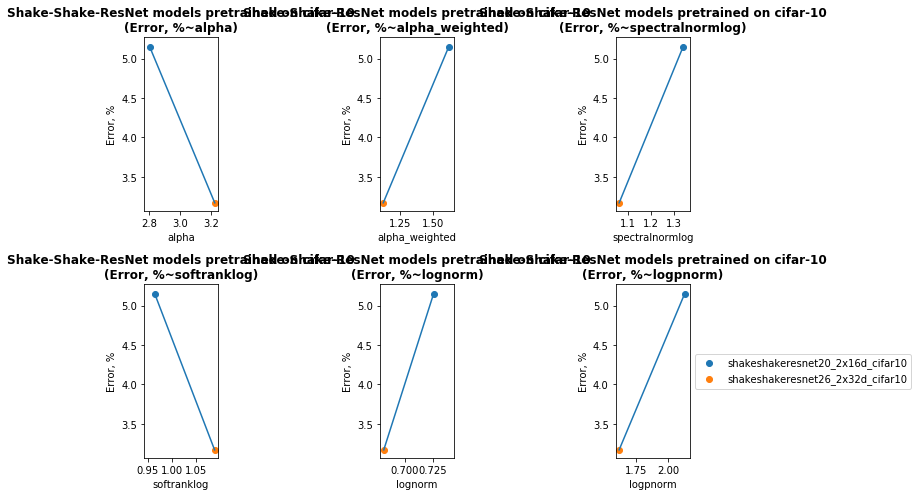

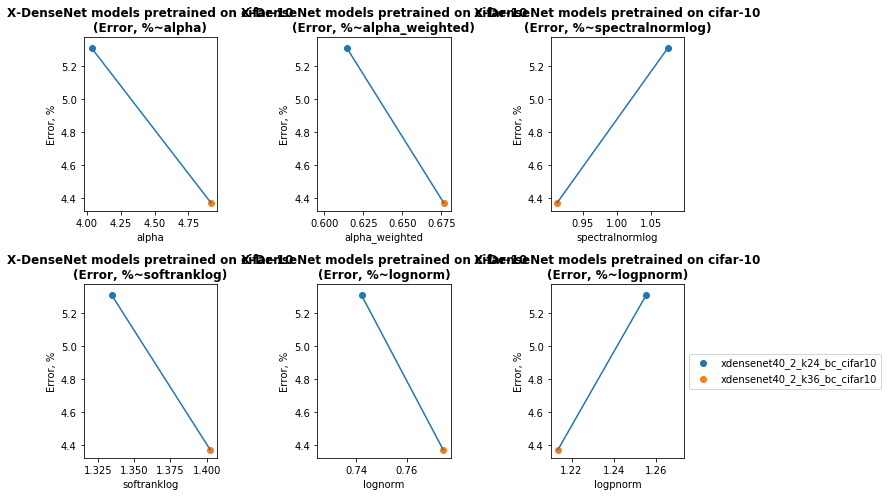

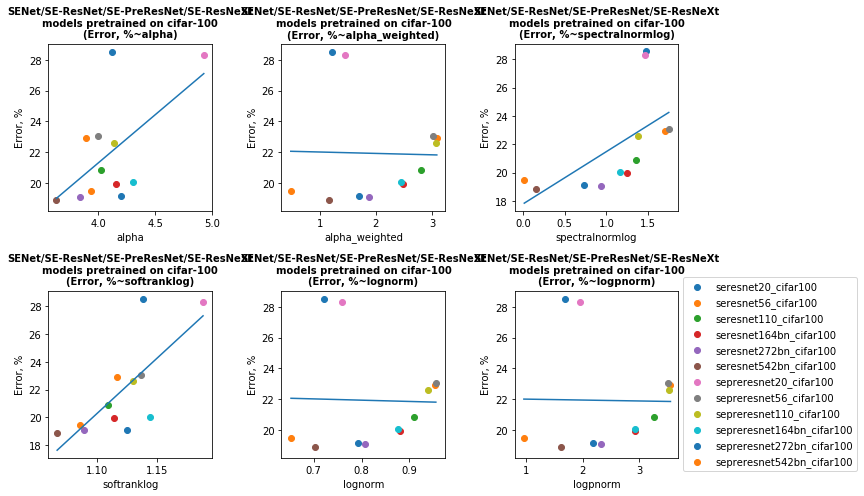

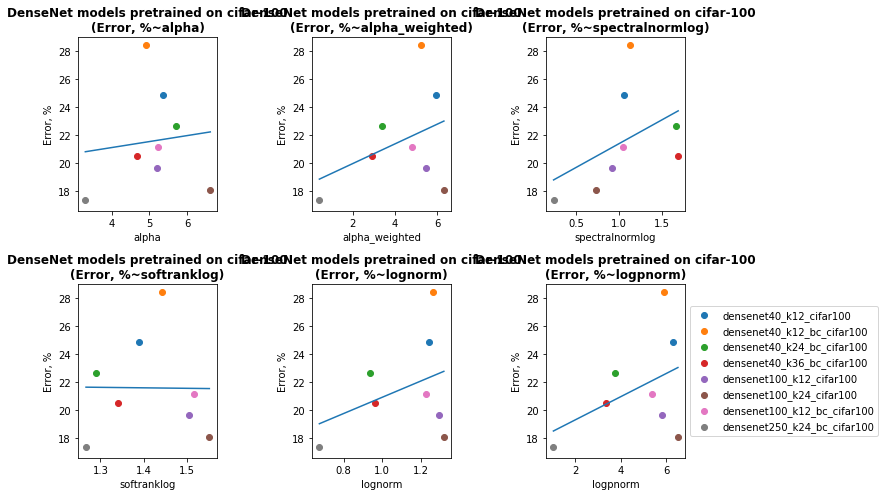

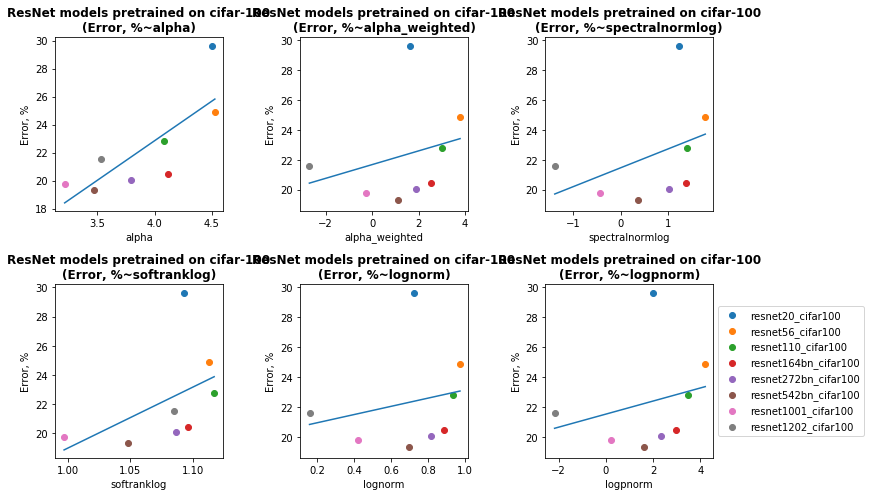

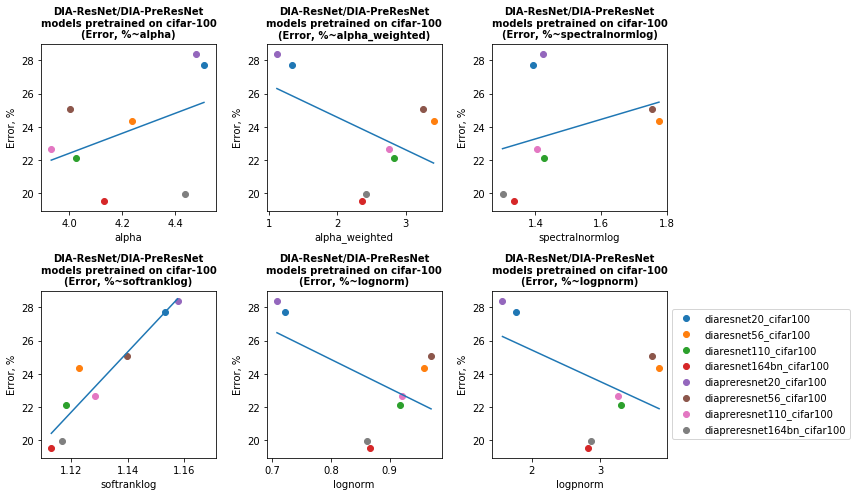

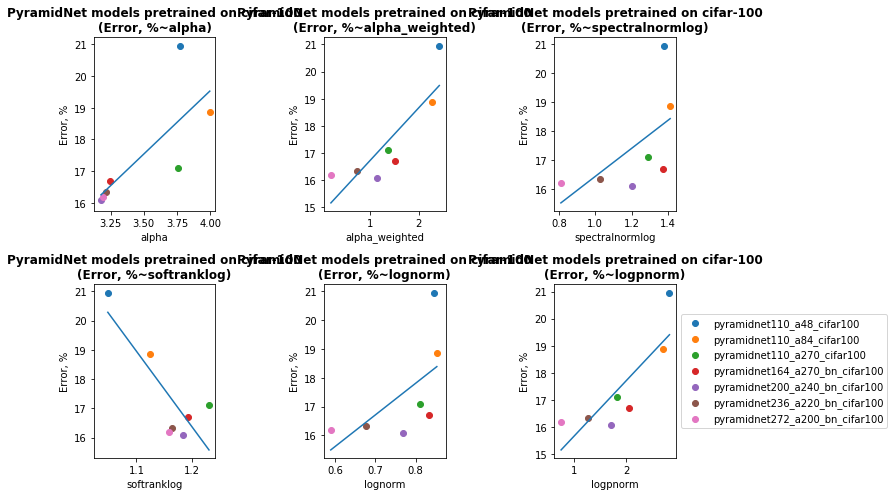

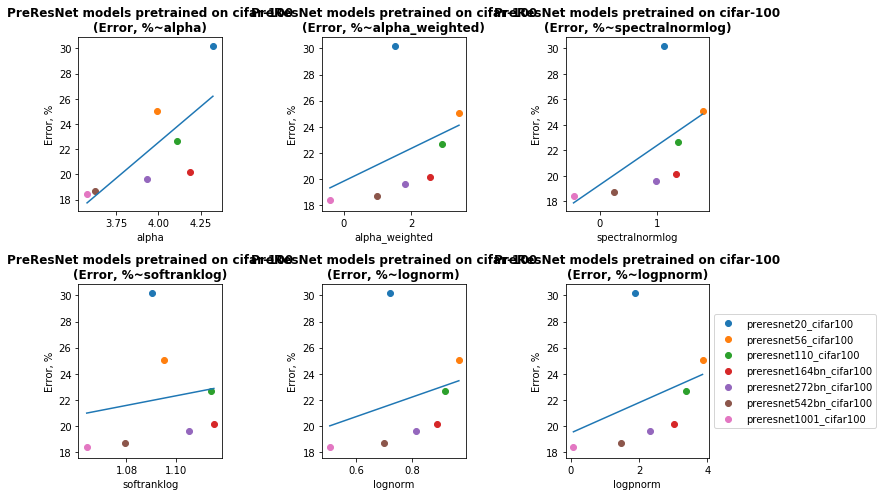

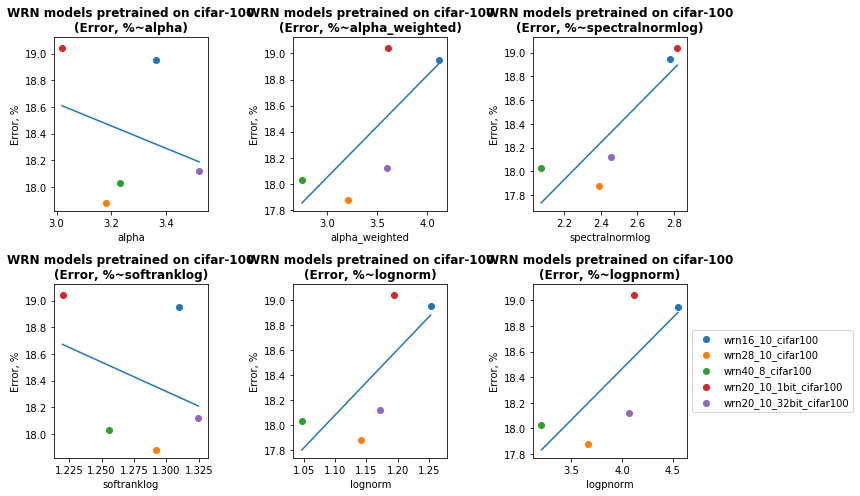

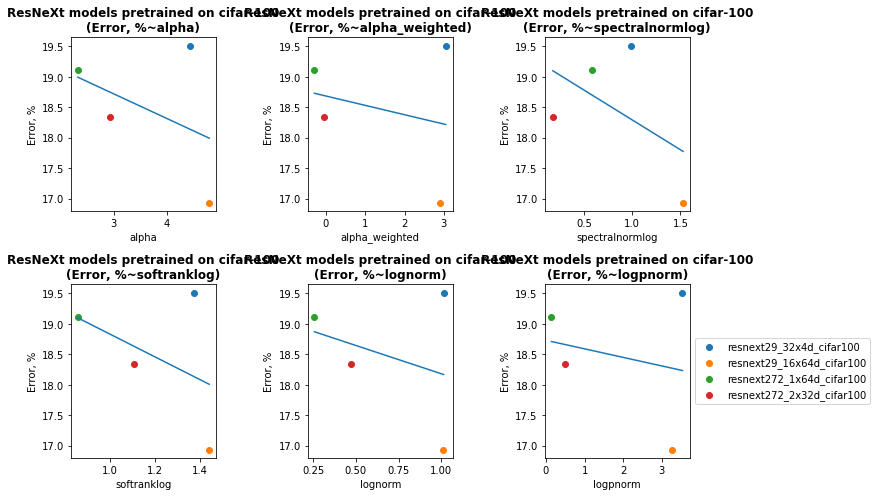

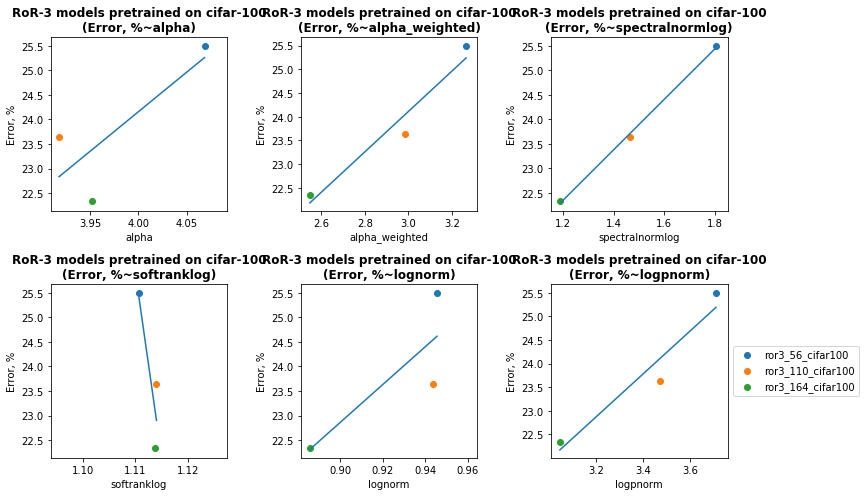

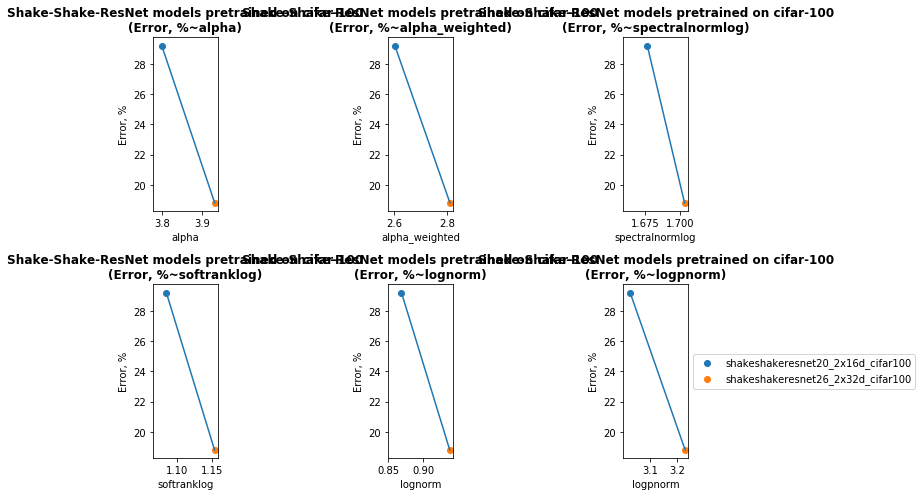

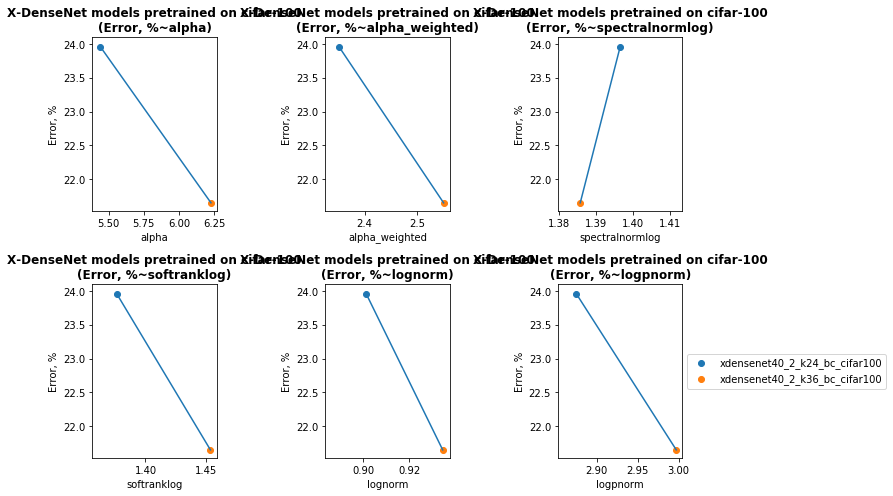

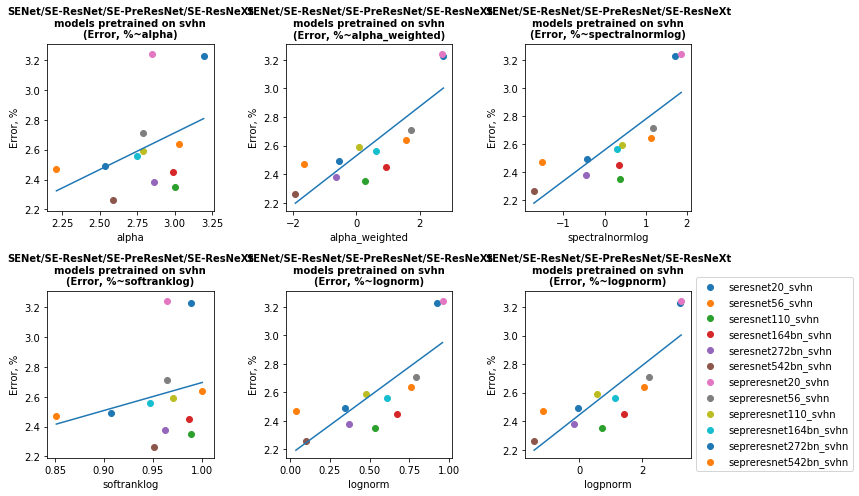

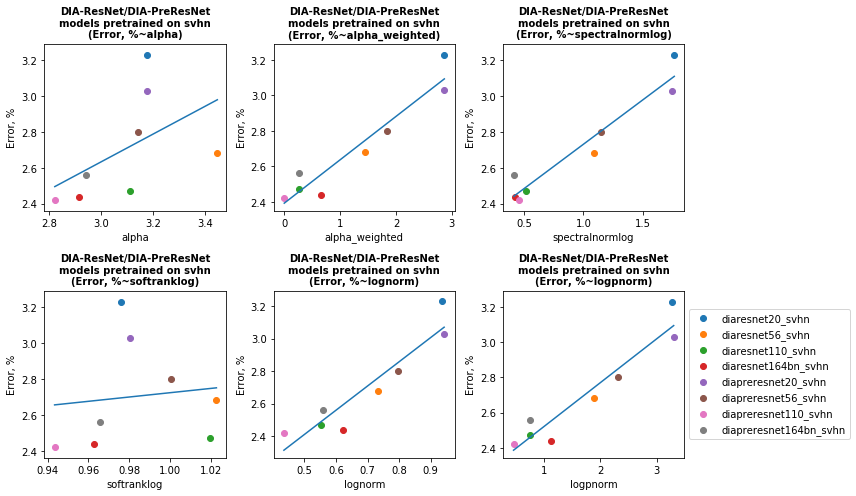

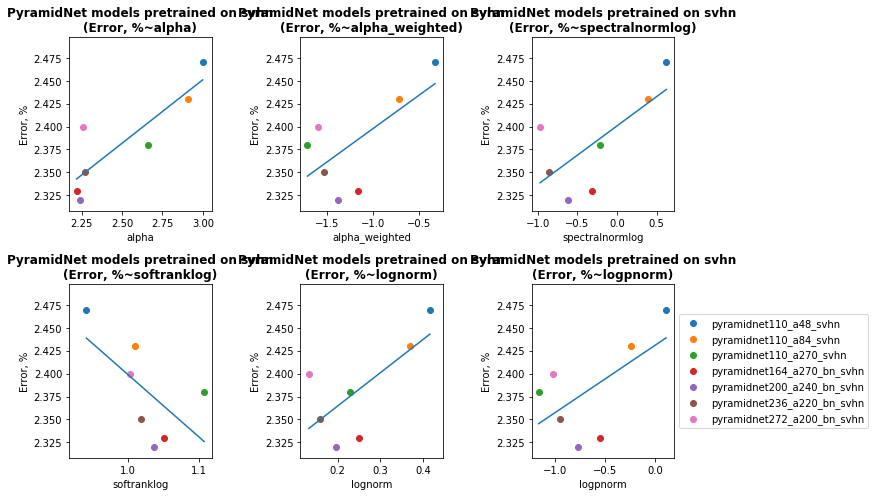

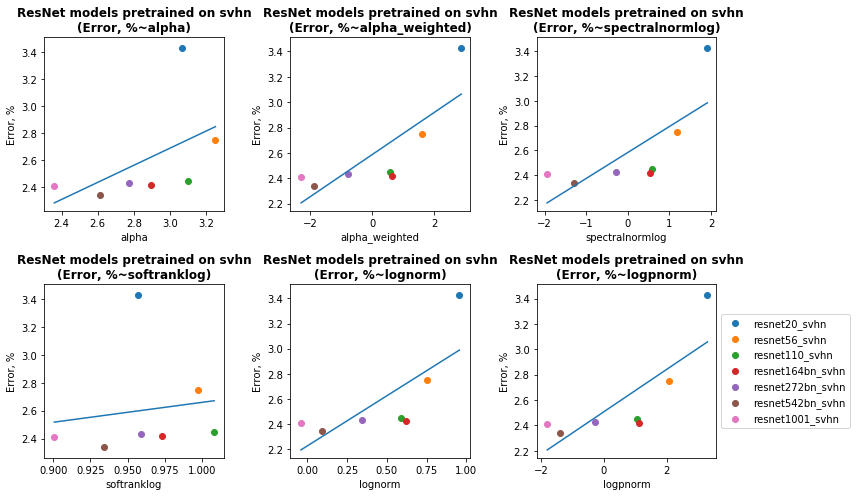

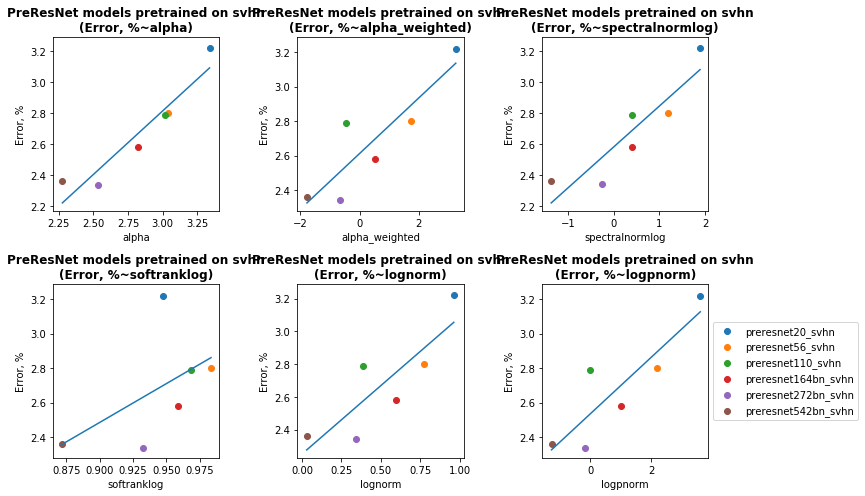

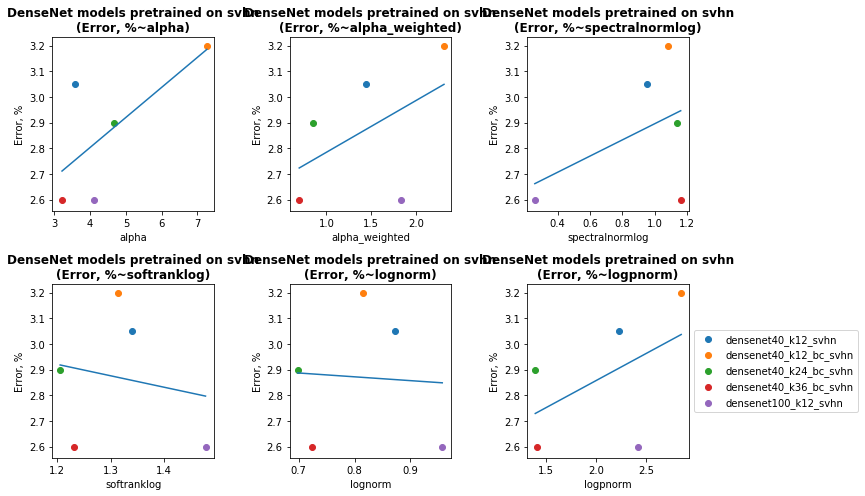

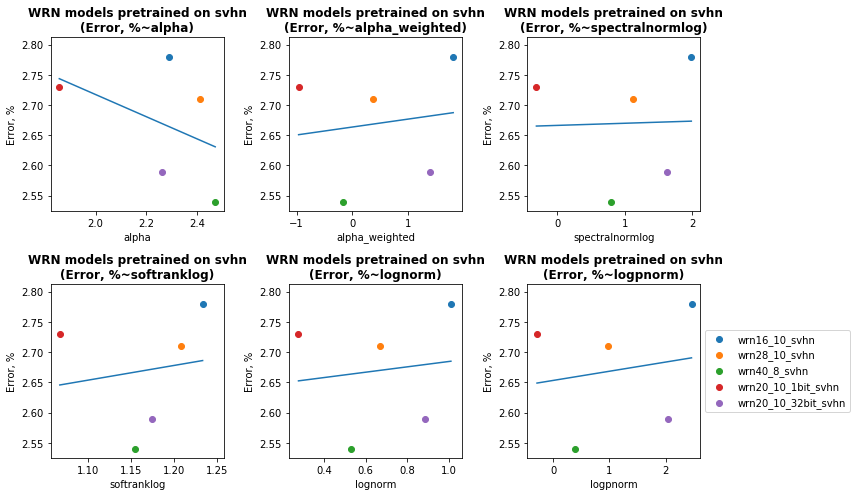

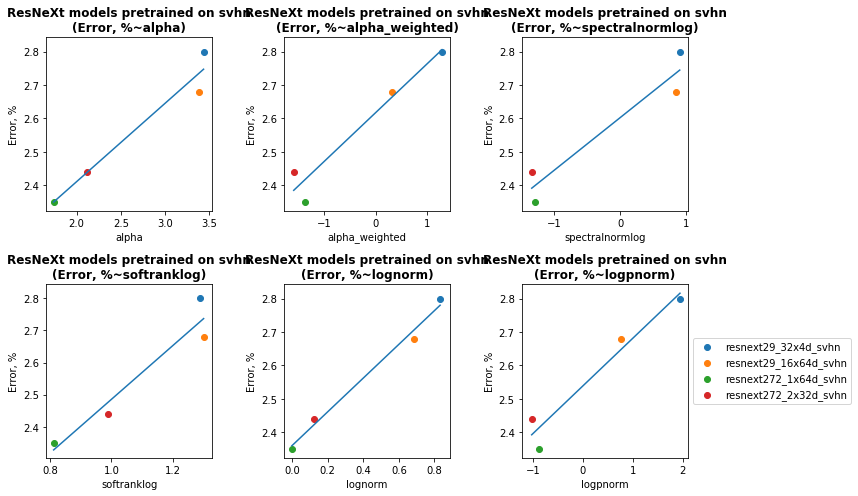

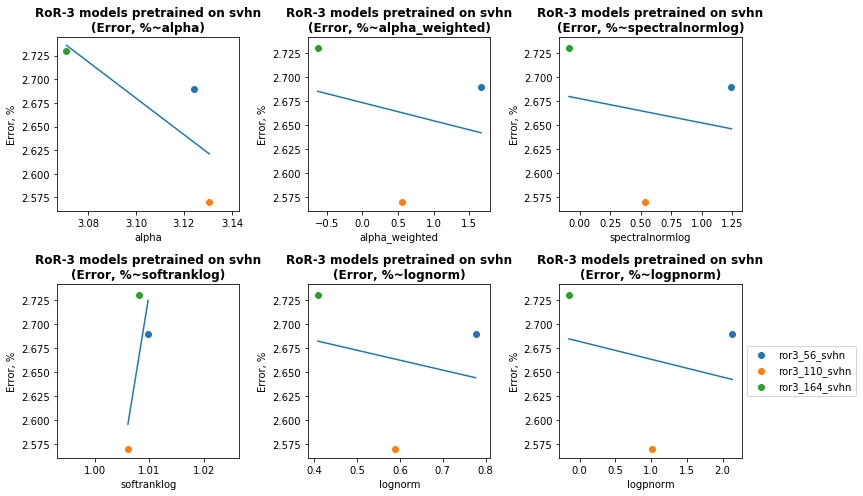

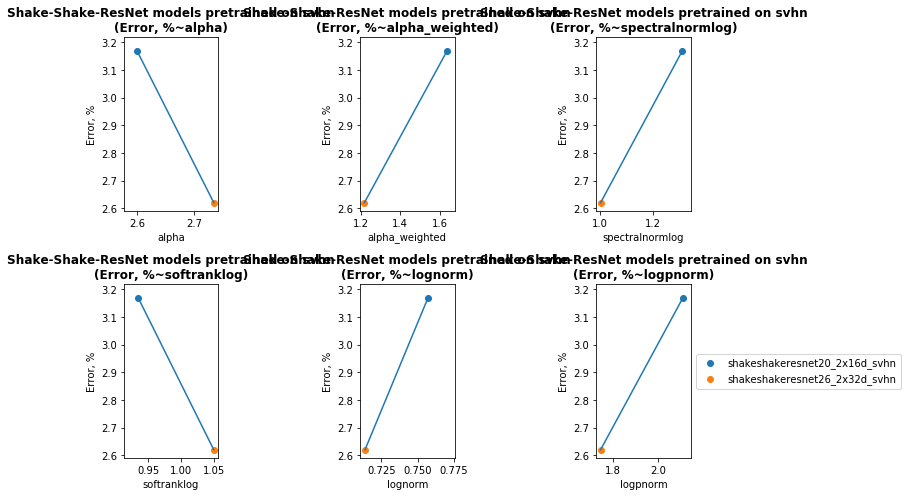

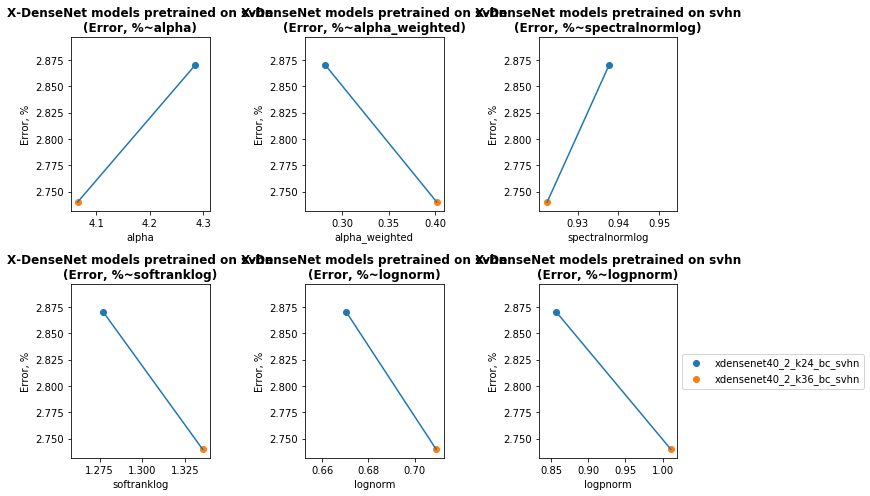

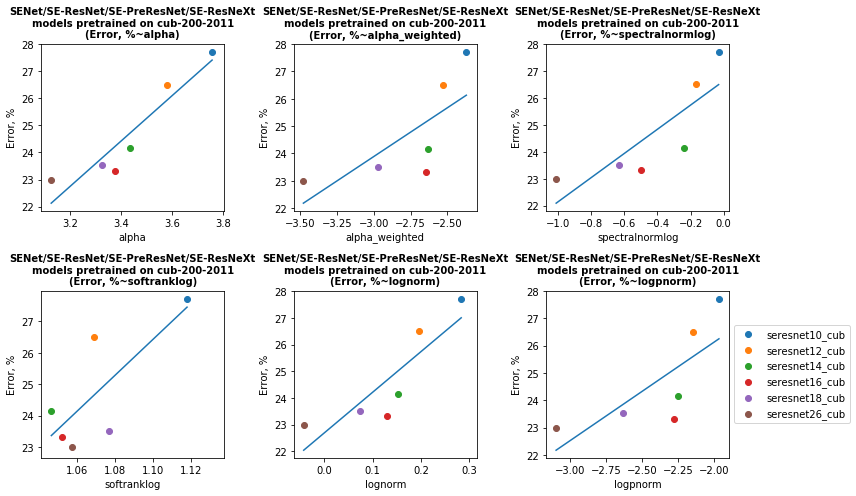

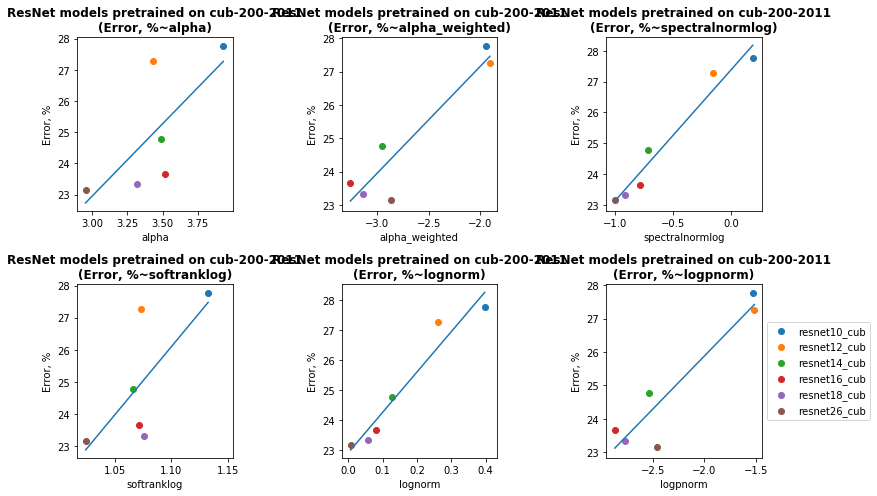

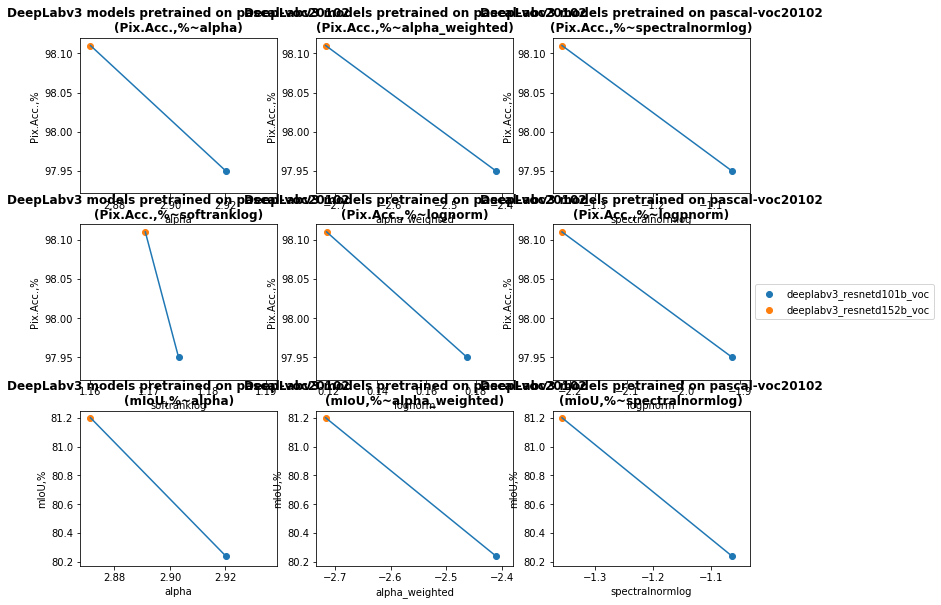

In [0]:
'''Fit a simple or polynomial on to the graph from above
ALL SIMPLE LINEAR FIT

output:
-------------------
1. Plots
2. df_fit (next cell): records the X, Y, degree, SSE and MSE for the fit'''

#    ply_degree = 2
df_fit = []
for d in datasets:
    df = df_full[d].copy()

    df.dropna(inplace=True)
    this_groups = df['group'].value_counts().to_frame()


    for g in this_groups[this_groups['group'] > 1].index:

        this_group = df[df['group'] == g].copy()
        this_group = this_group.dropna().reset_index(drop = True)
        n = len(this_group) #size

        tacc = [c for c in metrics_acc if c in this_group.columns]

        plotloc = int(len(tacc)*len(metrics)/num_rows*100 + 10*num_cols + 1)

        if len(tacc) > 1:
            plt.figure(figsize = (12,20))
        else:
            plt.figure(figsize = (12,10))
        
        #if the size is too small, fit a linear reg; otherwise, fit a polynomial
        if n > 1000: #10: 
            this_deg = 2
        else:
            this_deg = 1
            
        for ac in tacc:#metrics_acc:
            for x in metrics:

                try:
                  plt.subplot(plotloc)
                  for i in range(len(this_group)):
                      plt.scatter(this_group.loc[i,x], this_group.loc[i, ac], label = this_group.loc[i, 'modelname'])
                  plt.xlabel(x)
                  plt.ylabel(ac)
                  if len(g) > 20:
                      plt.title('{}\nmodels pretrained on {}\n({}~{})'.format(g, d, ac, x), 
                                fontweight = 'bold', fontsize = 10)
                  else:
                      plt.title('{} models pretrained on {}\n({}~{})'.format(g, d, ac, x), 
                                fontweight = 'bold')

                
                  # this_fit = np.polyfit(this_group[x], this_group[ac], 
                  #                       this_deg ,full = True)
                  # coef = this_fit[0]
                  this_fit = sm.OLS(this_group[ac], sm.add_constant(this_group[x])).fit()
                  coef = this_fit.params[x] #this_fit[0]
                  this_x = np.linspace(min(this_group[x]), max(this_group[x]), 50)

                  plt.plot(this_x, this_fit.predict(sm.add_constant(this_x))) ##coef[0]*this_x**2 + coef[1]*this_x + coef[2]) 

                  try:
                      this_sse = this_fit.ssr ##this_fit[1][0]
                      this_rsquared = this_fit.rsquared
                  except:
                      pass
                      # try:
                      #     this_sse = np.sum((coef[0]*this_group[x]**2 + coef[1]*this_group[x] + coef[2] - this_group[ac])**2)
                      # except:
                      #     this_sse = np.sum((coef[0]*this_group[x] + coef[1] - this_group[ac])**2)                                

                  this_arch = [d, g, ac, x, this_deg, n, this_rsquared, this_sse, this_sse/n]

                except np.linalg.LinAlgError: #does not converge
                    print("{} did not converge {}".format(d))
                    this_arch = [d, g, ac, x, this_deg, n, 'Not converge', np.nan, np.nan]

                df_fit.append(this_arch)
                plotloc += 1

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) #this_group['Model']
        plt.tight_layout()



In [0]:
df_fit = pd.DataFrame(df_fit, columns = ['Dataset', 'Archtecture', 'Test Accuracy', 
                                          'x Variable', 'Poly Degree','# of Models', 
                                         'r^2', 'SSE', 'MSE'])

print("number of records {}".format(len(df_fit)))
df_fit.dropna(inplace=True)

del this_groups
del this_group
del this_x
del this_sse

print("number of records {}".format(len(df_fit)))
df_fit

In [0]:
## df_fit records the X, Y, SSE, and MSE for the fit
df_fit.to_excel(path + '/' + 'df_fit.xlsx')


In [0]:
for x in ['r^2', 'MSE']:
    temp = df_fit.copy()
    temp = temp[temp['# of Models'] > 5].reset_index(drop = True)
    df_fitp = temp.pivot_table(values = x, columns = 'x Variable', 
                            index = ['Dataset', 'Archtecture', 'Test Accuracy'])

    print('For ' + x + ':')
    summary = df_fitp.describe()
    display(summary)
    print('===============================================')

del df_fitp

In [0]:
'''Between the ww metrics
no alpha_weighted'''

for d in datasets:
    temp = df_full[d].copy()
    df = temp.dropna()
    if len(temp) == 1:
        continue

    plotloc = 131
    plt.figure(figsize = (10,10))
    for x, y in itertools.combinations(metrics[:1] + metrics[2:],2):
        #plt.subplot(plotloc)
        plt.scatter(df[x], df[y])
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title('All {} pretrained models\n({}~{})'.format(d, y, x), 
                  fontweight = 'bold')
        plt.figure(figsize = (10,10))
        plt.tight_layout()
        plt.show()

        plotloc += 1

    

del temp


In [0]:
df.head()

## Analysis of *VGG* 

In [0]:
df = df_full['imagenet-1k']
vgg_df = df[df.Model.str.contains('VGG')]
display(vgg_df)

In [0]:
display(vgg_df[['Model', 'Top1', 'alpha', 'norm', 'alpha_weighted']].sort_values('Top1'))

In [0]:
vgg_df.plot(x='Top1', y= 'alpha', kind='scatter')
vgg_df.plot(x='Top1', y= 'softrank', kind='scatter')
vgg_df.plot(x='Top1', y= 'norm', kind='scatter')
vgg_df.plot(x='Top1', y= 'alpha_weighted', kind='scatter')

## **HuggingFace Models**

### **1. Analyze all models using Weightwatcher**

In [0]:
!pip install pytorch-transformers

In [0]:
import pytorch_transformers as pt
import torch

In [0]:
hf_models = pd.read_html('https://huggingface.co/pytorch-transformers/pretrained_models.html')[0]
hf_models.head()

In [0]:
# PyTorch-Transformers has a unified API
# for 7 transformer architectures and 30 pretrained weights.
#          Model              | Tokenizer             | Pretrained weights shortcuts
MODELS = [(pt.BertModel,       pt.BertTokenizer,       hf_models.loc[hf_models['Architecture'] == 'BERT', 'Shortcut name'].tolist()),
          (pt.OpenAIGPTModel,  pt.OpenAIGPTTokenizer,  hf_models.loc[hf_models['Architecture'] == 'GPT', 'Shortcut name'].tolist()),
          (pt.GPT2Model,       pt.GPT2Tokenizer,       hf_models.loc[hf_models['Architecture'] == 'GPT-2', 'Shortcut name'].tolist()),
          (pt.TransfoXLModel,  pt.TransfoXLTokenizer,  hf_models.loc[hf_models['Architecture'] == 'Transformer-XL', 'Shortcut name'].tolist()),
          (pt.XLNetModel,      pt.XLNetTokenizer,      hf_models.loc[hf_models['Architecture'] == 'XLNet', 'Shortcut name'].tolist()),
          (pt.XLMModel,        pt.XLMTokenizer,        hf_models.loc[hf_models['Architecture'] == 'XLM', 'Shortcut name'].tolist()),
          (pt.RobertaModel,    pt.RobertaTokenizer,    hf_models.loc[hf_models['Architecture'] == 'RoBERTa', 'Shortcut name'].tolist()),
          (pt.DistilBertModel, pt.DistilBertTokenizer, hf_models.loc[hf_models['Architecture'] == 'DistilBERT', 'Shortcut name'].tolist())]


In [0]:
'''Run the HuggingFace Models'''
data_hf = {}
i = 0
for model_class, tokenizer_class, pretrained_weights in MODELS[6:]:
    # Load pretrained model/tokenizer
    #tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    
    for m in pretrained_weights:
        
        if (m == 'roberta-base') | (m == 'roberta-large'):
            continue
            
        s = time.time()
        model = model_class.from_pretrained(m)
        
        ## apply ww
        watcher = ww.WeightWatcher(model=model, logger=logger)
        results = watcher.analyze(alphas = True, spectralnorms=True, softranks=True)
        
        data_hf[m]=watcher.get_summary()
        e = time.time()
        
        print('\nTime spent to run {} model is {} minutes'.format(m, (e-s)/60.))
        print('----------------------------------------------------------------')
        
        df_hf = pd.DataFrame.from_dict(data_hf).transpose()
        df_hf.to_excel('/content/drive/My Drive/data_hf_{}.xlsx'.format(m))

        i += 0

In [0]:
try:
    df_hugging = pd.read_excel(path + '/df_hugging.xlsx')\
                .rename(columns = {'Unnamed: 0': 'Architecture'})
    df_hugging['Architecture'] = df_hugging['Architecture'].fillna(method = 'ffill')
except:
    print("Concating...")
    df_hugging = pd.DataFrame()
    for f in os.listdir(path):
        if f.startswith('data_hf'):
            temp = pd.read_excel(path + '/' + f)\
                        .rename(columns = {'Unnamed: 0':'modelname'})
            print(f)
            df_hugging = pd.concat([df_hugging, temp], axis = 0, sort = False)

    df_hugging = df_hugging.drop_duplicates().reset_index(drop = True)

    df_hugging = df_hugging.merge(hf_models.loc[:, ['Architecture',	'Shortcut name']],
                                  left_on = 'modelname', right_on = 'Shortcut name',
                                  how = 'left').drop(['Shortcut name'], axis = 1)

    df_hugging = df_hugging[['Architecture'] + df_hugging.columns[:-1].tolist()]

    del temp

    df_hugging = df_hugging.set_index(['modelname'])
    df_hugging = df_hugging.loc[hf_models['Shortcut name'],:].reset_index()

    df_hugging.to_excel(path + '/df_hugging.xlsx')

# if len(df_hugging) != len(hf_models):
#     print('Missing models')

df_hugging.head()

### **2. Plots**

In [0]:
## Barplot for all archtectures
try:
    df_hugging
except:
    df_hugging = pd.read_excel(path + '/df_hugging.xlsx')\
                .rename(columns = {'Unnamed: 0': 'Architecture'})
    df_hugging['Architecture'] = df_hugging['Architecture'].fillna(method = 'ffill')

metrics = ['alpha', 'alpha_weighted', 'spectralnormlog', 'softrank']
df_hugging['spectralnormlog'] = np.log(df_hugging['spectralnorm'])

for m in metrics:
    plt.figure(figsize = (10,15))
    df_hugging.plot.barh(x = 'modelname', y = m, figsize = (10,15))
    plt.title('Barplot for all architectures in hugging face: {}'.format(m), fontweight = 'bold', fontsize = 15)
    plt.legend([m], fontsize = 15)


In [0]:
## Scatter plot for other metrics
temp = df_hugging.copy()

for x, y in itertools.combinations(metrics[:1] + metrics[2:],2):
    plt.figure(figsize = (8, 6))
    for i in range(len(df_hugging)):
        plt.scatter(temp.loc[i, x], temp.loc[i, y], label = temp.loc[i, 'modelname'])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title('All HuggingFace models\n({}~{})'.format(y, x), 
              fontweight = 'bold')  
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)  

    
del temp